<a href="https://colab.research.google.com/github/ErdemKilci/ReservoirWind/blob/main/reservoir_wind.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Power Consumption Forecasting Project

## Project Goal:
This project aims to analyze and model power consumption based on actual and forecasted loads using machine learning.

## Data Source:
- **Time**
- **Forecast Load**
- **Actual Load**

## Steps Taken So Far:
1. **Data Loading**
2. **Data Cleaning**
3. **Missing Values Analysis**
4. **Basic Data Visualization**
5. **Time-Series Plots**
6. **Error Analysis**

In [1]:
pip install pandas matplotlib openpyxl plotly ipywidgets seaborn scipy statsmodels scikit-learn reservoirpy torch prophet joblib ipython nbformat


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## Data Loading and Cleaning
### Goal:
- Read all Excel files
- Merge them into one dataset
- Remove unnecessary rows
- Rename columns
- Convert data types

### Code:

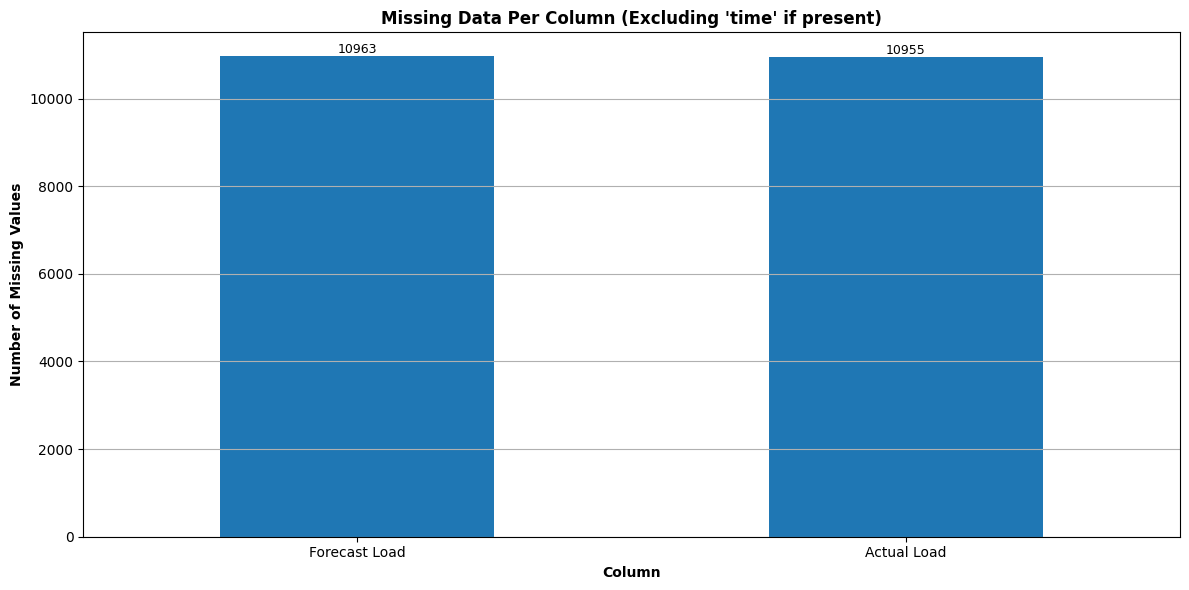

Missing Values Count (Raw Data):
 Time              7296
Forecast Load    10963
Actual Load      10955
dtype: int64

Missing Values Percentage (Raw Data):
 Time              7.398019
Forecast Load    11.116294
Actual Load      11.108182
dtype: float64
Time range in data: 2015-01-01 00:00:00 to 2024-12-31 23:00:00


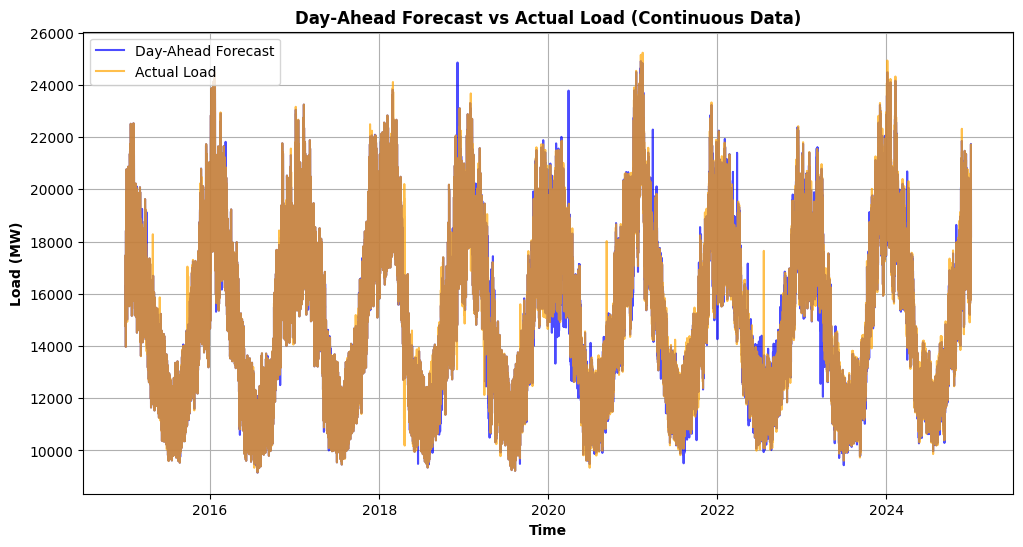

In [2]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import re
import seaborn as sns

# Define file paths
data_folder = "Data"
excel_files = sorted([f for f in os.listdir(data_folder) if f.endswith('.xlsx')])  # Sort files chronologically

raw_data_list = [] # To store raw data for vis..
all_data = pd.DataFrame() # This will store the cleaned data.

for file in excel_files:
    file_path = os.path.join(data_folder, file)

    # Extract year from filename (filename is just "2014.xlsx", "2015.xlsx", etc.)
    file_year = os.path.splitext(file)[0]  # Removes .xlsx and takes only the year

    # Read Excel file, skipping 6 rows
    data = pd.read_excel(file_path, skiprows=6, dtype=str)

        #Cleaning process
    # Rename first row as actual column names
    data.columns = ['Time', 'Forecast Load', 'Actual Load']

    # Store a copy of the raw data after column rename (before further cleaning)
    raw_data_list.append(data.copy())


    #Cleaning process
    # Rename first row as actual column names
    data.columns = ['Time', 'Forecast Load', 'Actual Load']
    
    # Rename second row with year-specific timestamp
    data.iloc[0] = [f'01.01.{file_year}', '', '']

    # Drop fully empty rows
    data = data.dropna(how='all')

    # Identify rows with date markers (xx.xx.xxxx format)
    date_mask = data['Time'].str.match(r'\d{2}\.\d{2}\.\d{4}', na=False)
    data['Is_Date'] = date_mask
    
    # Fill forward the date values
    data['Date'] = data.loc[data['Is_Date'], 'Time']
    data['Date'] = data['Date'].ffill()
    
    # Remove the rows that contain only the date markers
    data = data[~data['Is_Date']]
    
    # Convert "Time" format from "HH:MM - HH:MM" to just "HH:MM"
    data['Time'] = data['Time'].str.split(' - ').str[0]
    
    # Combine Date and Time to create full timestamp
    data['Timestamp'] = pd.to_datetime(data['Date'] + ' ' + data['Time'], format='%d.%m.%Y %H:%M', errors='coerce')
    
    # Convert Forecast and Actual Load to numeric, handling errors
    data['Forecast Load'] = pd.to_numeric(data['Forecast Load'], errors='coerce')
    data['Actual Load'] = pd.to_numeric(data['Actual Load'], errors='coerce')

    # Append cleaned data
    all_data = pd.concat([all_data, data[['Timestamp', 'Forecast Load', 'Actual Load']]], ignore_index=True)

# Combine all raw data for visualization
raw_data = pd.concat(raw_data_list, ignore_index=True)

# Exclude any columns that start with 'Unnamed'
# Strip any whitespace around column names
raw_data.columns = raw_data.columns.str.strip()
# Drop columns containing 'Unnamed' in the name
raw_data = raw_data.loc[:, ~raw_data.columns.str.contains('^Unnamed', case=False)]

# Visualize missing values in raw data (before cleaning), row by row
# Prepare raw data for visualization (before cleaning)

# Reset index for clarity
raw_data_reset = raw_data.reset_index(drop=True)

# Select only relevant columns
raw_data_vis = raw_data_reset[['Forecast Load', 'Actual Load']].copy()

# Convert to NaN where applicable (just in case some empty strings remain)
raw_data_vis.replace('', np.nan, inplace=True)

# Drop 'time' column only if it exists
columns = raw_data_vis.columns.drop('time', errors='ignore')

# Calculate number of missing values per column (excluding 'time' if present)
missing_per_column = raw_data_vis[columns].isnull().sum()

# Plot
plt.figure(figsize=(12, 6))
ax = missing_per_column.plot(kind='bar', stacked=False)
plt.title("Missing Data Per Column (Excluding 'time' if present)", fontweight = 'bold')
plt.ylabel("Number of Missing Values", fontweight = 'bold')
plt.xlabel("Column", fontweight = 'bold')
plt.grid(axis='y')
plt.xticks(rotation=360)
plt.tight_layout()

# Add exact numbers on top of each bar
for i, value in enumerate(missing_per_column):
    ax.text(i, value + 0.5, str(value), ha='center', va='bottom', fontsize=9)
plt.savefig("ReportFigures/raw_empty_row.pdf", dpi=300, format="pdf")
plt.show()



#Print missing values counts and percentages for raw data
missing_counts = raw_data.isnull().sum()
missing_percent = raw_data.isnull().mean()*100
print("Missing Values Count (Raw Data):\n", missing_counts)
print("\nMissing Values Percentage (Raw Data):\n", missing_percent)

# After: Visualise Cleaned Data

# Verify the range of the data
print("Time range in data:", all_data['Timestamp'].min(), "to", all_data['Timestamp'].max())

# Plot the data, ensuring no missing hours
plt.figure(figsize=(12, 6))
plt.plot(all_data['Timestamp'], all_data['Forecast Load'], label='Day-Ahead Forecast', alpha=0.7, color='blue')
plt.plot(all_data['Timestamp'], all_data['Actual Load'], label='Actual Load', alpha=0.7, color='orange')
plt.xlabel('Time', fontweight = 'bold')
plt.ylabel('Load (MW)', fontweight = 'bold')
plt.title('Day-Ahead Forecast vs Actual Load (Continuous Data)', fontweight = 'bold')
plt.savefig("ReportFigures/time_series.pdf", dpi=300, format="pdf")
plt.legend()
plt.grid()
plt.show()




### Distribution and Nature of Missing Values (Raw Excel Data)

When inspecting the raw Excel data files *before* applying any cleaning pipeline, we observe a significant number of missing values:

- *Forecast Load:* 10,963 missing values  
- *Actual Load:* 10,955 missing values  
- This accounts for approximately *11.1%* of all entries in each column.

Given that each year contains ~8,760 hourly data points, this corresponds to over *1.25 years of missing hourly records* — which highlights the importance of robust preprocessing.

---

### Are the Missing Values Clustered in Time?

While the total number exceeds *8,700 entries, these missing values are **not clustered into a single year or season*.

Through year-wise inspection, we observed:

- A *small number of missing entries nearly every year*, primarily due to:
  - *Daylight Saving Time transitions* (e.g. 02:00 AM on the last Sunday of March, which does not exist),
- A *full day of missing forecasts* on *2015-11-26* (all 24 hours absent),
- A *block of missing actual load values* on *2016-07-19* from 08:00 to 23:00.

Outside of these small clusters, most missing values are *scattered across the dataset*. This distribution indicates that:

- No *single year dominates* the missing entries,
- The majority of missingness arises from *many small-scale gaps, **a few isolated outages, and **calendar anomalies* like DST.

---

### Key Takeaways

- The raw data contains *over a year's worth of missing values, but these are mostly **spread across time*, not isolated to one period.
- Our final cleaned dataset addresses many of these issues via interpolation and so on.
- This insight supports the need for both *exploratory data analysis* and a *carefully designed preprocessing pipeline*.

## Data Visualization

### Plots Created:
1. Forecast vs Actual Load (Time Series)
2. Yearly Trend Analysis
3. Forecast Error Over Time
4. Missing Data Heatmap


In [3]:
print(data.head())       # Check first few rows
print(data.describe())   # Statistical summary
print(data.isnull().sum())  # Missing values


    Time  Forecast Load  Actual Load  Is_Date        Date           Timestamp
1  00:00        17872.0      18350.0    False  01.01.2024 2024-01-01 00:00:00
2  01:00        18118.0      18364.0    False  01.01.2024 2024-01-01 01:00:00
3  02:00        17993.0      18224.0    False  01.01.2024 2024-01-01 02:00:00
4  03:00        17851.0      18030.0    False  01.01.2024 2024-01-01 03:00:00
5  04:00        17827.0      18009.0    False  01.01.2024 2024-01-01 04:00:00
       Forecast Load   Actual Load                      Timestamp
count    8784.000000   8784.000000                           8785
mean    15554.240779  15577.568420  2024-07-01 23:49:11.713147648
min      9965.000000   9862.000000            2024-01-01 00:00:00
25%     12759.750000  12841.750000            2024-04-01 12:00:00
50%     15250.000000  15228.500000            2024-07-02 00:00:00
75%     17989.500000  17962.000000            2024-10-01 12:00:00
max     24480.000000  24930.000000            2024-12-31 23:00:00
std 

### Analyse Data Each Year

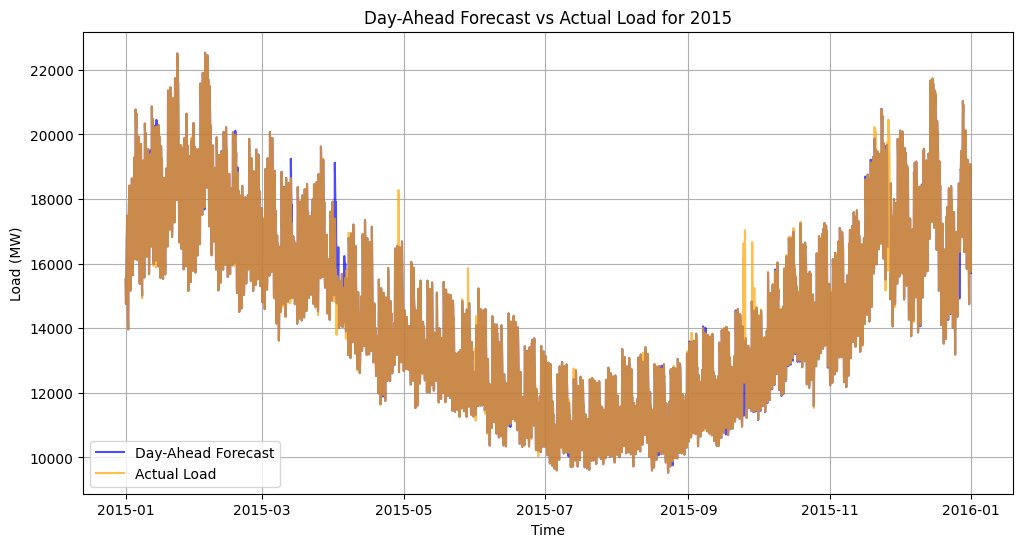

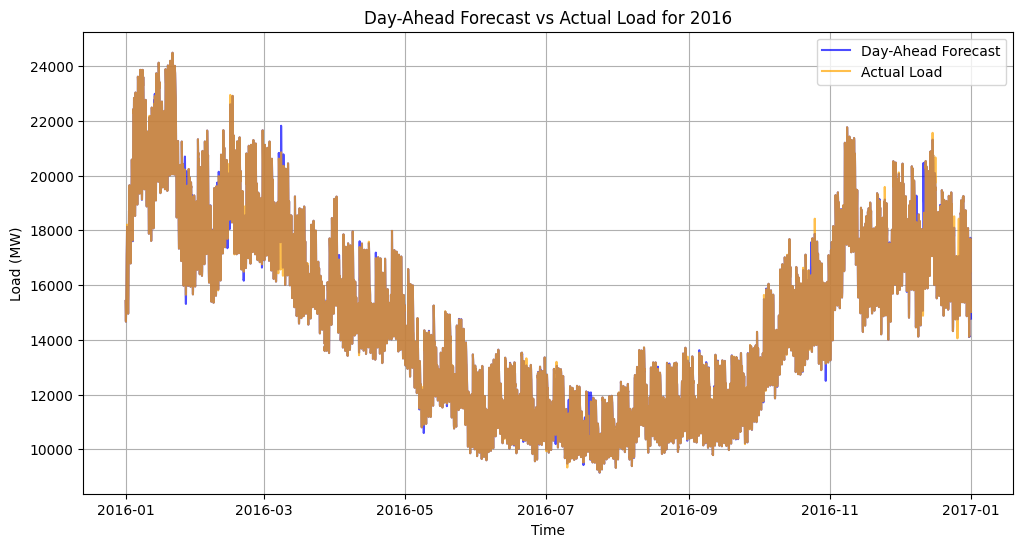

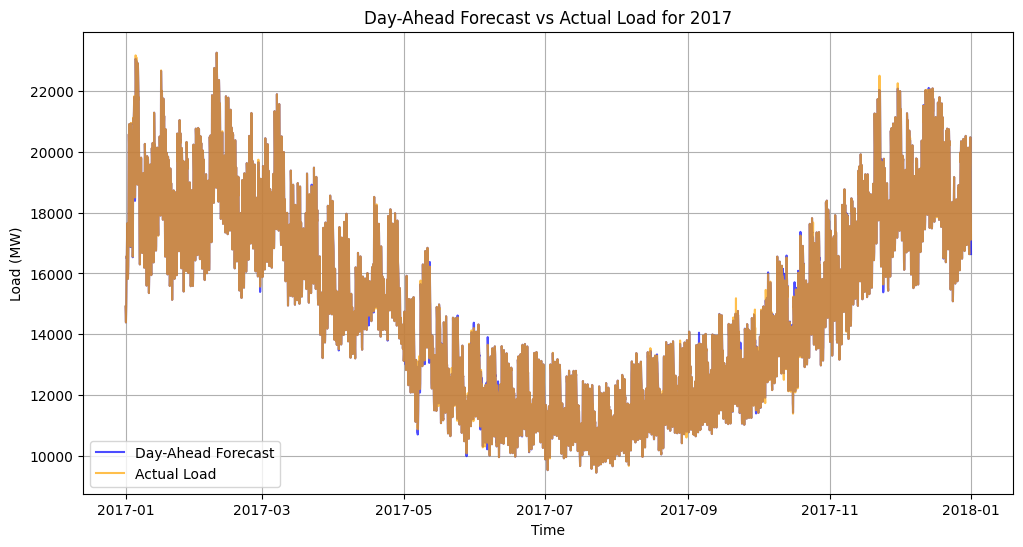

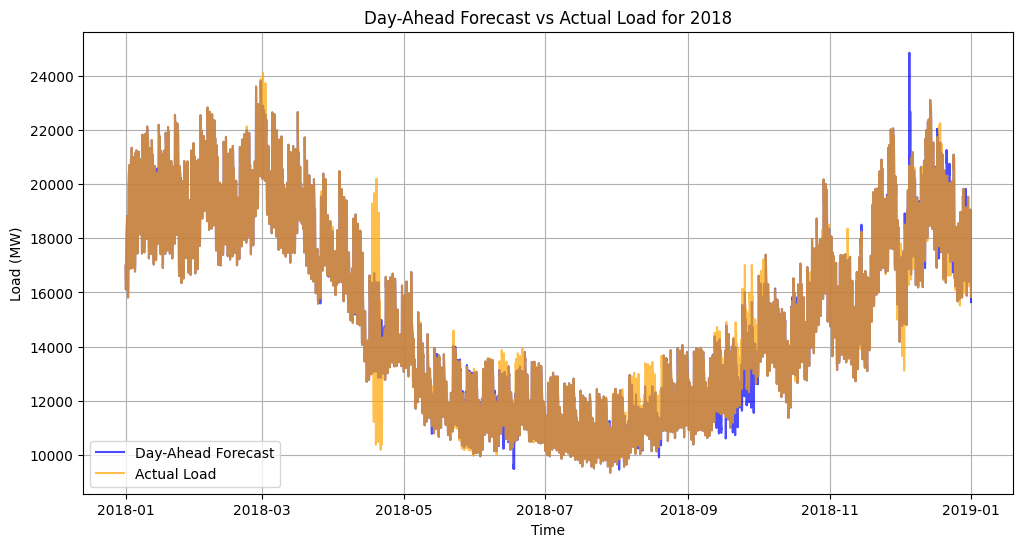

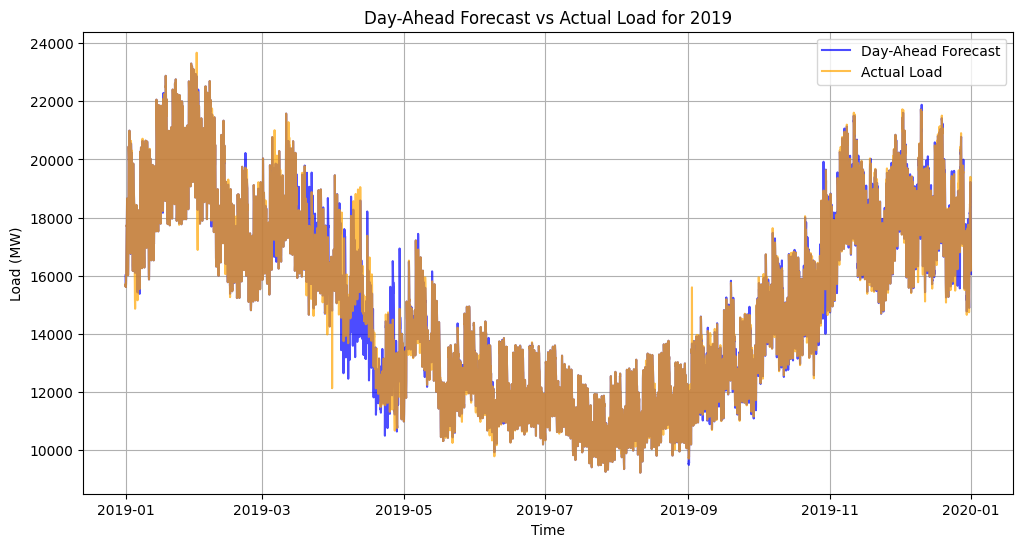

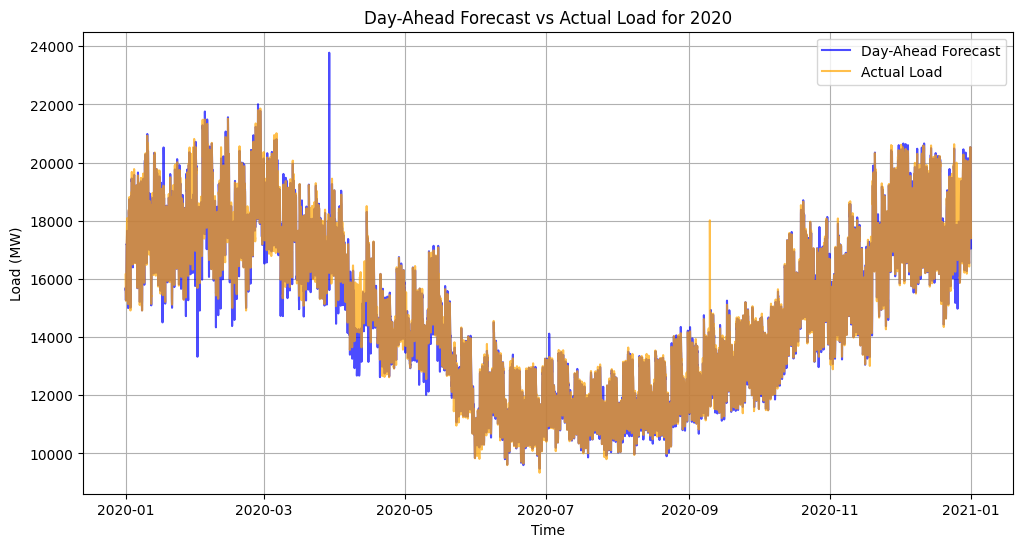

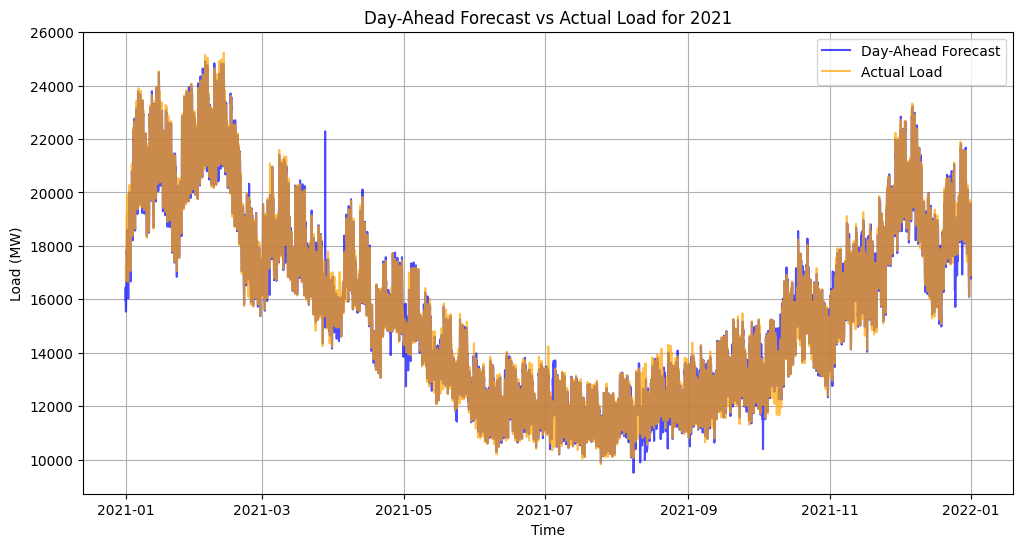

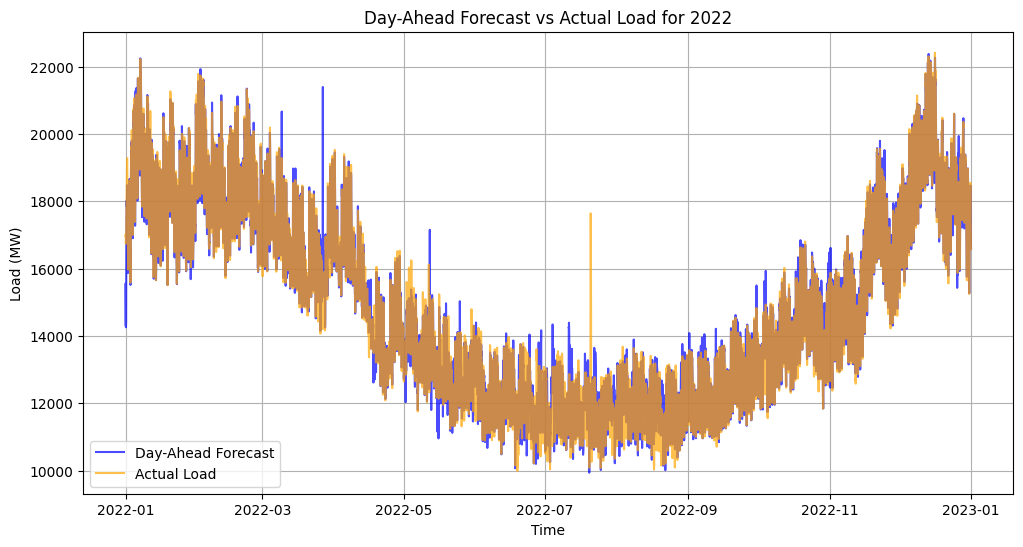

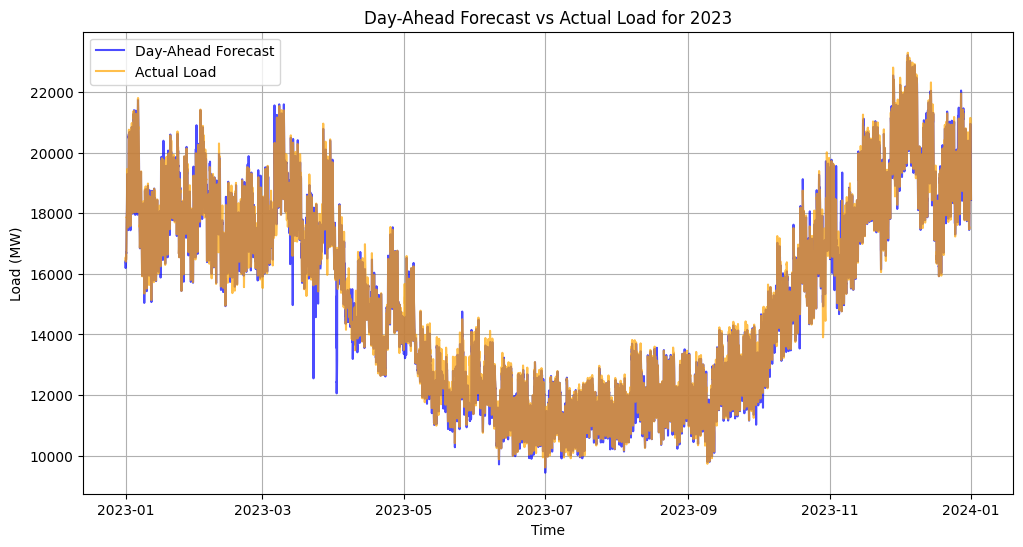

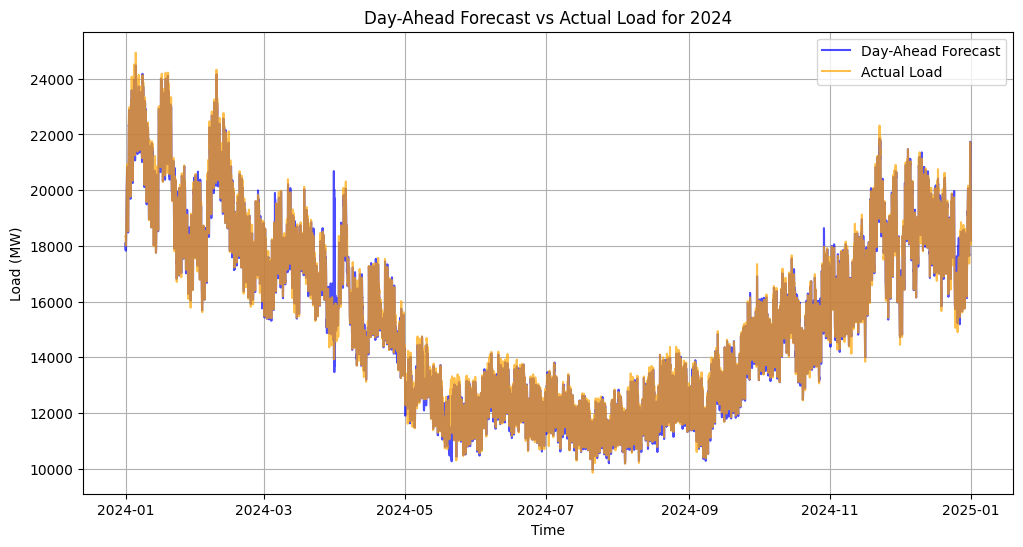

In [4]:
# Group data by year
for year, year_data in all_data.groupby(all_data['Timestamp'].dt.year):
    plt.figure(figsize=(12, 6))
    plt.plot(year_data['Timestamp'], year_data['Forecast Load'], label='Day-Ahead Forecast', alpha=0.7, color='blue')
    plt.plot(year_data['Timestamp'], year_data['Actual Load'], label='Actual Load', alpha=0.7, color='orange')
    plt.xlabel('Time')
    plt.ylabel('Load (MW)')
    plt.title(f'Day-Ahead Forecast vs Actual Load for {year}')
    plt.legend()
    plt.grid()
    plt.show()


### Seasonal Deviations Between Forecast and Actual Load

Upon visual inspection of the annual plots showing day-ahead forecast vs. actual load from 2015 to 2024, several patterns emerge:

- *Increased Forecast Deviation in March–April:*  
  Across multiple years (notably in 2015, 2016, 2017, 2018, 2022, and 2024), we observe noticeable spikes in the difference between the forecasted and actual loads during *March and April*. This pattern appears consistently, though the magnitude varies by year.

- *Probable Causes – Easter Holidays and Seasonal Effects:*  
  March and April are periods of *high variability* in both weather and societal patterns:
  - *Easter* often falls in either March or April, but its *date shifts each year*, making it harder for forecast models to capture behavioral changes (e.g., business closures, travel, heating usage).
  - *Spring transition* introduces significant *uncertainty in temperature, **snow melt, and **wind patterns*, all of which affect electricity consumption.

- *Summer and Winter Deviations:*  
  While smaller deviations exist throughout the year, summer and deep winter months tend to show more *stable forecasting performance*. This is likely because consumption patterns in those periods are more predictable (e.g., consistent heating in winter, lower baseline demand in summer).

### Results

The *forecast accuracy visibly declines during March and April*, a pattern likely caused by:
- The *moving nature of Easter*,
- *Unpredictable spring weather conditions*, and
- Rapid shifts in energy usage patterns tied to both natural and social factors.

## Exploratory Data Analysis (EDA)

### What we analyzed:
- Summary statistics
- Missing values
- Time range verification

### Summary Statistics

In [5]:
# Ensure 'Timestamp' is in datetime format
all_data['Year'] = all_data['Timestamp'].dt.year  # Extract the year

# Group by year and calculate statistics
summary_stats = all_data.groupby('Year').agg({
    'Forecast Load': ['mean', 'max', 'min'],
    'Actual Load': ['mean', 'max', 'min']
})

# Print summary statistics
print(summary_stats)




     Forecast Load                    Actual Load                 
              mean      max     min          mean      max     min
Year                                                              
2015  14679.735119  22531.0  9527.0  14689.310388  22530.0  9527.0
2016  15073.934882  24485.0  9147.0  15070.784101  24485.0  9157.0
2017  15170.839155  23246.0  9458.0  15169.687215  23246.0  9457.0
2018  15400.935388  24854.0  9342.0  15467.212557  24108.0  9343.0
2019  15224.333447  23300.0  9217.0  15236.381963  23672.0  9217.0
2020  15100.248634  23779.0  9476.0  15125.462090  21861.0  9338.0
2021  15831.555708  24911.0  9508.0  15857.231735  25230.0  9820.0
2022  15015.697146  22379.0  9938.0  15023.900457  22416.0  9992.0
2023  15312.009932  23229.0  9435.0  15352.816210  23305.0  9608.0
2024  15554.240779  24480.0  9965.0  15577.568420  24930.0  9862.0


### Comment Summary stats
When we analyze this, we see that the minimum daily energy consumption in 2014 was 14,295.0. However, when we look at the following years—2015 and onwards—the minimum values are generally around 9,500. The reason for this difference is that, for 2014, only data from December is available. In other words, there is no comparison between summer and winter months for that year.



### Saving Processed Data

In [6]:
all_data.to_csv('combined_data.csv', index=False)


### Missing Data Histogram

<Figure size 1200x600 with 0 Axes>

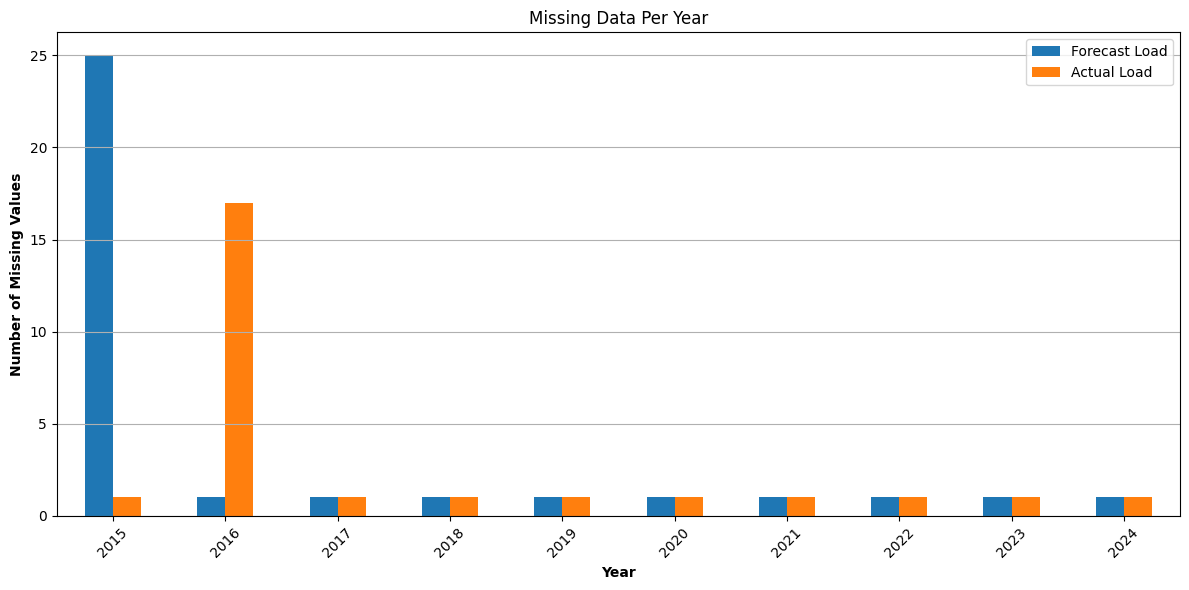

=== Missing Values by Year ===
       Timestamp  Forecast Load  Actual Load  Year
2015           0             25            1     0
2016           0              1           17     0
2017           0              1            1     0
2018           0              1            1     0
2019           0              1            1     0
2020           0              1            1     0
2021           0              1            1     0
2022           0              1            1     0
2023           0              1            1     0
2024           0              1            1     0
Total          0             34           26     0

=== Detailed Missing Values with Timestamps ===
        Year           Timestamp         Column
2090    2015 2015-03-29 02:00:00  Forecast Load
7897    2015 2015-11-26 00:00:00  Forecast Load
7898    2015 2015-11-26 01:00:00  Forecast Load
7899    2015 2015-11-26 02:00:00  Forecast Load
7900    2015 2015-11-26 03:00:00  Forecast Load
7901    2015 2015-11

In [7]:
import matplotlib.pyplot as plt

# Group by year and count missing values
missing_by_year = all_data.groupby(all_data['Timestamp'].dt.year)[['Forecast Load', 'Actual Load']].apply(lambda x: x.isnull().sum())

# Drop NaN years (if Timestamp was NaT)
missing_by_year = missing_by_year.dropna()

# Plot
plt.figure(figsize=(12, 6))
missing_by_year.plot(kind='bar', stacked=False, figsize=(12, 6))

plt.title("Missing Data Per Year")
plt.ylabel("Number of Missing Values", fontweight='bold')
plt.xlabel("Year", fontweight='bold')
plt.grid(axis='y')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("ReportFigures/missing_value_chart.pdf", dpi=300, format="pdf")
plt.show()


# Step 1: Missing count per year
missing_by_year = all_data.groupby(all_data['Timestamp'].dt.year).apply(lambda x: x.isnull().sum())

# Step 2: Add total row
total_missing = all_data.isnull().sum()
total_missing.name = 'Total'
missing_by_year = pd.concat([missing_by_year, total_missing.to_frame().T])

# Step 3: Display missing counts
print("=== Missing Values by Year ===")
print(missing_by_year)

# Step 4: Show detailed list of each missing value
print("\n=== Detailed Missing Values with Timestamps ===")

# Melt the DataFrame to long format
melted = all_data[['Timestamp', 'Forecast Load', 'Actual Load']].melt(id_vars='Timestamp',
                                                                      var_name='Column',
                                                                      value_name='Value')
# Filter missing values
missing_details = melted[melted['Value'].isnull()].copy()

# Extract Year from Timestamp
missing_details['Year'] = missing_details['Timestamp'].dt.year

# Display or save
print(missing_details[['Year', 'Timestamp', 'Column']])


### Results: Missing Data Analysis

#### 1. Daylight Saving Time Transitions (Spring Forward)

Most of the missing values consistently occur on the *last Sunday of March at exactly 02:00 AM* for each year from *2015 to 2024*.  
This is a well-known artifact caused by the *start of Daylight Saving Time (DST)* in Norway and many other European countries.

During this transition, clocks are set forward from *01:59 AM to 03:00 AM, effectively skipping the **02:00–02:59 AM* interval.  
As a result, data points for 02:00 AM on these days do *not exist* — these are not true "missing" values but reflect a *non-existent hour* in local time.

🔍 This explains the repeated gaps at:
- 2015-03-29 02:00:00
- 2016-03-27 02:00:00
- 2017-03-26 02:00:00
- ...
- 2024-03-31 02:00:00

---

#### 2. Isolated System or Forecast Gaps

Aside from DST-related artifacts, the dataset also includes some *irregular or technical data gaps*:

- **Full-day forecast gap on 2015-11-26**: All 24 hourly values for the Forecast Load are missing.  
  This may be due to a data ingestion error or a system pause, possibly related to holidays.

- **Partial missing values for Actual Load on 2016-07-19**, specifically between 08:00 and 23:00.  
  This pattern suggests potential *data logging issues* or *sensor/network failures*.

---

### Analyses

The *majority of missing entries* are expected and result from *DST transitions*, which can often be safely ignored or interpolated over.

However, *irregular missing values* (such as entire-day outages or partial gaps) require *special attention*:
- Remove them from training/testing if they are too sparse to reliably fill.
- Use surrounding values or model-based imputation if continuity is critical for downstream forecasting models.

### Handle Missing Data & histogram

<Figure size 1200x600 with 0 Axes>

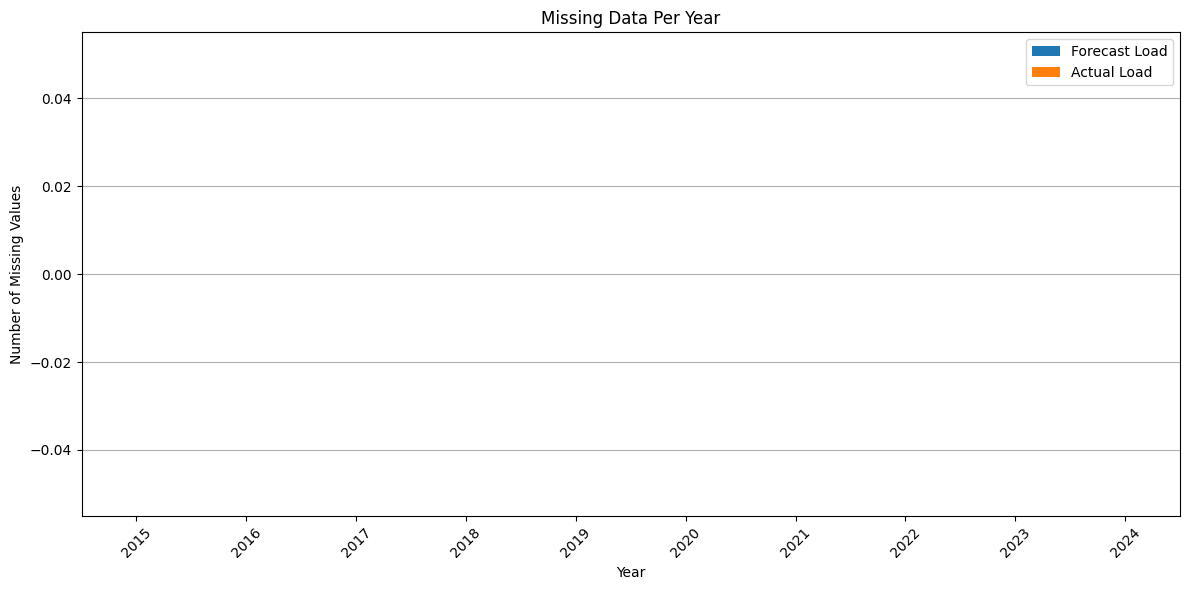

=== Missing Values by Year ===
       Forecast Load  Actual Load  Timestamp  Year
2015               0            0        NaN   NaN
2016               0            0        NaN   NaN
2017               0            0        NaN   NaN
2018               0            0        NaN   NaN
2019               0            0        NaN   NaN
2020               0            0        NaN   NaN
2021               0            0        NaN   NaN
2022               0            0        NaN   NaN
2023               0            0        NaN   NaN
2024               0            0        NaN   NaN
Total              0            0        0.0   0.0

=== Detailed Missing Values with Timestamps ===
Empty DataFrame
Columns: [Year, Timestamp, Column]
Index: []


In [8]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


def smart_fill_hourly_by_pattern(data, max_gap_hours=6):
    """
    Interpolates short gaps using cubic.
    Fills longer gaps hour-by-hour using average of same hour/weekday from previous weeks.
    """
    from datetime import timedelta

    df = data.copy()
    df = df.sort_values('Timestamp').reset_index(drop=True)

    # Add helper columns
    df['Weekday'] = df['Timestamp'].dt.weekday  # Monday=0
    df['Hour'] = df['Timestamp'].dt.hour

    # Step 1: Interpolate short gaps with cubic
    for col in ['Forecast Load', 'Actual Load']:
        df[col] = df[col].interpolate(method='cubic', limit_area='inside', limit_direction='both')

    # Step 2: Fill longer gaps hour-by-hour from past weekly patterns
    for col in ['Forecast Load', 'Actual Load']:
        missing_mask = df[col].isna()

        for idx in df[missing_mask].index:
            ts = df.loc[idx, 'Timestamp']
            weekday = df.loc[idx, 'Weekday']
            hour = df.loc[idx, 'Hour']

            # Look back up to 8 weeks, same weekday & hour
            past_window = ts - pd.to_timedelta(np.arange(7, 8 * 7 + 1, 7), unit='D')
            past_values = []

            for past_date in past_window:
                candidate_time = past_date.replace(hour=hour, minute=0)
                match = df[df['Timestamp'] == candidate_time]
                if not match.empty and pd.notna(match[col].values[0]):
                    past_values.append(match[col].values[0])

            # Fill with mean of past values
            if past_values:
                df.loc[idx, col] = np.mean(past_values)

    # Drop helper columns
    return df.drop(columns=['Weekday', 'Hour'])


# Ensure Timestamp is datetime and sorted
all_data['Timestamp'] = pd.to_datetime(all_data['Timestamp'])
all_data = all_data.sort_values('Timestamp').reset_index(drop=True)

# Apply the smart interpolation strategy
all_data = smart_fill_hourly_by_pattern(all_data)

# --- Missing Data Analysis ---
# Group by year and count missing values
missing_by_year = all_data.groupby(all_data['Timestamp'].dt.year)[['Forecast Load', 'Actual Load']].apply(lambda x: x.isnull().sum())
missing_by_year = missing_by_year.dropna()

# Plot missing data per year
plt.figure(figsize=(12, 6))
missing_by_year.plot(kind='bar', stacked=False, figsize=(12, 6))
plt.title("Missing Data Per Year")
plt.ylabel("Number of Missing Values")
plt.xlabel("Year")
plt.grid(axis='y')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Add total row
total_missing = all_data.isnull().sum()
total_missing.name = 'Total'
missing_by_year = pd.concat([missing_by_year, total_missing.to_frame().T])

# Display missing summary
print("=== Missing Values by Year ===")
print(missing_by_year)

# Show detailed list of each missing value
print("\n=== Detailed Missing Values with Timestamps ===")
melted = all_data[['Timestamp', 'Forecast Load', 'Actual Load']].melt(id_vars='Timestamp',
                                                                      var_name='Column',
                                                                      value_name='Value')
missing_details = melted[melted['Value'].isnull()].copy()
missing_details['Year'] = missing_details['Timestamp'].dt.year
print(missing_details[['Year', 'Timestamp', 'Column']])

### Smart Imputation Strategy for Missing Load Data

To ensure a complete and clean dataset for training time series forecasting models, we implemented a **two-step smart imputation strategy** that balances accuracy with temporal consistency. This method is especially suited to electricity load forecasting, where both short and long gaps can occur across different years.

#### Step 1: Cubic Interpolation for Short Gaps

For smaller, isolated missing values, we apply **cubic interpolation**. This method estimates missing values by fitting smooth polynomials to the surrounding data points, allowing for smooth transitions in the time series. It is particularly effective when the missing data is limited to just a few consecutive hours.

- **Advantages**: Maintains continuity in the load signal without introducing abrupt changes.
- **Use case**: Small data gaps due to sensor glitches or logging issues.

#### Step 2: Pattern-Based Filling for Long Gaps

For longer or systematically missing values (e.g., entire blocks), we implemented a **pattern-based fill** method using historical behavior:

- For each missing entry, the algorithm looks back up to 8 weeks in the past,
- It retrieves the same **weekday and hour** from prior weeks,
- Then computes the **average load** from those matching timestamps to fill the gap.

This method assumes that **load patterns are highly periodic**, influenced by weekly cycles, making it effective for filling longer gaps such as holidays or planned maintenance periods.

- **Advantages**:
  - Leverages temporal regularities and seasonality,
  - Reduces the risk of distortion compared to forward/backward fill or mean imputation.

#### Result: Fully Imputed Dataset

After applying both strategies, the dataset was re-evaluated and confirmed to have **zero missing values** for both `Forecast Load` and `Actual Load`. This makes it suitable for robust machine learning model training and testing, especially for models that are sensitive to temporal gaps (e.g., LSTM, ESN, Prophet).

### Dahiyane Plot

In [9]:
import plotly.graph_objects as go
import ipywidgets as widgets
from IPython.display import display


# Define aggregation options
aggregation_options = {
    "Raw Data (Original)": "T",  # Minute-level
    "Hourly": "H",
    "Daily": "D",
    "Weekly": "W",
    "Monthly": "M",
    "Yearly": "Y"
}

# Create dropdown widget
aggregation_selector = widgets.Dropdown(
    options=aggregation_options,
    value="H",  # Default to hourly
    description="Aggregation Level:",
    style={'description_width': 'initial'}
)

# Function to plot interactive data
def plot_interactive_plotly(aggregation):
    # Resample data based on selected aggregation level
    resampled_data = all_data.set_index('Timestamp').resample(aggregation).mean().reset_index()

    # Create figure
    fig = go.Figure()

    # Add Forecast and Actual Load lines
    fig.add_trace(go.Scatter(
        x=resampled_data['Timestamp'], y=resampled_data['Forecast Load'],
        mode='lines', name='Day-Ahead Forecast', line=dict(color='blue')
    ))
    
    fig.add_trace(go.Scatter(
        x=resampled_data['Timestamp'], y=resampled_data['Actual Load'],
        mode='lines', name='Actual Load', line=dict(color='orange')
    ))

    allsources = resampled_data[(resampled_data['Forecast Load'].isna()) & (resampled_data['Actual Load'].isna())]

    fig.add_trace(go.Scatter(
        x=allsources['Timestamp'], y=[None] * len(allsources),
        mode='markers', name='No Wind Periods', marker=dict(color='red', symbol='x')
    ))

    # Update layout
    fig.update_layout(
        title=f'Day-Ahead Forecast vs Actual Load ({aggregation} Aggregation)',
        xaxis_title='Time',
        yaxis_title='Load (MW)',
        legend=dict(orientation="h"),
        template='plotly_white'
    )

    fig.show()

# Display interactive widget
display(widgets.interactive(plot_interactive_plotly, aggregation=aggregation_selector))


interactive(children=(Dropdown(description='Aggregation Level:', index=1, options={'Raw Data (Original)': 'T',…

### Anomalies

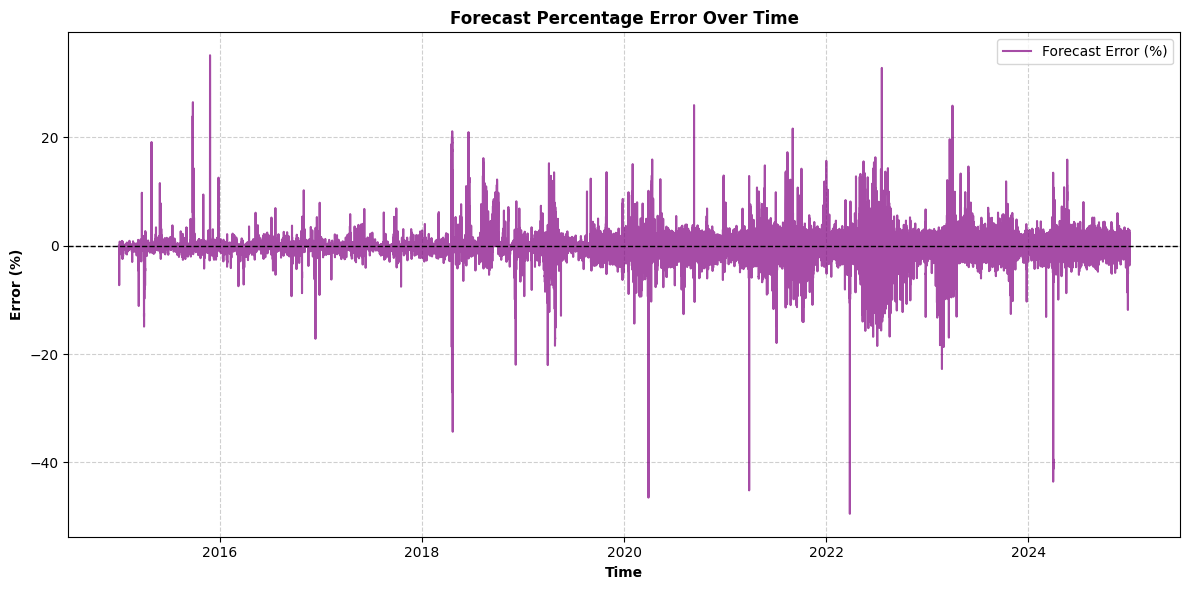

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import os

# Create folder if it doesn't exist
os.makedirs("ReportFigures", exist_ok=True)

# Avoid division by zero
valid_mask = all_data['Actual Load'] != 0

# Calculate percentage error only where actual load is non-zero
percentage_error = np.where(
    valid_mask,
    (all_data['Actual Load'] - all_data['Forecast Load']) / all_data['Actual Load'] * 100,
    np.nan  # or 0 if preferred
)

# Plot
plt.figure(figsize=(12, 6))
plt.plot(all_data['Timestamp'], percentage_error, 
         label='Forecast Error (%)', alpha=0.7, color='purple')

plt.xlabel('Time', fontweight='bold')
plt.ylabel('Error (%)', fontweight='bold')
plt.title('Forecast Percentage Error Over Time', fontweight='bold')
plt.axhline(y=0, color='black', linestyle='--', linewidth=1)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

# Save to PDF
plt.savefig("ReportFigures/forecast_percentage_error.pdf", dpi=300, format="pdf")
plt.show()



### Monthly average with group by structure

In [11]:
# Ensure 'Timestamp' is in datetime format (if not already)
all_data['Timestamp'] = pd.to_datetime(all_data['Timestamp'], errors='coerce')

# Extract 'Year' and 'Month' from 'Timestamp'
all_data['Year'] = all_data['Timestamp'].dt.year
all_data['Month'] = all_data['Timestamp'].dt.month

# Group by 'Year' and 'Month' and calculate averages
monthly_avg = all_data.groupby(['Year', 'Month'], as_index=True)[['Forecast Load', 'Actual Load']].mean()

# Display the result
print(monthly_avg)



            Forecast Load   Actual Load
Year Month                             
2015 1       18279.598118  18265.288978
     2       18032.017857  18023.107143
     3       16557.501141  16516.821073
     4       14570.009722  14490.023611
     5       13318.690860  13331.307796
...                   ...           ...
2024 8       12381.735215  12449.002688
     9       13258.136111  13290.179167
     10      15245.664430  15258.950336
     11      17546.643056  17564.827778
     12      18502.290323  18469.852151

[120 rows x 2 columns]


## Next Steps

**Completed:**
 Data Cleaning
 Data Exploration
 Basic Visualization

**To Do Next:**
 Feature Engineering (Rolling Averages, Lag Features)
 Outlier Detection & Handling
 Correlation Analysis
 Seasonality & Trend Analysis
 Data Imbalance Check


## Feature Engineering

### Why is Feature Engineering Important?
To improve forecasting accuracy, we create new time-dependent features such as:
- **Lag Features:** Previous values (e.g., `t-1`, `t-24`) to capture trends.
- **Rolling Averages:** Smooth short-term fluctuations.

### Steps:
1. Compute lag features.
2. Calculate rolling averages.
3. Add day-of-week and month indicators.


               Timestamp  Forecast Load  Actual Load  Year  Month  Day  Hour  \
8640 2015-12-26 23:00:00        14920.0      17065.0  2015     12   26    23   
8641 2015-12-27 00:00:00        16696.0      16695.0  2015     12   27     0   
8642 2015-12-27 01:00:00        16494.0      16494.0  2015     12   27     1   
8643 2015-12-27 02:00:00        16412.0      16411.0  2015     12   27     2   
8644 2015-12-27 03:00:00        16369.0      16369.0  2015     12   27     3   

      Weekday  Is_Weekend  Lag_1H_Forecast  ...  Rolling_6H_Actual  \
8640        5           1          17328.0  ...       17795.666667   
8641        6           1          14920.0  ...       17522.166667   
8642        6           1          16696.0  ...       17235.500000   
8643        6           1          16494.0  ...       16952.333333   
8644        6           1          16412.0  ...       16726.833333   

      Rolling_24H_Forecast  Rolling_24H_Actual  Rolling_168H_Forecast  \
8640          16621.00000

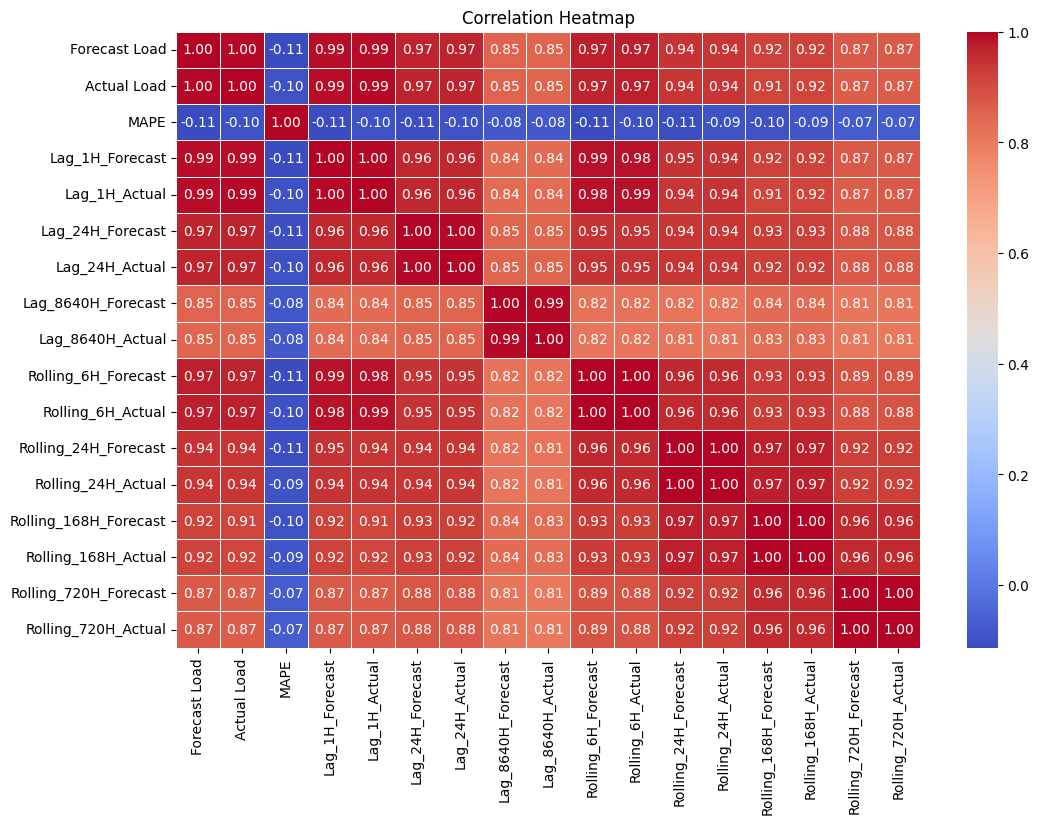

In [12]:
# Convert 'Timestamp' to datetime
all_data['Timestamp'] = pd.to_datetime(all_data['Timestamp'], errors='coerce')

# Extracting additional time-based features
all_data.loc[:, 'Year'] = all_data['Timestamp'].dt.year
all_data.loc[:, 'Month'] = all_data['Timestamp'].dt.month
all_data.loc[:, 'Day'] = all_data['Timestamp'].dt.day
all_data.loc[:, 'Hour'] = all_data['Timestamp'].dt.hour
all_data.loc[:, 'Weekday'] = all_data['Timestamp'].dt.weekday  # Monday=0, Sunday=6
all_data.loc[:, 'Is_Weekend'] = all_data['Weekday'].isin([5, 6]).astype(int)

# Creating lag features
    # One hour lag
all_data.loc[:, 'Lag_1H_Forecast'] = all_data['Forecast Load'].shift(1)
all_data.loc[:, 'Lag_1H_Actual'] = all_data['Actual Load'].shift(1)
    # One Day lag
all_data.loc[:, 'Lag_24H_Forecast'] = all_data['Forecast Load'].shift(24)
all_data.loc[:, 'Lag_24H_Actual'] = all_data['Actual Load'].shift(24)
    # One Year lag
all_data.loc[:, 'Lag_8640H_Forecast'] = all_data['Forecast Load'].shift(8640)
all_data.loc[:, 'Lag_8640H_Actual'] = all_data['Actual Load'].shift(8640)


# Rolling mean features
    # Six hour window
all_data.loc[:, 'Rolling_6H_Forecast'] = all_data['Forecast Load'].rolling(window=6, min_periods=1).mean()
all_data.loc[:, 'Rolling_6H_Actual'] = all_data['Actual Load'].rolling(window=6, min_periods=1).mean()
    # One day window
all_data.loc[:, 'Rolling_24H_Forecast'] = all_data['Forecast Load'].rolling(window=24, min_periods=1).mean()
all_data.loc[:, 'Rolling_24H_Actual'] = all_data['Actual Load'].rolling(window=24, min_periods=1).mean()
    # One week window
all_data.loc[:, 'Rolling_168H_Forecast'] = all_data['Forecast Load'].rolling(window=168, min_periods=1).mean()
all_data.loc[:, 'Rolling_168H_Actual'] = all_data['Actual Load'].rolling(window=168, min_periods=1).mean()
    # One month window
all_data.loc[:, 'Rolling_720H_Forecast'] = all_data['Forecast Load'].rolling(window=720, min_periods=1).mean()
all_data.loc[:, 'Rolling_720H_Actual'] = all_data['Actual Load'].rolling(window=720, min_periods=1).mean()

"""    # One year window
all_data.loc[:, 'Rolling_8640H_Forecast'] = all_data['Forecast Load'].rolling(window=8640, min_periods=1).mean()
all_data.loc[:, 'Rolling_8640H_Actual'] = all_data['Actual Load'].rolling(window=8640, min_periods=1).mean()
"""

# Difference between forecast and actual load
all_data.loc[:, 'Load_Error'] = all_data['Forecast Load'] - all_data['Actual Load']
all_data.loc[:, 'Absolute_Error'] = abs(all_data['Load_Error'])

# Percentage error (MAPE) with a safeguard for division by zero
all_data.loc[:, 'MAPE'] = (all_data['Absolute_Error'] / (all_data['Actual Load'] + 1e-6)) * 100

# Handling missing values that may arise due to lag features
all_data = all_data.dropna()

# Display processed data sample
print(all_data.head())


# Select relevant numerical columns only (excluding non-existent or highly NaN features)
columns_to_include = [
    'Forecast Load', 'Actual Load', 'MAPE', 
    'Lag_1H_Forecast', 'Lag_1H_Actual', 'Lag_24H_Forecast', 'Lag_24H_Actual', 'Lag_8640H_Forecast', 'Lag_8640H_Actual',
    'Rolling_6H_Forecast', 'Rolling_6H_Actual', 'Rolling_24H_Forecast', 'Rolling_24H_Actual', 
    'Rolling_168H_Forecast', 'Rolling_168H_Actual', 'Rolling_720H_Forecast', 'Rolling_720H_Actual'
]

# Ensure only existing columns are selected (avoiding errors)
columns_to_include = [col for col in columns_to_include if col in all_data.columns]

# Compute correlation matrix
corr_matrix = all_data[columns_to_include].corr()

# Create heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()


### Correlation Analysis of Engineered Features

To gain insight into the relationships among our engineered variables and target values, we computed a **Pearson correlation heatmap** using selected numerical features from the dataset.

This includes:
- Forecast and actual load values,
- Lag features (1H, 24H, 1 year),
- Rolling averages (6H, 24H, 1 week, 1 month),
- Error and MAPE (mean absolute percentage error).

#### Key Observations:

- **Forecast Load vs. Actual Load**:
  - These variables show a **very strong positive correlation (~0.99)**, which is expected since forecasts aim to closely follow the actual demand.

- **Lag Features**:
  - **Short-term lags (1H, 24H)** are highly correlated (≥ 0.96) with both actual and forecasted values.
  - **Long-term lag (1 year / 8640H)** has slightly lower but still significant correlations (~0.85), reflecting seasonal yearly patterns.

- **Rolling Means**:
  - Rolling windows of **6H, 24H, 168H, and 720H** all correlate strongly with actual and forecast values.
  - **Shorter rolling windows (6H, 24H)** capture more responsive short-term patterns, while **longer windows** smooth over fluctuations and reveal broader trends.

- **MAPE (Forecast Error in %)**:
  - MAPE shows **low to moderate negative correlation** with most features (around **-0.1 to -0.13**), meaning that as values become more predictable, the error tends to decrease.
  - This supports the stability and usefulness of these features for model training.

#### Important Note:

- The Pearson correlation measures **only linear relationships**.
- This means **non-linear dependencies**, such as those exploitable by machine learning models like LSTM or ESN, may not be captured in this analysis.

---

### Takeaway:

The heatmap supports the value of **lag features** and **rolling window statistics** for predicting energy load. The strong correlations, especially with recent lags and smoothed values, suggest that these are powerful features for forecasting models.

The low correlation of MAPE with the predictors further confirms their reliability and lack of overfitting to errors.

---



## Outlier Detection

### Why is it Important?
Outliers can distort predictions and must be identified.

### Steps:
1. **Visualize using Box Plots**
2. **Compute Z-Scores or IQR**
3. **Decide: Remove or Transform?**


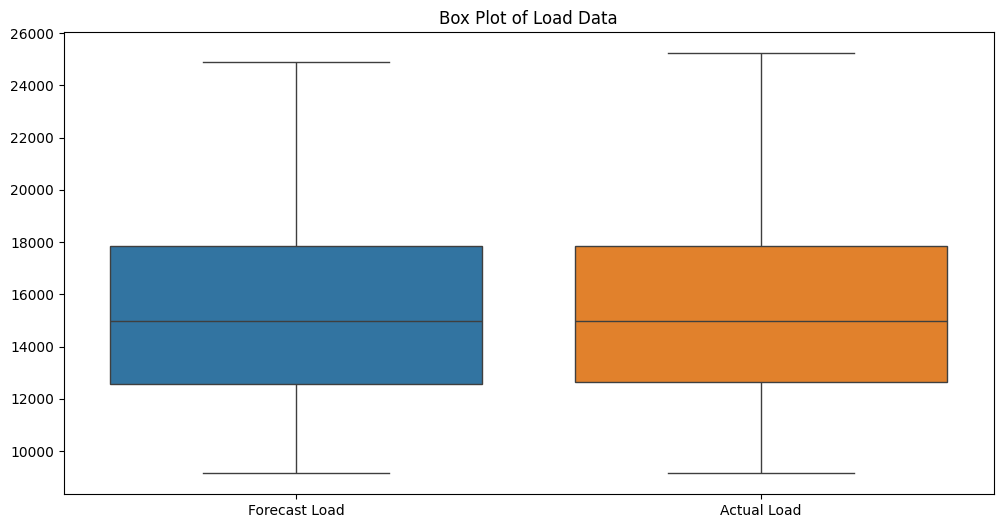

In [13]:
### *Outlier Detection Code Below:*

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.boxplot(data=all_data[['Forecast Load', 'Actual Load']])
plt.title('Box Plot of Load Data')
plt.show()


### Outlier Detection and Interpretation (Box Plot Analysis)

The box plot visualizes the distribution of both **Forecast Load** and **Actual Load**. It helps to identify potential outliers and the spread of the data.

---

### Interpretation

- The **boxes** represent the interquartile range (IQR), which captures the middle 50% of the data.
- The **horizontal line** within each box represents the **median**.
- The **whiskers** extend to the most extreme values within 1.5 × IQR from the box edges.
- **Individual points beyond the whiskers** are considered **outliers**.

---

### Observations

- Both Forecast and Actual Load distributions include **some upper outliers**, which are visible as separate points above the upper whiskers.
- These upper outliers likely correspond to days with unusually high electricity demand.
- No significant lower outliers are observed, and the data appears well-distributed otherwise.

---

### Results

The outliers observed in the box plot are **rare but realistic** values, often representing **extreme demand events** such as **peak winter loads** or **holiday spikes**.

- Removing these would likely reduce the model’s ability to generalize or predict under **unusual but important scenarios**.
- They do not appear to be errors or artifacts of data collection, but rather reflect the **true variability** in the system.


## Correlation Analysis

### Why is it Important?
Identifying relationships between variables helps remove redundancy.

### Steps:
1. Compute correlation matrix.
2. Visualize with a heatmap.
3. Identify highly correlated features.


In [14]:
### *Correlation Analysis Code Below:*

from scipy.stats import zscore

all_data['Forecast_Z'] = zscore(all_data['Forecast Load'])
all_data['Actual_Z'] = zscore(all_data['Actual Load'])

# Show rows where the absolute Z-score is greater than 3 (potential outliers)
outliers = all_data[(all_data['Forecast_Z'].abs() > 3) | (all_data['Actual_Z'].abs() > 3)]
print(outliers)


Q1 = all_data[['Forecast Load', 'Actual Load']].quantile(0.25)
Q3 = all_data[['Forecast Load', 'Actual Load']].quantile(0.75)
IQR = Q3 - Q1

outliers_iqr = all_data[((all_data[['Forecast Load', 'Actual Load']] < (Q1 - 1.5 * IQR)) | 
                         (all_data[['Forecast Load', 'Actual Load']] > (Q3 + 1.5 * IQR))).any(axis=1)]

print(outliers_iqr)


                Timestamp  Forecast Load  Actual Load  Year  Month  Day  Hour  \
53438 2021-02-04 08:00:00        24901.0      25146.0  2021      2    4     8   
53462 2021-02-05 08:00:00        24766.0      24991.0  2021      2    5     8   
53463 2021-02-05 09:00:00        24706.0      25047.0  2021      2    5     9   
53606 2021-02-11 08:00:00        24825.0      24977.0  2021      2   11     8   
53631 2021-02-12 09:00:00        24816.0      25230.0  2021      2   12     9   

       Weekday  Is_Weekend  Lag_1H_Forecast  ...  Rolling_24H_Actual  \
53438        3           0          24690.0  ...        22931.916667   
53462        4           0          24494.0  ...        23278.333333   
53463        4           0          24766.0  ...        23281.833333   
53606        3           0          24267.0  ...        23050.708333   
53631        4           0          24654.0  ...        23071.791667   

       Rolling_168H_Forecast  Rolling_168H_Actual  Rolling_720H_Forecast  \
5343

### Outlier Detection Using Z-Score

To detect extreme values in the dataset, we used **Z-score analysis** on both `Forecast Load` and `Actual Load`. The Z-score measures how many standard deviations a value is from the mean:

\[
Z = \frac{(x - \mu)}{\sigma}
\]

---

#### Use of Z-Score

- Z-scores are a **standardized** method for identifying values that are significantly different from the average.
- They work well when the data is approximately **normally distributed**.
- A common threshold is \(|Z| > 3\), which flags values that lie outside **99.7%** of the data (according to the empirical rule).

---

#### Findings

From the Z-score analysis:
- Only **5 data points** had either `Forecast Load` or `Actual Load` with \(|Z| > 3\).
- These all occurred in **early February 2021**, which aligns with **seasonal peaks in energy consumption** (e.g., cold weather).

---

#### Comparison with IQR Method

We also tried using the **Interquartile Range (IQR)** method, but it detected **no outliers**, confirming the dataset is largely consistent within its interquartile spread.

---

### Conclusion

- Z-score helped identify a few statistically rare events.
- These outliers are **realistic and informative**, so we choose to **retain** them in the modeling pipeline.

---


## Time-Series Decomposition

### Why?
- Helps visualize long-term trends.
- Identifies seasonal patterns.

### Steps:
1. Use `seasonal_decompose()`.
2. Plot components (Trend, Seasonality, Residuals).
3. Decide if detrending is needed.


## Time Series Decomposition Analysis
This section presents our time series decomposition analysis of power consumption data using Seasonal-Trend decomposition using LOESS (STL).
Methodology and Purpose
Time series decomposition breaks down our power consumption data into three fundamental components:

---

### Trend Component: 
The long-term progression of the series showing the underlying pattern over time. This helps us identify gradual increases or decreases in power consumption over years, separate from seasonal fluctuations.
Seasonal Component: Regular patterns that repeat at fixed intervals. For power consumption data, we observe two key seasonal patterns:

---

### Daily patterns (24-hour cycle): Higher consumption during working hours, lower at night
Yearly patterns (365-day cycle): Higher consumption in winter months (for heating) and lower in summer

---

### Residual Component: Irregularities that remain after extracting trend and seasonality, representing random variations, special events, or other factors not captured by the model.
We performed two different decompositions to obtain complementary insights:

---

### First Decomposition: Capturing Yearly Cycles
In our first approach, we used a trend parameter that primarily captured yearly seasonal cycles, allowing us to clearly separate daily patterns from annual patterns. This decomposition helps us understand how consumption varies throughout the year while controlling for daily fluctuations.

---

### Second Decomposition: Extracting True Long-Term Trend
Our second approach used a much larger trend parameter to obtain a smoother trend component that represents the true long-term progression of power consumption. This reveals the underlying growth or decline in usage over the entire period, with both daily and yearly seasonal components removed.
Additionally, we verified the mathematical correctness of our decomposition by confirming that the sum of components equals the original data, with differences on the order of 10^-12 (effectively zero).

---

## Analysis of Decomposition Plots
Original Data Analysis
The time series plot of original data reveals clear cyclical patterns with annual periodicity. Power consumption consistently peaks during winter months (reaching up to 25,000 MW) and drops during summer (as low as 10,000 MW), representing a variation of approximately 15,000 MW between seasonal extremes. The data spans from 2015 to 2024, providing a substantial period for identifying reliable patterns.
Trend Component Analysis
Two different trend analyses provide complementary insights:

---

### Yearly Cycle Trend (First Decomposition): 
Shows distinct annual cycles with peaks consistently occurring in winter months. The amplitude of these cycles varies between years, with particularly high peaks visible in 2021 and 2024, suggesting these were unusually high consumption winters.
Smooth Long-term Trend (Second Decomposition): Reveals a more fundamental underlying pattern with gentle undulations around 15,000-16,000 MW. This long-term trend shows mild increases during 2017-2018 and 2020-2021, followed by slight decreases, but without any dramatic overall directional change across the observation period.

---

### Seasonal Component Analysis
The daily seasonality component demonstrates consistent patterns of higher consumption during working hours (typically peaking mid-morning and afternoon) and lower consumption during nighttime. The amplitude of this daily variation typically ranges from +2,000 MW to -2,000 MW relative to the trend, indicating that time-of-day effects account for approximately 4,000 MW of variation in power demand.
Residuals Analysis
The residual plots reveal several important insights:

---

### Autocorrelation of Residuals: 
Significant autocorrelation exists at regular intervals, particularly at 24 hours and multiples thereof, indicating some daily patterns remain unaccounted for in our model.

---

### Yearly Pattern in Residuals: 
Analysis of residuals by day of year shows recurring patterns, with significant negative residuals at the beginning of the year and prominent peaks around days 50-60 and 320-330.
Monthly Patterns: Bar chart visualization of monthly residuals indicates December has the largest negative residuals (-190 MW on average), suggesting there are consistent factors affecting December consumption beyond typical seasonal patterns - possibly holiday shutdowns, vacation periods, or specific weather effects not captured by the general seasonal component. April shows the smallest deviations, indicating our seasonal components most accurately reflect typical patterns during this month.

This decomposition provides valuable insights for forecasting future power consumption by allowing us to model each component separately and understand the multiple timescales affecting energy demand.

---

##code below takes 14 min 55 seconds on the first run

Using trend value: 365
Series length: 79042
Running STL decomposition for daily patterns...


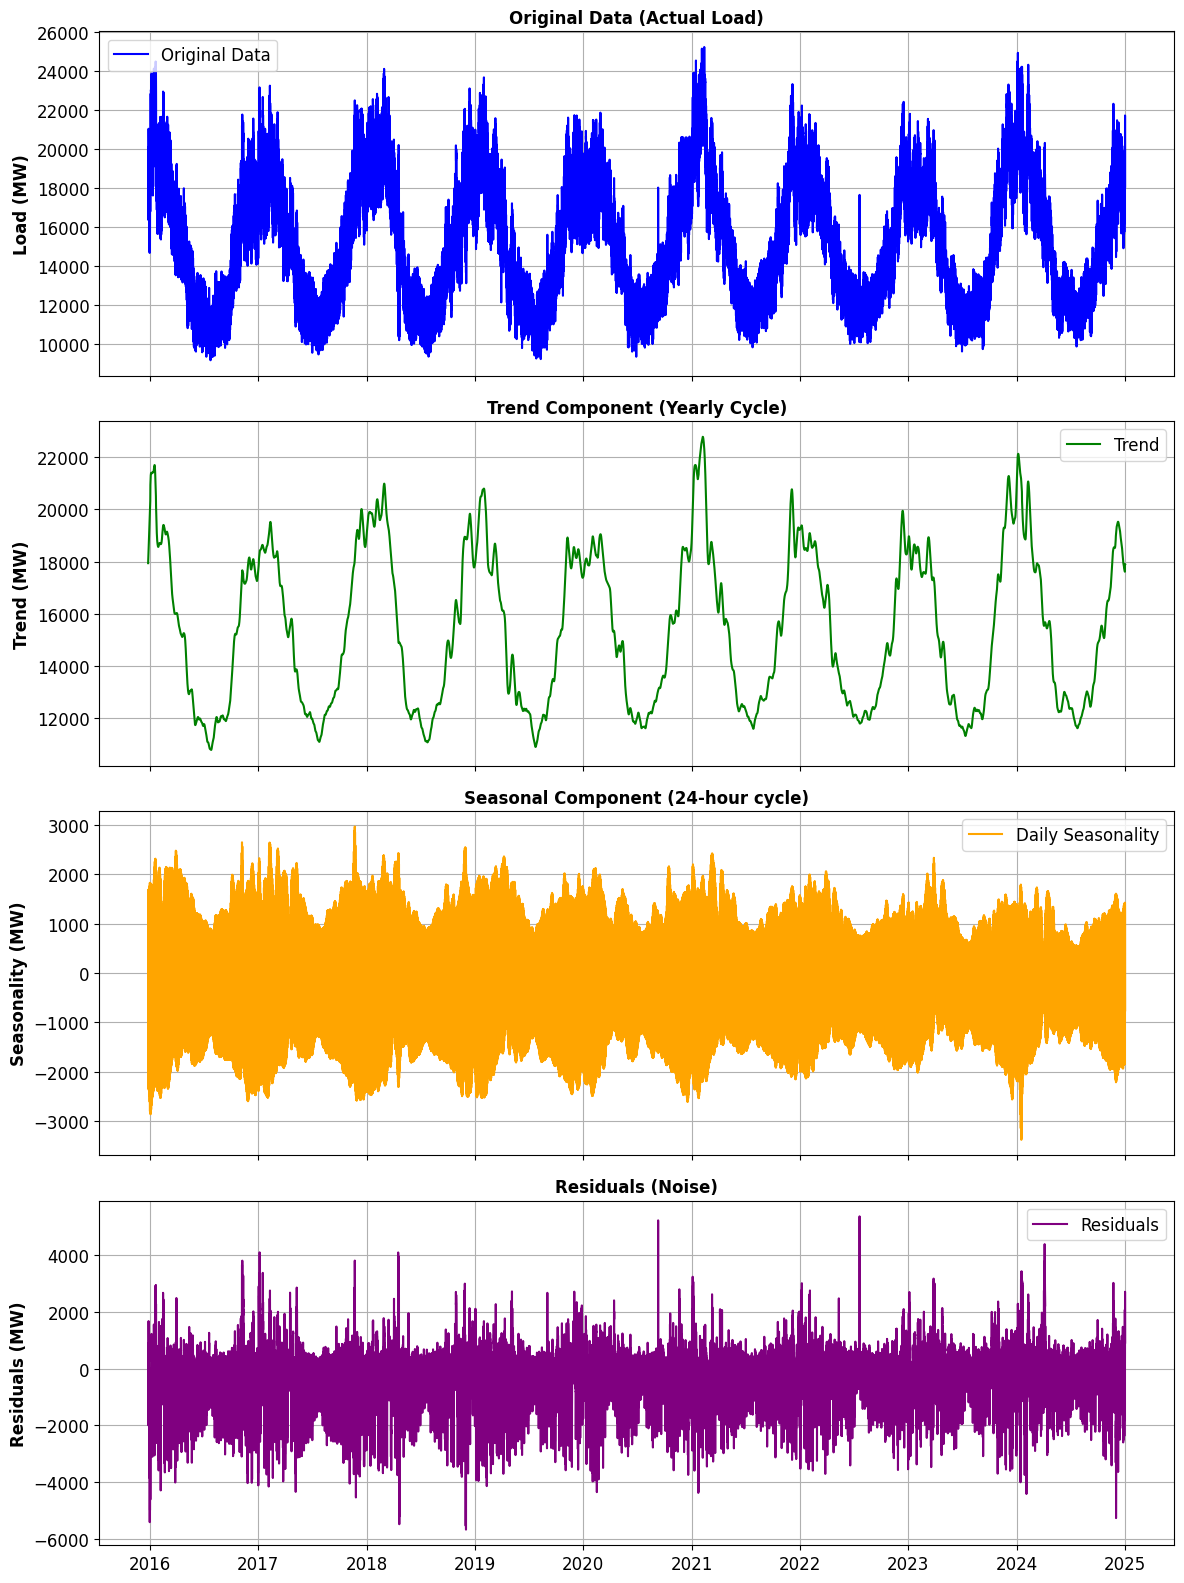


Verification of Decomposition:
Maximum absolute difference: 3.637978807091713e-12
Mean absolute difference: 1.0602064955511957e-13


<Figure size 1000x600 with 0 Axes>

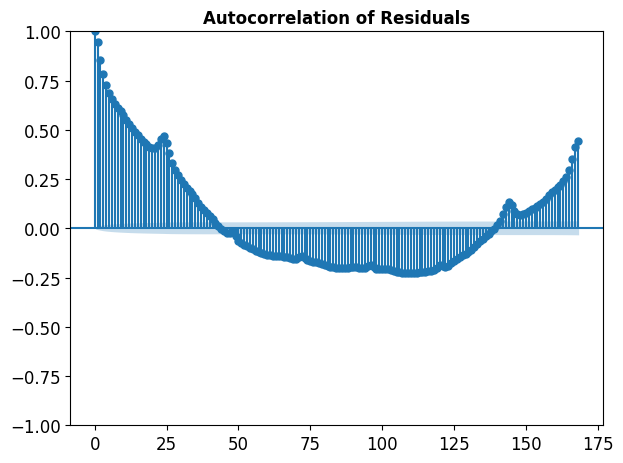


Analyzing residuals for remaining yearly pattern...


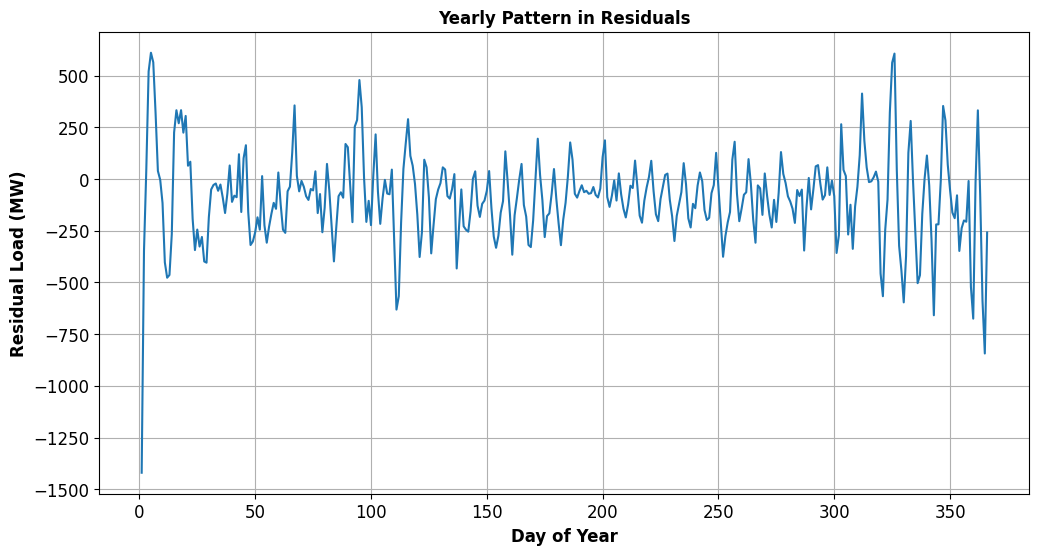

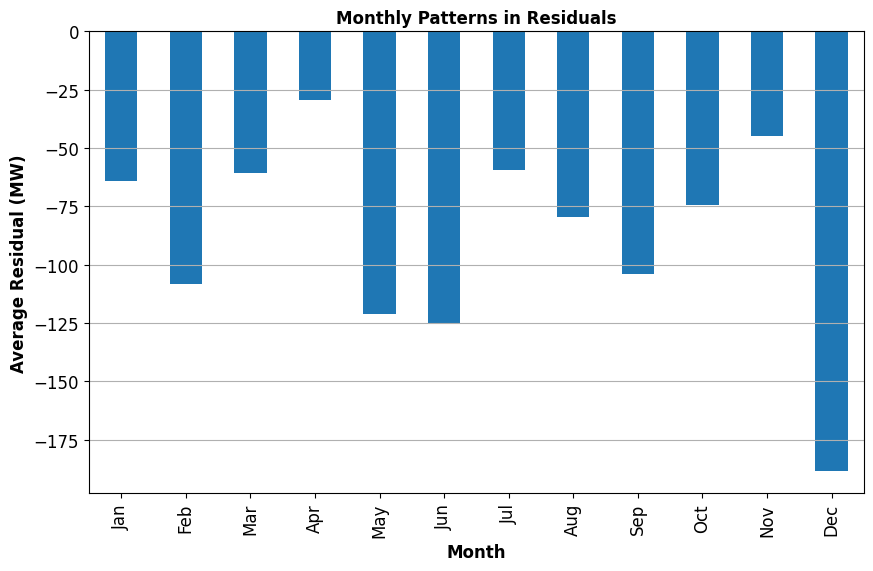

<Figure size 1400x800 with 0 Axes>

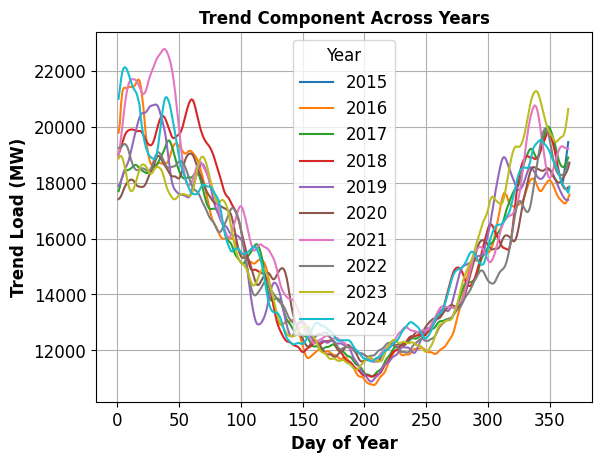


Trying a smoother trend decomposition...


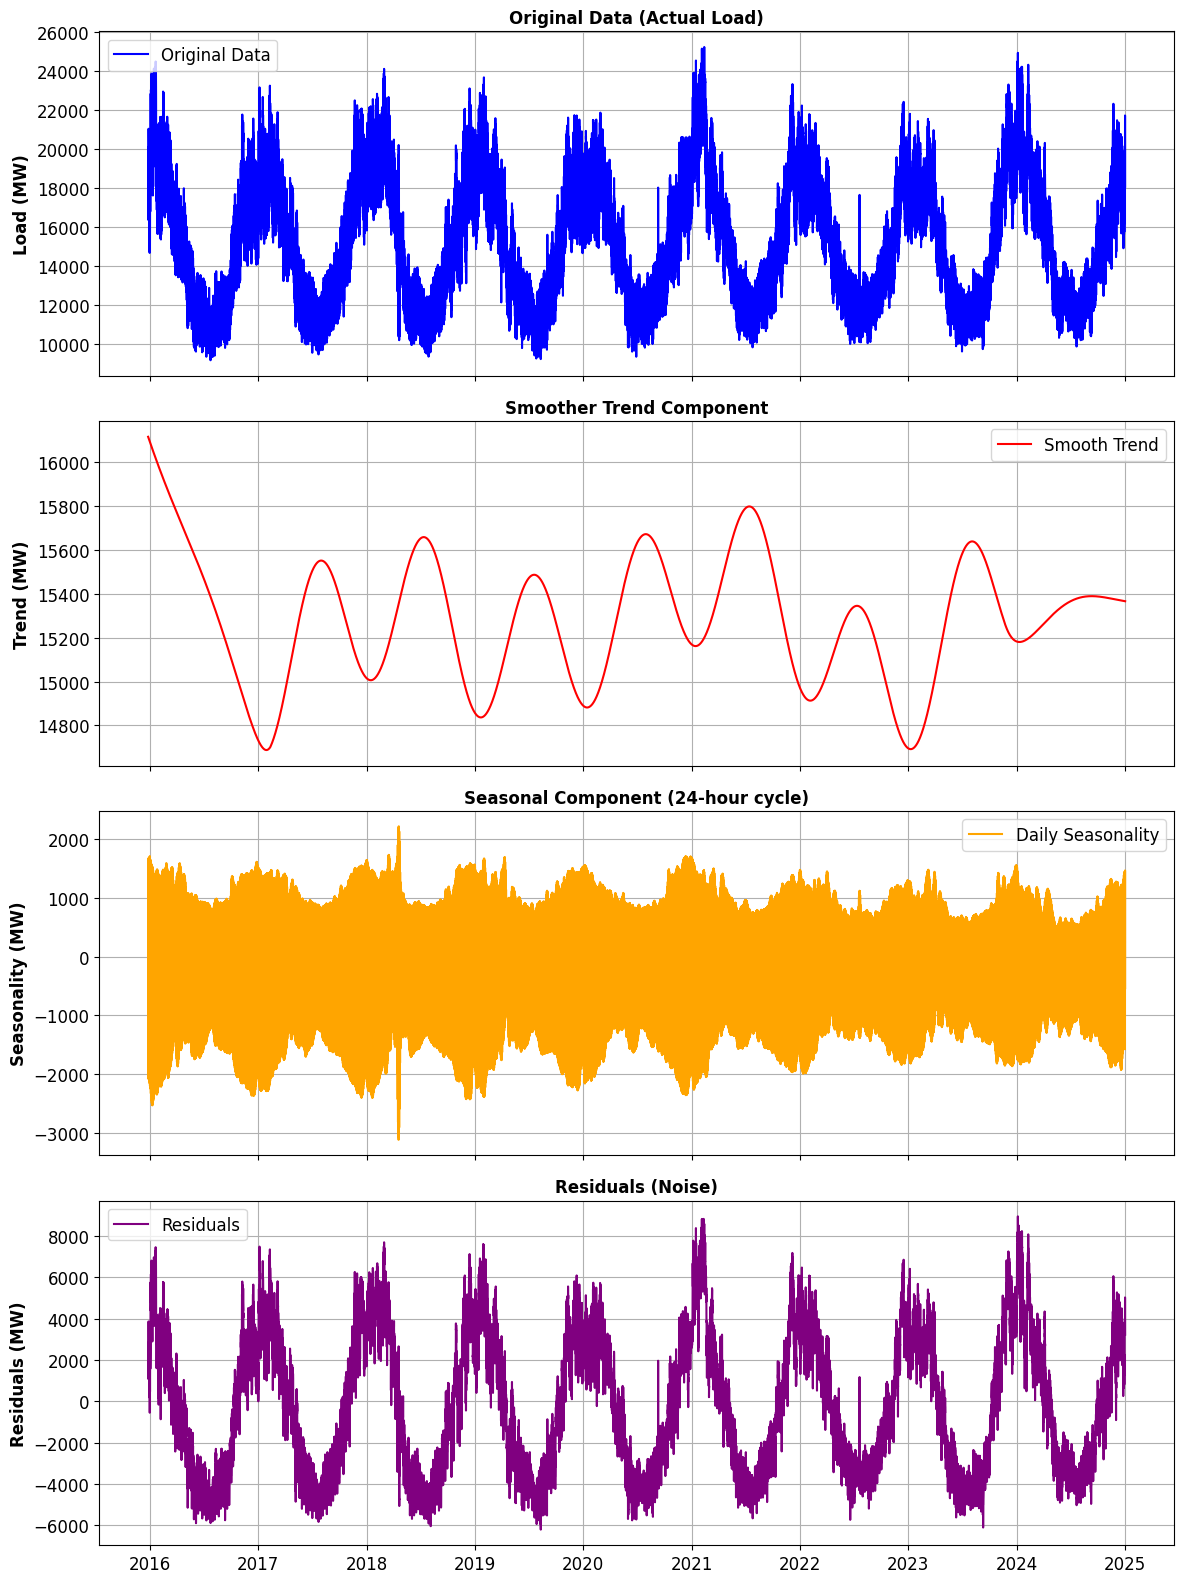

Smoother trend decomposition completed successfully!


In [15]:
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL
import pandas as pd
import numpy as np
from joblib import Memory
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib as mpl

os.makedirs("ReportFigures", exist_ok=True)
mpl.rcParams.update({
    'font.size': 12,
    'axes.titlesize': 12,
    'axes.titleweight': 'bold',
    'axes.labelsize': 12,
    'axes.labelweight': 'bold',
})

# Create a memory cache in the current directory
memory = Memory("./joblib_cache", verbose=0)

# Decorate the STL fit function with the cache
@memory.cache
def cached_stl_fit(series, period, seasonal, trend, seasonal_deg, trend_deg, robust):
    """Cached version of STL fitting to avoid recomputation"""
    stl = STL(
        series,
        period=period,
        seasonal=seasonal,
        trend=trend,
        seasonal_deg=seasonal_deg,
        trend_deg=trend_deg,
        robust=robust
    )
    return stl.fit()

# Ensure the Timestamp is set as the index and sorted
ts = all_data.set_index('Timestamp').sort_index()

# Choose the time series to decompose
series = ts['Actual Load'].dropna()

# Calculate proper trend value (must be odd, >= 3, and > period=24)
n_obs = len(series)
trend_value = max(25, 365)  # Use yearly cycle for smoother trend
if trend_value % 2 == 0:  # Make it odd if it's even
    trend_value += 1

print(f"Using trend value: {trend_value}")
print(f"Series length: {len(series)}")

# Run the cached STL decomposition for daily patterns
print("Running STL decomposition for daily patterns...")
daily_result = cached_stl_fit(
    series,
    period=24,  # Daily seasonality (24 hours)
    seasonal=13,  # Control the smoothness of the seasonal component
    trend=trend_value,  # Yearly trend to capture annual cycles
    seasonal_deg=0,  # Use degree 0 for seasonal to avoid overfitting
    trend_deg=1,      # Linear trend model
    robust=True       # Use robust fitting to handle outliers
)

# Plot improved decomposition
fig, axes = plt.subplots(4, 1, figsize=(12, 16), sharex=True)

# Original Data
axes[0].plot(series, label='Original Data', color='blue', linewidth=1.5)
axes[0].set_title('Original Data (Actual Load)')
axes[0].set_ylabel('Load (MW)')
axes[0].legend()
axes[0].grid(True)

# Trend Component - this should now be smoother
axes[1].plot(daily_result.trend, label='Trend', color='green', linewidth=1.5)
axes[1].set_title('Trend Component (Yearly Cycle)')
axes[1].set_ylabel('Trend (MW)')
axes[1].legend()
axes[1].grid(True)

# Seasonal Component
axes[2].plot(daily_result.seasonal, label='Daily Seasonality', color='orange', linewidth=1.5)
axes[2].set_title('Seasonal Component (24-hour cycle)')
axes[2].set_ylabel('Seasonality (MW)')
axes[2].legend()
axes[2].grid(True)

# Residuals (Noise)
axes[3].plot(daily_result.resid, label='Residuals', color='purple', linewidth=1.5)
axes[3].set_title('Residuals (Noise)')
axes[3].set_ylabel('Residuals (MW)')
axes[3].legend()
axes[3].grid(True)

plt.tight_layout()
plt.savefig("ReportFigures/improved_stl_decomposition.pdf", dpi=300, format="pdf", bbox_inches='tight')

plt.show()

# Verify the decomposition
reconstructed = daily_result.trend + daily_result.seasonal + daily_result.resid
difference = series - reconstructed

print("\nVerification of Decomposition:")
print(f"Maximum absolute difference: {np.abs(difference).max()}")
print(f"Mean absolute difference: {np.abs(difference).mean()}")

# Check autocorrelation of residuals
plt.figure(figsize=(10, 6))
plot_acf(daily_result.resid, lags=24*7)  # Show one week of hourly lags
plt.title('Autocorrelation of Residuals')
plt.tight_layout()
plt.savefig("ReportFigures/residuals_autocorrelation.pdf", dpi=300, format="pdf", bbox_inches='tight')

plt.show()

# Extract yearly pattern from residuals
print("\nAnalyzing residuals for remaining yearly pattern...")

# Method 1: Group residuals by day of year
yearly_cycle = daily_result.resid.groupby(daily_result.resid.index.dayofyear).mean()

plt.figure(figsize=(12, 6))
yearly_cycle.plot()
plt.title('Yearly Pattern in Residuals')
plt.xlabel('Day of Year')
plt.ylabel('Residual Load (MW)')
plt.grid(True)
plt.savefig("ReportFigures/yearly_pattern_in_residuals.pdf", dpi=300, format="pdf", bbox_inches='tight')
plt.show()

# Method 2: Group by month to show monthly patterns
monthly_resid = daily_result.resid.groupby(daily_result.resid.index.month).mean()

plt.figure(figsize=(10, 6))
monthly_resid.plot(kind='bar')
plt.title('Monthly Patterns in Residuals')
plt.xlabel('Month')
plt.ylabel('Average Residual (MW)')
plt.xticks(range(12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(True, axis='y')
plt.savefig("ReportFigures/monthly_residuals.pdf", dpi=300, format="pdf", bbox_inches='tight')
plt.show()

# Method 3: Resampled view of trend over years
years = pd.DataFrame(index=series.index)
years['year'] = series.index.year
years['Load'] = daily_result.trend

yearly_view = years.pivot_table(values='Load', index=years.index.dayofyear, columns=years.index.year)

plt.figure(figsize=(14, 8))
yearly_view.plot()
plt.title('Trend Component Across Years')
plt.xlabel('Day of Year')
plt.ylabel('Trend Load (MW)')
plt.legend(title='Year')
plt.grid(True)
plt.savefig("ReportFigures/trend_by_years.pdf", dpi=300, format="pdf", bbox_inches='tight')
plt.show()


#A simpler model with a much larger trend parameter
try:
    print("\nTrying a smoother trend decomposition...")
    smooth_trend_value = max(5001, n_obs // 4)
    if smooth_trend_value % 2 == 0:
        smooth_trend_value += 1
    
    smoother_result = cached_stl_fit(
        series,
        period=24,  # Daily seasonality
        seasonal=13,  # Same as before
        trend=smooth_trend_value,  # Much larger value for very smooth trend
        seasonal_deg=0,
        trend_deg=1,
        robust=True
    )
    
    # Plot with smoother trend
    fig, axes = plt.subplots(4, 1, figsize=(12, 16), sharex=True)
    
    # Original Data
    axes[0].plot(series, label='Original Data', color='blue', linewidth=1.5)
    axes[0].set_title('Original Data (Actual Load)')
    axes[0].set_ylabel('Load (MW)')
    axes[0].legend()
    axes[0].grid(True)
    
    # Smoother Trend Component
    axes[1].plot(smoother_result.trend, label='Smooth Trend', color='red', linewidth=1.5)
    axes[1].set_title('Smoother Trend Component')
    axes[1].set_ylabel('Trend (MW)')
    axes[1].legend()
    axes[1].grid(True)
    
    # Seasonal Component
    axes[2].plot(smoother_result.seasonal, label='Daily Seasonality', color='orange', linewidth=1.5)
    axes[2].set_title('Seasonal Component (24-hour cycle)')
    axes[2].set_ylabel('Seasonality (MW)')
    axes[2].legend()
    axes[2].grid(True)
    
    # Residuals (Noise)
    axes[3].plot(smoother_result.resid, label='Residuals', color='purple', linewidth=1.5)
    axes[3].set_title('Residuals (Noise)')
    axes[3].set_ylabel('Residuals (MW)')
    axes[3].legend()
    axes[3].grid(True)
    
    plt.tight_layout()
    plt.savefig("ReportFigures/very_smooth_trend_decomposition.pdf", dpi=300, format="pdf", bbox_inches='tight')
    plt.show()
    
    print("Smoother trend decomposition completed successfully!")
except Exception as e:
    print(f"Error in smoother trend decomposition: {e}")


## Methodology


--- Running CV with MinMaxScaler ---
ESN Hyperparam set 1/30: {'input_scaling': np.float64(0.9988962852336699), 'lr': np.float64(0.8581071604484287), 'sr': np.float64(1.3051933359925456), 'units': 1824}
 -> Found in cache, skipping training.
 -> CV MAPE: 0.805% (variance: 0.002162)
ESN Hyperparam set 2/30: {'input_scaling': np.float64(1.5324403790715688), 'lr': np.float64(0.4289578399255525), 'sr': np.float64(0.6099724073998032), 'units': 1582}
 -> Found in cache, skipping training.
 -> CV MAPE: 0.880% (variance: 0.002373)
ESN Hyperparam set 3/30: {'input_scaling': np.float64(2.1788227498598443), 'lr': np.float64(0.5609477599817275), 'sr': np.float64(1.27887983557565), 'units': 1785}
 -> Found in cache, skipping training.
 -> CV MAPE: 0.884% (variance: 0.001948)
ESN Hyperparam set 4/30: {'input_scaling': np.float64(0.23538778966504062), 'lr': np.float64(0.6636989564268011), 'sr': np.float64(1.5324079799173254), 'units': 485}
 -> Found in cache, skipping training.
 -> CV MAPE: 0.856% (

Running Model-0: 63214it [00:11, 5378.86it/s]?, ?it/s]
Running Model-0: 100%|██████████| 1/1 [00:12<00:00, 12.34s/it]


Fitting node Ridge-0...


Running Model-0: 15804it [00:02, 5712.99it/s]         



FINAL ESN on Test => MAE=130.22, RMSE=171.50, MAPE=0.88%, R²=0.9972, trainTime=12.87s


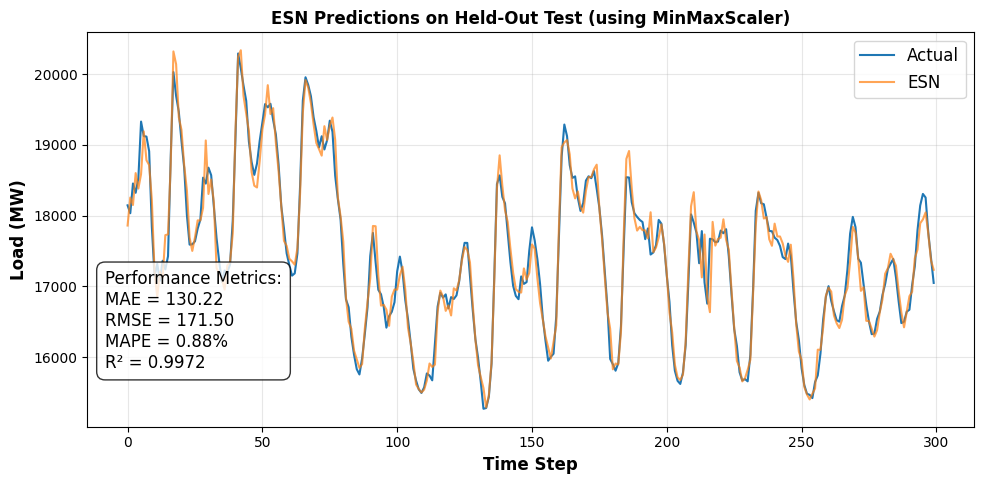

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import joblib
import os

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit, ParameterSampler
from reservoirpy.nodes import Reservoir, Ridge
from scipy.stats import uniform, randint
import matplotlib as mpl

os.makedirs("ReportFigures", exist_ok=True)
mpl.rcParams.update({
    'font.size': 12,
    'axes.titleweight': 'bold',
    'axes.labelweight': 'bold',
    'axes.labelsize': 12,
    'axes.titlesize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10
})


# 1) DATA LOADING & PREP

# Suppose `all_data` has: [Timestamp, Actual Load, ...] + optional Forecast Load
df = all_data.dropna().copy()
df.sort_values('Timestamp', inplace=True)

# Example: Extended time-based, lags, etc.
df['Hour'] = df['Timestamp'].dt.hour
df['Weekday'] = df['Timestamp'].dt.weekday
df['Month'] = df['Timestamp'].dt.month
df['Lag_1H'] = df['Actual Load'].shift(1)
df['Lag_24H'] = df['Actual Load'].shift(24)
df.dropna(inplace=True)

# Let's define a simple single-step target for now
features = [
    'Hour', 'Weekday', 'Month',
    'Lag_1H', 'Lag_24H'
    # Note: We could also use 'Forecast Load' as a feature since it represents 
    # the day-ahead forecast from the power system operator, which provides 
    # valuable information for the model to learn from.
]
X = df[features].values
y = df['Actual Load'].values.reshape(-1,1)

# Single final test holdout
split_idx = int(0.8 * len(X))
df_train = df.iloc[:split_idx]
df_test  = df.iloc[split_idx:]

X_train_all = df_train[features].values
y_train_all = df_train['Actual Load'].values.reshape(-1,1)
X_test_final = df_test[features].values
y_test_final = df_test['Actual Load'].values.reshape(-1,1)

# 2) COMPARE MINMAX AND STANDARD SCALERS
# As per supervisor's suggestion, we'll compare both scaling methods

# MinMaxScaler (original approach)
scaler_X_minmax = MinMaxScaler()
scaler_y_minmax = MinMaxScaler()
X_train_all_minmax = scaler_X_minmax.fit_transform(X_train_all)
y_train_all_minmax = scaler_y_minmax.fit_transform(y_train_all)
X_test_final_minmax = scaler_X_minmax.transform(X_test_final)

# StandardScaler 
scaler_X_std = StandardScaler()
scaler_y_std = StandardScaler()
X_train_all_std = scaler_X_std.fit_transform(X_train_all)
y_train_all_std = scaler_y_std.fit_transform(y_train_all)
X_test_final_std = scaler_X_std.transform(X_test_final)

# Visualization to compare the distributions
plt.figure(figsize=(15, 10))
for i, feature_name in enumerate(features):
    plt.subplot(3, 2, i+1)
    plt.hist(X_train_all_minmax[:, i], alpha=0.5, bins=30, label='MinMax Scaled')
    plt.hist(X_train_all_std[:, i], alpha=0.5, bins=30, label='Standard Scaled')
    plt.title(f'Feature: {feature_name}')
    plt.legend()
plt.tight_layout()
#plt.savefig('plots/scaling_comparison.png', dpi=300)
plt.close()

# For the rest of the code, we'll try both scalers and compare results
# Default to MinMax for now
X_train_all_scaled = X_train_all_minmax
y_train_all_scaled = y_train_all_minmax
X_test_final_scaled = X_test_final_minmax
scaler_X = scaler_X_minmax
scaler_y = scaler_y_minmax

# 3) CROSS-VALIDATION + RANDOM SEARCH for ESN with improved parameter ranges

n_splits = 3
tscv = TimeSeriesSplit(n_splits=n_splits)


# Explanation for each parameter:
# - 'units': Number of neurons in the reservoir (larger = more capacity but risk of overfitting)
# - 'sr': Spectral radius, controls echo state property (stability of reservoir)

# - 'lr': Leaking rate, controls memory of the system (lower = longer memory)
# - 'input_scaling': Scales input signal before entering reservoir (affects nonlinearity)

# Expanded parameter distribution for ESN
param_dist = {
    'units': randint(100, 2000),        # Expanded from [200, 1500] to [100, 2000]
    'sr': uniform(0.5, 1.1),            # Expanded from [0.8, 1.6] to [0.5, 1.6]
    'lr': uniform(0.05, 0.85),          # Expanded from [0.1, 0.5] to [0.05, 0.9]
    'input_scaling': uniform(0.1, 2.4)  # Expanded from [0.5, 2.0] to [0.1, 2.5]
}
n_iter = 30  # Increased from 20 to 30 random combinations
param_list = list(ParameterSampler(param_dist, n_iter=n_iter, random_state=42))

# We'll store the crossval results in a joblib cache
cache_file = 'esn_cv_results.pkl'
if os.path.exists(cache_file):
    # Load existing cache
    with open(cache_file, 'rb') as f:
        cv_cache = joblib.load(f)
else:
    cv_cache = {}

def train_esn_on_fold(X_train_fold, y_train_fold, X_val_fold, y_val_fold, params, 
                      use_standardscaler=False):
    """
    Train an ESN with specified hyperparams on a single fold.
    Return MAPE or some chosen error.
    
    Parameters:
        X_train_fold, y_train_fold: Training data
        X_val_fold, y_val_fold: Validation data
        params: ESN hyperparameters
        use_standardscaler: Whether to use StandardScaler (True) or MinMaxScaler (False)
    """
    # Scale fold
    if use_standardscaler:
        scalerX_fold = StandardScaler()
        scalerY_fold = StandardScaler()
    else:
        scalerX_fold = MinMaxScaler()
        scalerY_fold = MinMaxScaler()
        
    X_train_fold_scaled = scalerX_fold.fit_transform(X_train_fold)
    y_train_fold_scaled = scalerY_fold.fit_transform(y_train_fold)
    X_val_fold_scaled = scalerX_fold.transform(X_val_fold)
    # y_val_fold_scaled = scalerY_fold.transform(y_val_fold) # only if needed for internal metrics

    # Build ESN
    reservoir = Reservoir(
        units=params['units'],
        sr=params['sr'],
        lr=params['lr'],
        input_scaling=params['input_scaling'],
        seed=42
    )
    readout = Ridge(ridge=1e-6)
    esn_model = reservoir >> readout

    esn_model.fit(X_train_fold_scaled, y_train_fold_scaled)
    y_pred_fold_scaled = esn_model.run(X_val_fold_scaled)
    y_pred_fold = scalerY_fold.inverse_transform(y_pred_fold_scaled)

    mae = mean_absolute_error(y_val_fold, y_pred_fold)
    rmse = np.sqrt(mean_squared_error(y_val_fold, y_pred_fold))
    mape = np.mean(np.abs((y_val_fold - y_pred_fold)/y_val_fold)) * 100

    return mae, rmse, mape

# Run Cross-validation for both MinMaxScaler and StandardScaler
scaling_methods = [
    {"name": "MinMaxScaler", "use_std": False},
    {"name": "StandardScaler", "use_std": True}
]

best_results = {}

for scaling in scaling_methods:
    scaler_name = scaling["name"]
    use_std = scaling["use_std"]
    
    print(f"\n--- Running CV with {scaler_name} ---")
    
    cv_results = []
    best_mape = float('inf')
    best_params = None
    fold_mapes_by_param = {}  # Store MAPE for each fold to compute variance

    for idx, params in enumerate(param_list):
        print(f"ESN Hyperparam set {idx+1}/{len(param_list)}: {params}")

        # We'll create a cache key that includes scaler information
        cache_key = (tuple(sorted(params.items())), scaler_name)

        if cache_key in cv_cache:
            print(" -> Found in cache, skipping training.")
            mean_mape = cv_cache[cache_key]['mean_mape']
            fold_mapes = cv_cache[cache_key]['fold_mapes']
        else:
            # Perform cross val over n_splits
            fold_mapes = []
            for fold_idx, (train_idx, val_idx) in enumerate(tscv.split(X_train_all)):
                # Build folds
                X_train_fold = X_train_all[train_idx]
                y_train_fold = y_train_all[train_idx].reshape(-1,1)
                X_val_fold = X_train_all[val_idx]
                y_val_fold = y_train_all[val_idx].reshape(-1,1)

                # Train on this fold
                mae_, rmse_, mape_ = train_esn_on_fold(
                    X_train_fold, y_train_fold, X_val_fold, y_val_fold, params, use_std
                )
                fold_mapes.append(mape_)

            mean_mape = np.mean(fold_mapes)
            # Store in cache
            cv_cache[cache_key] = {'mean_mape': mean_mape, 'fold_mapes': fold_mapes}

        # Calculate variance of MAPE across folds (as suggested by supervisor)
        mape_variance = np.var(fold_mapes)
        fold_mapes_by_param[idx] = fold_mapes
        
        if mean_mape < best_mape:
            best_mape = mean_mape
            best_params = params

        print(f" -> CV MAPE: {mean_mape:.3f}% (variance: {mape_variance:.6f})")

        # Gather results with variance information
        cv_results.append({
            'params': params,
            'mean_mape': mean_mape,
            'mape_variance': mape_variance,
            'fold_mapes': fold_mapes
        })

    # Save the updated cache
    with open(cache_file, 'wb') as f:
        joblib.dump(cv_cache, f)

    # Sort by mean MAPE
    cv_results_df = pd.DataFrame(cv_results).sort_values('mean_mape')
    print(f"\nCV RESULTS with {scaler_name}:\n", cv_results_df[['mean_mape', 'mape_variance']].head(10))
    print(f"\nBEST PARAMS with {scaler_name}: {best_params}, MAPE={best_mape:.3f}%")
    
    # Store the best result for this scaling method
    best_results[scaler_name] = {
        "params": best_params,
        "mape": best_mape,
        "cv_results": cv_results
    }

# Determine the overall best scaling method
best_scaling = "MinMaxScaler" if best_results["MinMaxScaler"]["mape"] <= best_results["StandardScaler"]["mape"] else "StandardScaler"
print(f"\n=== BEST OVERALL SCALING METHOD: {best_scaling} ===")
best_params = best_results[best_scaling]["params"]
if best_scaling == "StandardScaler":
    X_train_all_scaled = X_train_all_std
    y_train_all_scaled = y_train_all_std
    X_test_final_scaled = X_test_final_std
    scaler_X = scaler_X_std
    scaler_y = scaler_y_std

# 4) RETRAIN BEST ESN on Full Training Data + Evaluate on Held-out
# Scale full training using the best scaling method
if best_scaling == "StandardScaler":
    scalerX_full = StandardScaler()
    scalerY_full = StandardScaler()
else:
    scalerX_full = MinMaxScaler()
    scalerY_full = MinMaxScaler()

X_train_all_scaled = scalerX_full.fit_transform(X_train_all)
y_train_all_scaled = scalerY_full.fit_transform(y_train_all)
X_test_final_scaled = scalerX_full.transform(X_test_final)

# Build ESN with best_params
reservoir = Reservoir(
    units=int(best_params['units']),
    sr=float(best_params['sr']),
    lr=float(best_params['lr']),
    input_scaling=float(best_params['input_scaling']),
    seed=42
)
readout = Ridge(ridge=1e-6)
best_esn = reservoir >> readout

start_time = time.time()
best_esn.fit(X_train_all_scaled, y_train_all_scaled)
train_time = time.time() - start_time

y_pred_scaled = best_esn.run(X_test_final_scaled)
y_pred_final = scalerY_full.inverse_transform(y_pred_scaled)

mae_final = mean_absolute_error(y_test_final, y_pred_final)
rmse_final = np.sqrt(mean_squared_error(y_test_final, y_pred_final))
mape_final = np.mean(np.abs((y_test_final - y_pred_final)/y_test_final)) * 100
r2_final = 1 - np.sum((y_test_final - y_pred_final) ** 2) / np.sum((y_test_final - np.mean(y_test_final)) ** 2)

print(f"\nFINAL ESN on Test => MAE={mae_final:.2f}, RMSE={rmse_final:.2f}, MAPE={mape_final:.2f}%, R²={r2_final:.4f}, trainTime={train_time:.2f}s")

# 5) PLOT PREDICTIONS with improved annotations as per supervisor feedback
max_plot = 300
plt.figure(figsize=(10,5))
plt.plot(y_test_final[:max_plot], label='Actual', linewidth=1.5)
plt.plot(y_pred_final[:max_plot], label='ESN', alpha=0.7)

# Adding an annotation with performance metrics directly on the plot
performance_text = (f"Performance Metrics:\n"
                   f"MAE = {mae_final:.2f}\n"
                   f"RMSE = {rmse_final:.2f}\n"
                   f"MAPE = {mape_final:.2f}%\n"
                   f"R² = {r2_final:.4f}")
                   
plt.annotate(performance_text, xy=(0.02, 0.15), xycoords='axes fraction', 
             bbox=dict(boxstyle="round,pad=0.5", fc="white", alpha=0.8))

plt.title(f'ESN Predictions on Held-Out Test (using {best_scaling})')
plt.xlabel('Time Step')
plt.ylabel('Load (MW)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('ReportFigures/final_esn_predictions.pdf', format='pdf', bbox_inches='tight')
plt.show()




### Feature Selection and Scaling Strategy for ESN Forecasting

In our Echo State Network (ESN) forecasting pipeline, we combined meaningful **calendar features** and **historical lags** to build a compact yet informative input representation. Here's an overview of our reasoning and experimentation:

---

#### Selected Features:

| Feature | Description | Purpose |
|---------|-------------|---------|
| `Hour` | Hour of the day (0–23) | Captures **daily consumption cycles** (e.g., peak morning hours) |
| `Weekday` | Day of the week (0 = Monday) | Captures **weekly behavior**, like weekend dips |
| `Month` | Month of the year (1–12) | Captures **seasonality** (e.g., higher usage in winter) |
| `Lag_1H` | Actual Load 1 hour ago | Adds **short-term memory**, reflecting recent system state |
| `Lag_24H` | Actual Load 24 hours ago | Captures **daily periodicity**, helping predict repeated usage patterns |

These features help the model leverage both **temporal structure** and **recent load dynamics**, which are crucial in electricity demand forecasting.

---

### Forecast Load: Public but Not Yet Included

Although the dataset includes a **day-ahead forecast** (`Forecast Load`) published by the energy operator, we did **not** use it in this version of the model.

However, this feature is **public and known in advance**, meaning it could easily be added as an **input feature** in future iterations to enhance predictive performance. Incorporating it would allow the ESN to combine **expert-based knowledge** with **historical trends**.

---

### Input Scaling: Why We Chose MinMaxScaler

To normalize the data and improve model convergence, we tested both:

- **MinMaxScaler** (scales features between 0 and 1)
- **StandardScaler** (scales features to mean = 0, std = 1)

---

#### Scaling

- ESNs are sensitive to input magnitudes since input scaling directly affects how signals propagate through the reservoir.
- Proper scaling ensures **numerical stability** and **faster convergence**.

---

#### Experimental Results:

- Despite the presence of **some outliers** in the data, we found that:
  - **MinMaxScaler consistently outperformed StandardScaler** in terms of both **mean absolute percentage error (MAPE)** and **training stability**.
  - StandardScaler, in theory, could handle outliers better, but in our case, the outliers were **realistic and sparse**, so clipping via MinMax was more beneficial.

Thus, **MinMaxScaler was chosen as the default** for our final ESN model training and testing pipeline.

---

### Model Summary

- **Inputs**: `Hour`, `Weekday`, `Month`, `Lag_1H`, `Lag_24H`  
- **Output**: Next-step prediction of `Actual Load`  
- **Scaler Used**: `MinMaxScaler`, based on empirical performance  
- **Alternative Tried**: `StandardScaler`, but with slightly worse results  

This setup provides a strong foundation while leaving room for improvements, such as **incorporating forecast load**, **temperature data**, or **grid events** in future versions.

---

### Runtime and Experimentation Feasibility

Running the ESN pipeline, including **cross-validation and hyperparameter tuning**, can be computationally intensive. Here's a summary of the observed runtimes:


#### Runtime Breakdown:

| Stage                          | Time (Initial Run) | Time (With Cache) |
|-------------------------------|---------------------|--------------------|
| Cross-Validation (30 configs × 3 folds) | ~30–40 minutes       | Cached            |
| Final model retraining & evaluation    | ~2–3 minutes         | Same              |
| Total runtime                  | **~35–45 minutes**   | **~5 minutes**     |

---

#### Caching Strategy:
To speed up repeated runs, we implemented **Joblib caching** for:
- Hyperparameter evaluation results per configuration and scaler.
- Fold-wise MAPE scores and variance tracking.

As a result, **subsequent executions of the script (with the same parameter space)** become **significantly faster**, reducing compute time from **~40 minutes to ~5 minutes**.

---

In [17]:
# 6) EXTENDED LSTM and CNN+LSTM in PyTorch with Joblib Parallel + Caching
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import r2_score
from scipy.stats import ttest_rel
import numpy as np
import itertools
import random
import copy
import matplotlib.pyplot as plt

from joblib import Parallel, delayed, Memory

# Create a directory for caching (if it doesn't exist, joblib will create it)
memory = Memory(location="./joblib_cache", verbose=1)

# We assume you already have:
# - X_train_all_scaled, y_train_all_scaled -> your scaled training data (numpy)
# - X_test_final_scaled                   -> your scaled test data (numpy)
# - y_test_final                          -> your unscaled test labels for final metrics (numpy)
# - scalerY_full                          -> your fitted MinMaxScaler for 'y'
# - best_esn predictions in y_pred_final  -> your ESN predictions on the test set (numpy)

# 6.1) Prepare Data for PyTorch
X_train_torch_base = torch.from_numpy(X_train_all_scaled).float()
y_train_torch_base = torch.from_numpy(y_train_all_scaled).float()
X_test_torch = torch.from_numpy(X_test_final_scaled).float()

def reshape_for_lstm(X_torch):
    # e.g. (N, num_features) => (N, 1, num_features)
    return X_torch.unsqueeze(1)

# 6.2) Model Classes (LSTMModel, CNNLSTMModel)
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=1, output_dim=1):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        lstm_out, (h_n, c_n) = self.lstm(x)
        last_out = lstm_out[:, -1, :]
        out = self.fc(last_out)
        return out

class CNNLSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, output_dim=1):
        super(CNNLSTMModel, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=input_dim, out_channels=32, kernel_size=1)
        self.pool = nn.MaxPool1d(kernel_size=1)
        self.lstm = nn.LSTM(32, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # x shape: (batch_size, seq_len=1, input_dim)
        x = x.transpose(1, 2)  # => (batch, input_dim, seq_len=1)
        x = self.conv1(x)      # => (batch, 32, seq_len=1)
        x = self.pool(x)       # => (batch, 32, seq_len=1)
        x = x.transpose(1, 2)  # => (batch, seq_len=1, 32)
        lstm_out, _ = self.lstm(x)
        last_out = lstm_out[:, -1, :]
        out = self.fc(last_out)
        return out

# 6.3) CACHED Helper Function: Train/Eval
@memory.cache  # joblib cache decorator
def train_and_evaluate_model(
    model_type='lstm',        # 'lstm' or 'cnn'
    hidden_dim=64,
    num_layers=1,
    learning_rate=1e-3,
    epochs=10,
    batch_size=64,
    seed=42
):
    """
    Trains either LSTM or CNN+LSTM on a single train set,
    returns final predictions on the test set and metrics.
    Caching is applied: if the same (model_type, hidden_dim, num_layers, learning_rate, epochs, batch_size, seed)
    is called again, joblib will skip re-computing and load from cache.
    """

    # Set random seeds for reproducibility
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

    # Prepare data
    X_train_torch = reshape_for_lstm(X_train_torch_base)
    y_train_torch = y_train_torch_base

    # DataLoader
    train_dataset = torch.utils.data.TensorDataset(X_train_torch, y_train_torch)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    input_dim = X_train_all_scaled.shape[1]

    # Build model
    if model_type == 'lstm':
        model = LSTMModel(input_dim=input_dim, hidden_dim=hidden_dim, num_layers=num_layers, output_dim=1)
    else:
        model = CNNLSTMModel(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=1)

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Train loop
    model.train()
    for epoch_i in range(epochs):
        total_loss = 0.0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            y_pred = model(X_batch)
            if y_batch.dim() == 1:
                y_batch = y_batch.unsqueeze(1)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * X_batch.size(0)
        # epoch_loss = total_loss / len(train_loader.dataset)
        # (Optional print) print(f"[{model_type.upper()}] Epoch {epoch_i+1}/{epochs}, Loss={epoch_loss:.6f}")

    # Evaluate on test
    model.eval()
    with torch.no_grad():
        y_pred_test = model(reshape_for_lstm(X_test_torch))
    y_pred_test_np = y_pred_test.detach().numpy()

    # Inverse transform
    y_pred_unscaled = scalerY_full.inverse_transform(y_pred_test_np)

    # Compute errors
    mae = np.mean(np.abs(y_test_final - y_pred_unscaled))
    rmse = np.sqrt(np.mean((y_test_final - y_pred_unscaled)**2))
    mape = np.mean(np.abs((y_test_final - y_pred_unscaled) / y_test_final)) * 100
    r2 = r2_score(y_test_final, y_pred_unscaled)

    metrics = {
        'mae': mae,
        'rmse': rmse,
        'mape': mape,
        'r2': r2,
        'preds': y_pred_unscaled
    }
    return metrics

# 6.4) Expanded Hyperparam Search + Repeated Seeds with joblib Parallel
import math

# Replace the original parameter grids with these expanded ones
lstm_param_grid = {
    'hidden_dim': [16, 32, 64, 128],        # Added 16 and 128
    'num_layers': [1, 2, 3],                # Added 3
    'learning_rate': [0.01, 0.003, 0.001, 0.0003],  # Added 0.01 and 0.003
    'epochs': [10],
    'batch_size': [64],
}

cnn_param_grid = {
    'hidden_dim': [16, 32, 64, 128],        # Added 16 and 128
    'learning_rate': [0.01, 0.003, 0.001, 0.0003],  # Added 0.01 and 0.003
    'epochs': [10],
    'batch_size': [64],
}

def param_grid_to_list(param_grid):
    keys = list(param_grid.keys())
    combos = []
    for values in itertools.product(*[param_grid[k] for k in keys]):
        combos.append(dict(zip(keys, values)))
    return combos

lstm_params_list = param_grid_to_list(lstm_param_grid)
cnn_params_list = param_grid_to_list(cnn_param_grid)

repetition_seeds = [42, 43, 44]

print("\n--- LSTM HYPERPARAM SEARCH (Parallel) ---")

def run_lstm_config(pset):
    # We'll average metrics over repeated seeds
    mapes, maes, rmses, r2s = [], [], [], []
    for sd in repetition_seeds:
        metrics = train_and_evaluate_model(
            model_type='lstm',
            hidden_dim=pset['hidden_dim'],
            num_layers=pset.get('num_layers', 1),
            learning_rate=pset['learning_rate'],
            epochs=pset['epochs'],
            batch_size=pset['batch_size'],
            seed=sd
        )
        mapes.append(metrics['mape'])
        maes.append(metrics['mae'])
        rmses.append(metrics['rmse'])
        r2s.append(metrics['r2'])
    mean_mape = np.mean(mapes)
    mean_mae  = np.mean(maes)
    mean_rmse = np.mean(rmses)
    mean_r2   = np.mean(r2s)
    return pset, (mean_mape, mean_mae, mean_rmse, mean_r2)

lstm_results = Parallel(n_jobs=-1, verbose=5)(
    delayed(run_lstm_config)(pset) for pset in lstm_params_list
)

best_lstm_mape = float('inf')
best_lstm_params = None
best_lstm_metrics = None

for (pset, (mean_mape, mean_mae, mean_rmse, mean_r2)) in lstm_results:
    print(f"Params={pset}, Seeds avg => MAPE={mean_mape:.3f}%, MAE={mean_mae:.2f}, RMSE={mean_rmse:.2f}, R2={mean_r2:.4f}")
    if mean_mape < best_lstm_mape:
        best_lstm_mape = mean_mape
        best_lstm_params = copy.deepcopy(pset)
        best_lstm_metrics = {
            'mae': mean_mae, 'rmse': mean_rmse, 'mape': mean_mape, 'r2': mean_r2
        }

print("\nBEST LSTM PARAMS:", best_lstm_params, "=>", best_lstm_metrics)

print("\n--- CNN+LSTM HYPERPARAM SEARCH (Parallel) ---")

def run_cnn_config(pset):
    mapes, maes, rmses, r2s = [], [], [], []
    for sd in repetition_seeds:
        metrics = train_and_evaluate_model(
            model_type='cnn',
            hidden_dim=pset['hidden_dim'],
            learning_rate=pset['learning_rate'],
            epochs=pset['epochs'],
            batch_size=pset['batch_size'],
            seed=sd
        )
        mapes.append(metrics['mape'])
        maes.append(metrics['mae'])
        rmses.append(metrics['rmse'])
        r2s.append(metrics['r2'])
    mean_mape = np.mean(mapes)
    mean_mae  = np.mean(maes)
    mean_rmse = np.mean(rmses)
    mean_r2   = np.mean(r2s)
    return pset, (mean_mape, mean_mae, mean_rmse, mean_r2)

cnn_results = Parallel(n_jobs=-1, verbose=5)(
    delayed(run_cnn_config)(pset) for pset in cnn_params_list
)

best_cnn_mape = float('inf')
best_cnn_params = None
best_cnn_metrics = None

for (pset, (mean_mape, mean_mae, mean_rmse, mean_r2)) in cnn_results:
    print(f"Params={pset}, Seeds avg => MAPE={mean_mape:.3f}%, MAE={mean_mae:.2f}, RMSE={mean_rmse:.2f}, R2={mean_r2:.4f}")
    if mean_mape < best_cnn_mape:
        best_cnn_mape = mean_mape
        best_cnn_params = copy.deepcopy(pset)
        best_cnn_metrics = {
            'mae': mean_mae, 'rmse': mean_rmse, 'mape': mean_mape, 'r2': mean_r2
        }

print("\nBEST CNN+LSTM PARAMS:", best_cnn_params, "=>", best_cnn_metrics)


# 6.5) Retrain LSTM & CNN+LSTM + multiple seeds => final preds
print("\n--- Retraining FINAL LSTM with best params, repeated seeds ---")
lstm_final_preds_list = []
for sd in repetition_seeds:
    final_metrics = train_and_evaluate_model(
        model_type='lstm',
        hidden_dim=best_lstm_params['hidden_dim'],
        num_layers=best_lstm_params.get('num_layers', 1),
        learning_rate=best_lstm_params['learning_rate'],
        epochs=best_lstm_params['epochs'],
        batch_size=best_lstm_params['batch_size'],
        seed=sd
    )
    lstm_final_preds_list.append(final_metrics['preds'])
y_pred_lstm_final = lstm_final_preds_list[-1]  # or average across seeds if desired

print("\n--- Retraining FINAL CNN+LSTM with best params, repeated seeds ---")
cnn_final_preds_list = []
for sd in repetition_seeds:
    final_metrics = train_and_evaluate_model(
        model_type='cnn',
        hidden_dim=best_cnn_params['hidden_dim'],
        learning_rate=best_cnn_params['learning_rate'],
        epochs=best_cnn_params['epochs'],
        batch_size=best_cnn_params['batch_size'],
        seed=sd
    )
    cnn_final_preds_list.append(final_metrics['preds'])
y_pred_cnnlstm_final = cnn_final_preds_list[-1]


# 6.6)Metrics + T-test vs. ESN
def compute_metrics(y_true, y_pred):
    mae = np.mean(np.abs(y_true - y_pred))
    rmse = np.sqrt(np.mean((y_true - y_pred)**2))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    r2 = r2_score(y_true, y_pred)
    return mae, rmse, mape, r2

# Suppose your ESN predictions are in y_pred_final
mae_esn, rmse_esn, mape_esn, r2_esn = compute_metrics(y_test_final, y_pred_final)
mae_lstmF, rmse_lstmF, mape_lstmF, r2_lstmF = compute_metrics(y_test_final, y_pred_lstm_final)
mae_cnnF, rmse_cnnF, mape_cnnF, r2_cnnF = compute_metrics(y_test_final, y_pred_cnnlstm_final)

print("\nFINAL COMPARISON:")
print(f"ESN     => MAE={mae_esn:.2f},   RMSE={rmse_esn:.2f},   MAPE={mape_esn:.2f}%,  R2={r2_esn:.4f}")
print(f"LSTM    => MAE={mae_lstmF:.2f}, RMSE={rmse_lstmF:.2f}, MAPE={mape_lstmF:.2f}%,R2={r2_lstmF:.4f}")
print(f"CNN+LSTM=> MAE={mae_cnnF:.2f},  RMSE={rmse_cnnF:.2f},  MAPE={mape_cnnF:.2f}%, R2={r2_cnnF:.4f}")

from scipy.stats import ttest_rel

# Compare ESN vs LSTM
esn_errors  = np.abs(y_test_final - y_pred_final).flatten()
lstm_errors = np.abs(y_test_final - y_pred_lstm_final).flatten()
t_stat_lstm, p_val_lstm = ttest_rel(esn_errors, lstm_errors)
print(f"\nPaired t-test ESN vs. LSTM: t={t_stat_lstm:.3f}, p-value={p_val_lstm:.4f}")

# Compare ESN vs CNN+LSTM
cnn_errors = np.abs(y_test_final - y_pred_cnnlstm_final).flatten()
t_stat_cnn, p_val_cnn = ttest_rel(esn_errors, cnn_errors)
print(f"Paired t-test ESN vs. CNN+LSTM: t={t_stat_cnn:.3f}, p-value={p_val_cnn:.4f}")



--- LSTM HYPERPARAM SEARCH (Parallel) ---


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  48 | elapsed:    2.9s remaining:    2.2s
[Parallel(n_jobs=-1)]: Done  37 out of  48 | elapsed:    2.9s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:    3.0s finished


Params={'hidden_dim': 16, 'num_layers': 1, 'learning_rate': 0.01, 'epochs': 10, 'batch_size': 64}, Seeds avg => MAPE=1.460%, MAE=221.63, RMSE=290.39, R2=0.9918
Params={'hidden_dim': 16, 'num_layers': 1, 'learning_rate': 0.003, 'epochs': 10, 'batch_size': 64}, Seeds avg => MAPE=1.528%, MAE=233.45, RMSE=311.42, R2=0.9906
Params={'hidden_dim': 16, 'num_layers': 1, 'learning_rate': 0.001, 'epochs': 10, 'batch_size': 64}, Seeds avg => MAPE=1.458%, MAE=219.91, RMSE=296.46, R2=0.9915
Params={'hidden_dim': 16, 'num_layers': 1, 'learning_rate': 0.0003, 'epochs': 10, 'batch_size': 64}, Seeds avg => MAPE=1.472%, MAE=222.67, RMSE=303.82, R2=0.9911
Params={'hidden_dim': 16, 'num_layers': 2, 'learning_rate': 0.01, 'epochs': 10, 'batch_size': 64}, Seeds avg => MAPE=1.286%, MAE=196.09, RMSE=256.60, R2=0.9936
Params={'hidden_dim': 16, 'num_layers': 2, 'learning_rate': 0.003, 'epochs': 10, 'batch_size': 64}, Seeds avg => MAPE=1.436%, MAE=216.63, RMSE=285.23, R2=0.9921
Params={'hidden_dim': 16, 'num_laye

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished


Params={'hidden_dim': 16, 'learning_rate': 0.01, 'epochs': 10, 'batch_size': 64}, Seeds avg => MAPE=1.194%, MAE=183.85, RMSE=239.60, R2=0.9943
Params={'hidden_dim': 16, 'learning_rate': 0.003, 'epochs': 10, 'batch_size': 64}, Seeds avg => MAPE=1.161%, MAE=176.42, RMSE=231.25, R2=0.9948
Params={'hidden_dim': 16, 'learning_rate': 0.001, 'epochs': 10, 'batch_size': 64}, Seeds avg => MAPE=1.433%, MAE=216.55, RMSE=282.10, R2=0.9922
Params={'hidden_dim': 16, 'learning_rate': 0.0003, 'epochs': 10, 'batch_size': 64}, Seeds avg => MAPE=1.424%, MAE=216.37, RMSE=292.64, R2=0.9917
Params={'hidden_dim': 32, 'learning_rate': 0.01, 'epochs': 10, 'batch_size': 64}, Seeds avg => MAPE=1.183%, MAE=179.67, RMSE=231.36, R2=0.9947
Params={'hidden_dim': 32, 'learning_rate': 0.003, 'epochs': 10, 'batch_size': 64}, Seeds avg => MAPE=1.090%, MAE=163.38, RMSE=215.17, R2=0.9955
Params={'hidden_dim': 32, 'learning_rate': 0.001, 'epochs': 10, 'batch_size': 64}, Seeds avg => MAPE=1.365%, MAE=206.51, RMSE=269.38, R2=

### Model Architecture Rationale

In this project, we evaluated three distinct architectures for time series forecasting:

1. **Echo State Networks (ESN)**
2. **LSTM (Long Short-Term Memory)**
3. **CNN + LSTM Hybrid**

---

#### Why These Architectures?

- **ESN** was selected due to its low training cost and proven effectiveness in dynamic systems with temporal dependencies. It acts as a baseline for reservoir computing.

- **LSTM** was included because of its well-established success in handling long-range dependencies in time series. It’s a strong benchmark in load forecasting literature.

- **CNN+LSTM** hybrid was explored to capture **local temporal patterns (via CNN)** and **longer-term dependencies (via LSTM)**. This architecture is inspired by recent advances in hybrid deep learning for sequence modeling.

All three architectures represent **fundamentally different modeling philosophies** (reservoir computing vs recurrent vs hybrid convolutional-recurrent), which allows for a well-rounded evaluation of modeling strategies.

---



### Hyperparameter Search Results: Are Best Values at the Edge?

We conducted an extensive hyperparameter search for both the **LSTM** and **CNN+LSTM** models. The goal was to assess whether the best-performing configurations are located near the **boundaries of the defined search space**, which would suggest the need to expand the ranges further.

---

#### LSTM Best Configuration:
- `hidden_dim`: **128** (maximum tested)
- `num_layers`: **3** (maximum tested)
- `learning_rate`: **0.01** (maximum tested)

**Observation**: All best LSTM parameters are right at the **upper edge** of the tested range.  
This suggests that even larger architectures or higher learning rates **could potentially lead to better results** — an opportunity for future experiments.

---

#### CNN+LSTM Best Configuration:
- `hidden_dim`: **32** (second lowest)
- `learning_rate`: **0.003** (second highest)

**Observation**: The best CNN+LSTM configuration is **not on the boundary** of the search space.  
This indicates that our search range was likely **appropriate and sufficient** for this architecture.

---

### Conclusion:
- For **LSTM**, the optimal parameters being at the upper edge hints that the model could benefit from **larger capacity or more aggressive learning**. A broader range could be tested in future runs.
- For **CNN+LSTM**, the optimal parameters are comfortably within the search range, indicating **no need to expand the grid further** for now.

This insight helps fine-tune future grid or random search configurations and ensures efficient use of compute resources during optimization.


Prophet Trial 1/15: {'yearly_seasonality': True, 'weekly_seasonality': False, 'daily_seasonality': True, 'seasonality_prior_scale': 100.0, 'holidays_prior_scale': 500.0, 'add_country_holidays': True, 'add_lag_features': True, 'fourier_order_yearly': 5, 'fourier_order_weekly': 10, 'fourier_order_daily': 5, 'changepoint_prior_scale': 0.001, 'changepoint_range': 0.85}
________________________________________________________________________________
[Memory] Calling __main__-C%3A-Users-hacke-AppData-Local-Temp-ipykernel-3615334883.train_and_evaluate_prophet...
train_and_evaluate_prophet(                Timestamp  Forecast Load  Actual Load  Year  Month  Day  Hour  \
8664  2015-12-27 23:00:00        17082.0      17814.0  2015     12   27    23   
8665  2015-12-28 00:00:00        17407.0      17407.0  2015     12   28     0   
8666  2015-12-28 01:00:00        16985.0      16986.0  2015     12   28     1   
8667  2015-12-28 02:00:00        16867.0      16867.0  2015     12   28     2   
8668  

17:41:09 - cmdstanpy - INFO - Chain [1] start processing
17:41:12 - cmdstanpy - INFO - Chain [1] done processing


_______________________________________train_and_evaluate_prophet - 6.6s, 0.1min
 -> MAPE=1.22% | MAE=179.23 | RMSE=236.96
Prophet Trial 2/15: {'yearly_seasonality': True, 'weekly_seasonality': False, 'daily_seasonality': True, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 1.0, 'add_country_holidays': True, 'add_lag_features': True, 'fourier_order_yearly': 25, 'fourier_order_weekly': 15, 'fourier_order_daily': 5, 'changepoint_prior_scale': 0.05, 'changepoint_range': 0.95}
________________________________________________________________________________
[Memory] Calling __main__-C%3A-Users-hacke-AppData-Local-Temp-ipykernel-3615334883.train_and_evaluate_prophet...
train_and_evaluate_prophet(                Timestamp  Forecast Load  Actual Load  Year  Month  Day  Hour  \
8664  2015-12-27 23:00:00        17082.0      17814.0  2015     12   27    23   
8665  2015-12-28 00:00:00        17407.0      17407.0  2015     12   28     0   
8666  2015-12-28 01:00:00        16985.0      169

17:41:18 - cmdstanpy - INFO - Chain [1] start processing
17:41:25 - cmdstanpy - INFO - Chain [1] done processing


______________________________________train_and_evaluate_prophet - 12.5s, 0.2min
 -> MAPE=1.22% | MAE=180.00 | RMSE=237.68
Prophet Trial 3/15: {'yearly_seasonality': True, 'weekly_seasonality': False, 'daily_seasonality': True, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 200.0, 'add_country_holidays': True, 'add_lag_features': True, 'fourier_order_yearly': 5, 'fourier_order_weekly': 3, 'fourier_order_daily': 15, 'changepoint_prior_scale': 0.5, 'changepoint_range': 0.8}
________________________________________________________________________________
[Memory] Calling __main__-C%3A-Users-hacke-AppData-Local-Temp-ipykernel-3615334883.train_and_evaluate_prophet...
train_and_evaluate_prophet(                Timestamp  Forecast Load  Actual Load  Year  Month  Day  Hour  \
8664  2015-12-27 23:00:00        17082.0      17814.0  2015     12   27    23   
8665  2015-12-28 00:00:00        17407.0      17407.0  2015     12   28     0   
8666  2015-12-28 01:00:00        16985.0      169

17:41:30 - cmdstanpy - INFO - Chain [1] start processing
17:41:36 - cmdstanpy - INFO - Chain [1] done processing


______________________________________train_and_evaluate_prophet - 11.6s, 0.2min
 -> MAPE=1.17% | MAE=173.04 | RMSE=232.65
Prophet Trial 4/15: {'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': True, 'seasonality_prior_scale': 100.0, 'holidays_prior_scale': 1000.0, 'add_country_holidays': True, 'add_lag_features': True, 'fourier_order_yearly': 40, 'fourier_order_weekly': 5, 'fourier_order_daily': 15, 'changepoint_prior_scale': 0.05, 'changepoint_range': 0.85}
________________________________________________________________________________
[Memory] Calling __main__-C%3A-Users-hacke-AppData-Local-Temp-ipykernel-3615334883.train_and_evaluate_prophet...
train_and_evaluate_prophet(                Timestamp  Forecast Load  Actual Load  Year  Month  Day  Hour  \
8664  2015-12-27 23:00:00        17082.0      17814.0  2015     12   27    23   
8665  2015-12-28 00:00:00        17407.0      17407.0  2015     12   28     0   
8666  2015-12-28 01:00:00        16985.0     

17:41:46 - cmdstanpy - INFO - Chain [1] start processing
17:41:53 - cmdstanpy - INFO - Chain [1] done processing


______________________________________train_and_evaluate_prophet - 16.4s, 0.3min
 -> MAPE=1.17% | MAE=172.39 | RMSE=229.74
Prophet Trial 5/15: {'yearly_seasonality': True, 'weekly_seasonality': False, 'daily_seasonality': True, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.1, 'add_country_holidays': True, 'add_lag_features': True, 'fourier_order_yearly': 20, 'fourier_order_weekly': 25, 'fourier_order_daily': 3, 'changepoint_prior_scale': 0.05, 'changepoint_range': 0.95}
________________________________________________________________________________
[Memory] Calling __main__-C%3A-Users-hacke-AppData-Local-Temp-ipykernel-3615334883.train_and_evaluate_prophet...
train_and_evaluate_prophet(                Timestamp  Forecast Load  Actual Load  Year  Month  Day  Hour  \
8664  2015-12-27 23:00:00        17082.0      17814.0  2015     12   27    23   
8665  2015-12-28 00:00:00        17407.0      17407.0  2015     12   28     0   
8666  2015-12-28 01:00:00        16985.0      16

17:41:58 - cmdstanpy - INFO - Chain [1] start processing
17:42:03 - cmdstanpy - INFO - Chain [1] done processing


_______________________________________train_and_evaluate_prophet - 9.9s, 0.2min
 -> MAPE=1.30% | MAE=191.56 | RMSE=247.79
Prophet Trial 6/15: {'yearly_seasonality': True, 'weekly_seasonality': False, 'daily_seasonality': True, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 200.0, 'add_country_holidays': True, 'add_lag_features': True, 'fourier_order_yearly': 20, 'fourier_order_weekly': 3, 'fourier_order_daily': 3, 'changepoint_prior_scale': 0.005, 'changepoint_range': 0.95}
________________________________________________________________________________
[Memory] Calling __main__-C%3A-Users-hacke-AppData-Local-Temp-ipykernel-3615334883.train_and_evaluate_prophet...
train_and_evaluate_prophet(                Timestamp  Forecast Load  Actual Load  Year  Month  Day  Hour  \
8664  2015-12-27 23:00:00        17082.0      17814.0  2015     12   27    23   
8665  2015-12-28 00:00:00        17407.0      17407.0  2015     12   28     0   
8666  2015-12-28 01:00:00        16985.0      

17:42:08 - cmdstanpy - INFO - Chain [1] start processing
17:42:12 - cmdstanpy - INFO - Chain [1] done processing


_______________________________________train_and_evaluate_prophet - 9.2s, 0.2min
 -> MAPE=1.30% | MAE=191.99 | RMSE=248.16
Prophet Trial 7/15: {'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': True, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.1, 'add_country_holidays': True, 'add_lag_features': True, 'fourier_order_yearly': 25, 'fourier_order_weekly': 3, 'fourier_order_daily': 3, 'changepoint_prior_scale': 0.1, 'changepoint_range': 0.8}
________________________________________________________________________________
[Memory] Calling __main__-C%3A-Users-hacke-AppData-Local-Temp-ipykernel-3615334883.train_and_evaluate_prophet...
train_and_evaluate_prophet(                Timestamp  Forecast Load  Actual Load  Year  Month  Day  Hour  \
8664  2015-12-27 23:00:00        17082.0      17814.0  2015     12   27    23   
8665  2015-12-28 00:00:00        17407.0      17407.0  2015     12   28     0   
8666  2015-12-28 01:00:00        16985.0      16986.

17:42:19 - cmdstanpy - INFO - Chain [1] start processing
17:42:22 - cmdstanpy - INFO - Chain [1] done processing


_______________________________________train_and_evaluate_prophet - 9.8s, 0.2min
 -> MAPE=1.29% | MAE=189.85 | RMSE=244.78
Prophet Trial 8/15: {'yearly_seasonality': True, 'weekly_seasonality': False, 'daily_seasonality': True, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'add_country_holidays': True, 'add_lag_features': True, 'fourier_order_yearly': 20, 'fourier_order_weekly': 5, 'fourier_order_daily': 10, 'changepoint_prior_scale': 1.0, 'changepoint_range': 0.85}
________________________________________________________________________________
[Memory] Calling __main__-C%3A-Users-hacke-AppData-Local-Temp-ipykernel-3615334883.train_and_evaluate_prophet...
train_and_evaluate_prophet(                Timestamp  Forecast Load  Actual Load  Year  Month  Day  Hour  \
8664  2015-12-27 23:00:00        17082.0      17814.0  2015     12   27    23   
8665  2015-12-28 00:00:00        17407.0      17407.0  2015     12   28     0   
8666  2015-12-28 01:00:00        16985.0      1698

17:42:28 - cmdstanpy - INFO - Chain [1] start processing
17:42:37 - cmdstanpy - INFO - Chain [1] done processing


______________________________________train_and_evaluate_prophet - 14.4s, 0.2min
 -> MAPE=1.18% | MAE=173.33 | RMSE=232.89
Prophet Trial 9/15: {'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': True, 'seasonality_prior_scale': 0.001, 'holidays_prior_scale': 100.0, 'add_country_holidays': True, 'add_lag_features': True, 'fourier_order_yearly': 5, 'fourier_order_weekly': 25, 'fourier_order_daily': 20, 'changepoint_prior_scale': 0.001, 'changepoint_range': 0.8}
________________________________________________________________________________
[Memory] Calling __main__-C%3A-Users-hacke-AppData-Local-Temp-ipykernel-3615334883.train_and_evaluate_prophet...
train_and_evaluate_prophet(                Timestamp  Forecast Load  Actual Load  Year  Month  Day  Hour  \
8664  2015-12-27 23:00:00        17082.0      17814.0  2015     12   27    23   
8665  2015-12-28 00:00:00        17407.0      17407.0  2015     12   28     0   
8666  2015-12-28 01:00:00        16985.0      

17:42:45 - cmdstanpy - INFO - Chain [1] start processing
17:42:52 - cmdstanpy - INFO - Chain [1] done processing


______________________________________train_and_evaluate_prophet - 15.4s, 0.3min
 -> MAPE=1.11% | MAE=162.85 | RMSE=211.44
Prophet Trial 10/15: {'yearly_seasonality': True, 'weekly_seasonality': False, 'daily_seasonality': True, 'seasonality_prior_scale': 100.0, 'holidays_prior_scale': 1000.0, 'add_country_holidays': True, 'add_lag_features': True, 'fourier_order_yearly': 20, 'fourier_order_weekly': 3, 'fourier_order_daily': 30, 'changepoint_prior_scale': 0.1, 'changepoint_range': 0.9}
________________________________________________________________________________
[Memory] Calling __main__-C%3A-Users-hacke-AppData-Local-Temp-ipykernel-3615334883.train_and_evaluate_prophet...
train_and_evaluate_prophet(                Timestamp  Forecast Load  Actual Load  Year  Month  Day  Hour  \
8664  2015-12-27 23:00:00        17082.0      17814.0  2015     12   27    23   
8665  2015-12-28 00:00:00        17407.0      17407.0  2015     12   28     0   
8666  2015-12-28 01:00:00        16985.0     

17:43:01 - cmdstanpy - INFO - Chain [1] start processing
17:43:10 - cmdstanpy - INFO - Chain [1] done processing


______________________________________train_and_evaluate_prophet - 17.5s, 0.3min
 -> MAPE=1.18% | MAE=173.30 | RMSE=232.85
Prophet Trial 11/15: {'yearly_seasonality': True, 'weekly_seasonality': False, 'daily_seasonality': True, 'seasonality_prior_scale': 100.0, 'holidays_prior_scale': 200.0, 'add_country_holidays': True, 'add_lag_features': True, 'fourier_order_yearly': 50, 'fourier_order_weekly': 3, 'fourier_order_daily': 10, 'changepoint_prior_scale': 0.001, 'changepoint_range': 0.8}
________________________________________________________________________________
[Memory] Calling __main__-C%3A-Users-hacke-AppData-Local-Temp-ipykernel-3615334883.train_and_evaluate_prophet...
train_and_evaluate_prophet(                Timestamp  Forecast Load  Actual Load  Year  Month  Day  Hour  \
8664  2015-12-27 23:00:00        17082.0      17814.0  2015     12   27    23   
8665  2015-12-28 00:00:00        17407.0      17407.0  2015     12   28     0   
8666  2015-12-28 01:00:00        16985.0    

17:43:19 - cmdstanpy - INFO - Chain [1] start processing
17:43:28 - cmdstanpy - INFO - Chain [1] done processing


______________________________________train_and_evaluate_prophet - 18.0s, 0.3min
 -> MAPE=1.17% | MAE=173.08 | RMSE=232.71
Prophet Trial 12/15: {'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': True, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 1.0, 'add_country_holidays': True, 'add_lag_features': True, 'fourier_order_yearly': 15, 'fourier_order_weekly': 10, 'fourier_order_daily': 10, 'changepoint_prior_scale': 0.0001, 'changepoint_range': 0.85}
________________________________________________________________________________
[Memory] Calling __main__-C%3A-Users-hacke-AppData-Local-Temp-ipykernel-3615334883.train_and_evaluate_prophet...
train_and_evaluate_prophet(                Timestamp  Forecast Load  Actual Load  Year  Month  Day  Hour  \
8664  2015-12-27 23:00:00        17082.0      17814.0  2015     12   27    23   
8665  2015-12-28 00:00:00        17407.0      17407.0  2015     12   28     0   
8666  2015-12-28 01:00:00        16985.0     

17:43:35 - cmdstanpy - INFO - Chain [1] start processing
17:43:41 - cmdstanpy - INFO - Chain [1] done processing


______________________________________train_and_evaluate_prophet - 12.9s, 0.2min
 -> MAPE=1.16% | MAE=171.57 | RMSE=226.69
Prophet Trial 13/15: {'yearly_seasonality': True, 'weekly_seasonality': False, 'daily_seasonality': True, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 10.0, 'add_country_holidays': True, 'add_lag_features': True, 'fourier_order_yearly': 20, 'fourier_order_weekly': 20, 'fourier_order_daily': 20, 'changepoint_prior_scale': 1.0, 'changepoint_range': 0.85}
________________________________________________________________________________
[Memory] Calling __main__-C%3A-Users-hacke-AppData-Local-Temp-ipykernel-3615334883.train_and_evaluate_prophet...
train_and_evaluate_prophet(                Timestamp  Forecast Load  Actual Load  Year  Month  Day  Hour  \
8664  2015-12-27 23:00:00        17082.0      17814.0  2015     12   27    23   
8665  2015-12-28 00:00:00        17407.0      17407.0  2015     12   28     0   
8666  2015-12-28 01:00:00        16985.0      

17:43:48 - cmdstanpy - INFO - Chain [1] start processing
17:43:54 - cmdstanpy - INFO - Chain [1] done processing


______________________________________train_and_evaluate_prophet - 13.2s, 0.2min
 -> MAPE=1.17% | MAE=173.05 | RMSE=232.63
Prophet Trial 14/15: {'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': True, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 1000.0, 'add_country_holidays': True, 'add_lag_features': True, 'fourier_order_yearly': 50, 'fourier_order_weekly': 20, 'fourier_order_daily': 1, 'changepoint_prior_scale': 1.0, 'changepoint_range': 0.9}
________________________________________________________________________________
[Memory] Calling __main__-C%3A-Users-hacke-AppData-Local-Temp-ipykernel-3615334883.train_and_evaluate_prophet...
train_and_evaluate_prophet(                Timestamp  Forecast Load  Actual Load  Year  Month  Day  Hour  \
8664  2015-12-27 23:00:00        17082.0      17814.0  2015     12   27    23   
8665  2015-12-28 00:00:00        17407.0      17407.0  2015     12   28     0   
8666  2015-12-28 01:00:00        16985.0      1

17:44:05 - cmdstanpy - INFO - Chain [1] start processing
17:44:15 - cmdstanpy - INFO - Chain [1] done processing


______________________________________train_and_evaluate_prophet - 20.2s, 0.3min
 -> MAPE=1.26% | MAE=187.78 | RMSE=242.99
Prophet Trial 15/15: {'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': True, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 1.0, 'add_country_holidays': True, 'add_lag_features': True, 'fourier_order_yearly': 30, 'fourier_order_weekly': 5, 'fourier_order_daily': 3, 'changepoint_prior_scale': 0.005, 'changepoint_range': 0.9}
________________________________________________________________________________
[Memory] Calling __main__-C%3A-Users-hacke-AppData-Local-Temp-ipykernel-3615334883.train_and_evaluate_prophet...
train_and_evaluate_prophet(                Timestamp  Forecast Load  Actual Load  Year  Month  Day  Hour  \
8664  2015-12-27 23:00:00        17082.0      17814.0  2015     12   27    23   
8665  2015-12-28 00:00:00        17407.0      17407.0  2015     12   28     0   
8666  2015-12-28 01:00:00        16985.0      1698

17:44:22 - cmdstanpy - INFO - Chain [1] start processing
17:44:27 - cmdstanpy - INFO - Chain [1] done processing


______________________________________train_and_evaluate_prophet - 12.5s, 0.2min
 -> MAPE=1.29% | MAE=189.88 | RMSE=244.33

 Best Prophet Config:
{'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': True, 'seasonality_prior_scale': 0.001, 'holidays_prior_scale': 100.0, 'add_country_holidays': True, 'add_lag_features': True, 'fourier_order_yearly': 5, 'fourier_order_weekly': 25, 'fourier_order_daily': 20, 'changepoint_prior_scale': 0.001, 'changepoint_range': 0.8}

  - yearly_seasonality=True is at the minimum of range [True]
  - weekly_seasonality=True is at the maximum of range [False, True]
  - daily_seasonality=True is at the minimum of range [True]
  - seasonality_prior_scale=0.001 is at the minimum of range [0.001, 0.005, 0.01, 0.1, 1.0, 10.0, 100.0]
  - add_country_holidays=True is at the minimum of range [True]
  - add_lag_features=True is at the minimum of range [True]
  - fourier_order_yearly=5 is at the minimum of range [5, 10, 15, 20, 25, 30, 40, 50]

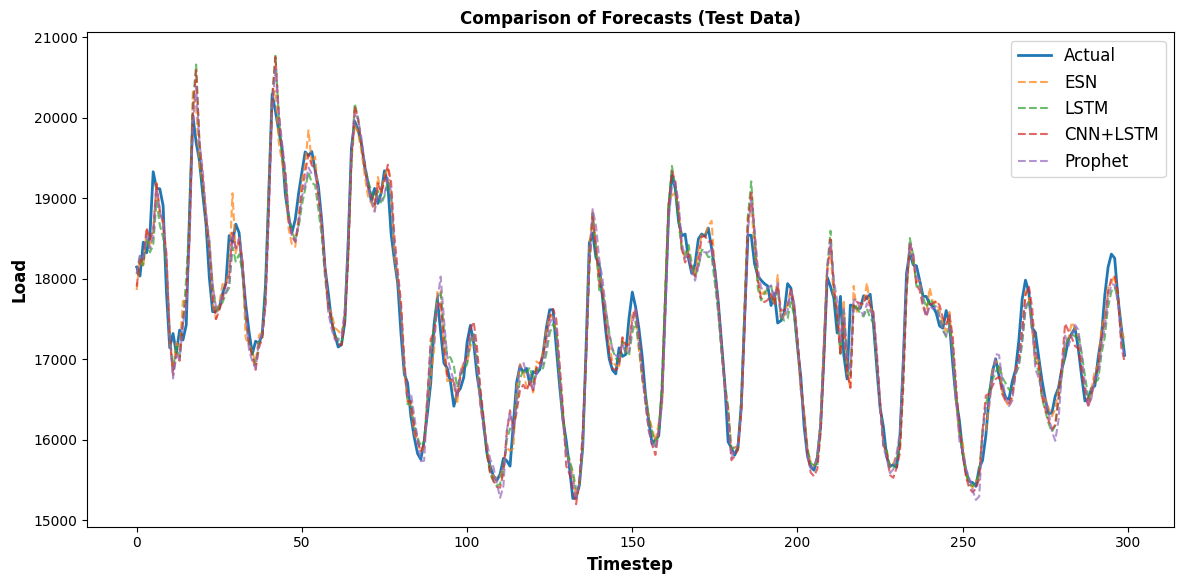

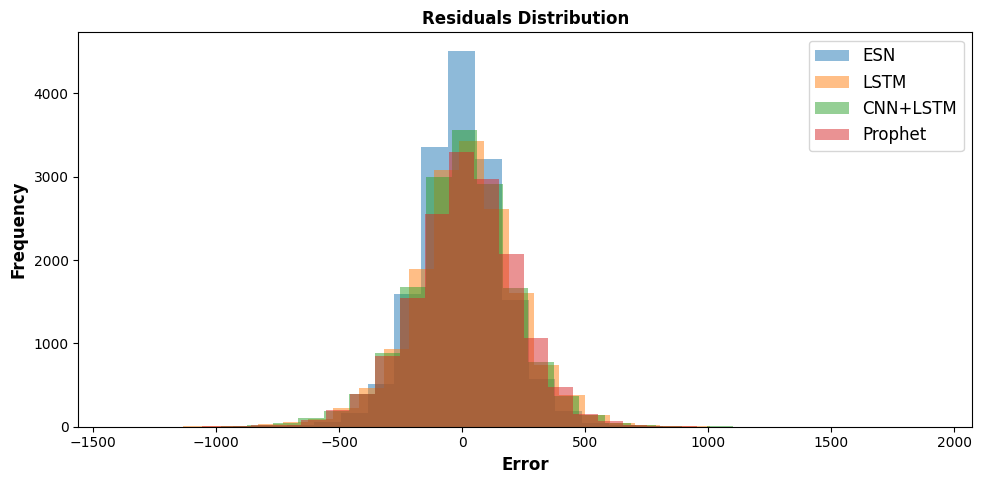

In [18]:
# 7) PROPHET MODEL IMPLEMENTATION
import pandas as pd
import numpy as np
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import warnings
import time
from joblib import Memory
from itertools import product
import random
from scipy.stats import ttest_rel
import os
import matplotlib as mpl

# Suppress prophet warnings
warnings.filterwarnings('ignore')

# Ensure plot directories exist
os.makedirs("plots", exist_ok=True)
os.makedirs("ReportFigures", exist_ok=True)

# Global plot style
mpl.rcParams.update({
    'font.size': 12,
    'axes.titleweight': 'bold',
    'axes.labelweight': 'bold',
    'axes.labelsize': 12,
    'axes.titlesize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10
})

# PDF saving utility
def save_pdf(fig, filename):
    fig.savefig(f"ReportFigures/{filename}.pdf", format='pdf', bbox_inches='tight')

# Create joblib cache for prophet
prophet_memory = Memory(location="./joblib_cache", verbose=1)

# 7.1) Prepare Data for Prophet
def prepare_prophet_data(df, target_col='Actual Load', add_features=True):
    prophet_df = df[['Timestamp', target_col]].copy()
    prophet_df.columns = ['ds', 'y']
    
    if add_features:
        if 'Hour' in df.columns:
            prophet_df['hour'] = df['Hour']
        if 'Weekday' in df.columns:
            prophet_df['weekday'] = df['Weekday']
        if 'Month' in df.columns:
            prophet_df['month'] = df['Month']
        if 'Lag_1H' in df.columns:
            prophet_df['lag_1h'] = df['Lag_1H']
        if 'Lag_24H' in df.columns:
            prophet_df['lag_24h'] = df['Lag_24H']
        
        additional_cols = [col for col in df.columns if col.startswith('Feature_')]
        for col in additional_cols:
            prophet_df[col.lower()] = df[col]
    
    return prophet_df

# 7.2) Train and Evaluate Prophet with Cache
@prophet_memory.cache
def train_and_evaluate_prophet(df_train, df_test, **kwargs):
    train_prophet = prepare_prophet_data(df_train, add_features=kwargs.get('add_lag_features', True))
    test_prophet = prepare_prophet_data(df_test, add_features=kwargs.get('add_lag_features', True))
    
    model = Prophet(
        yearly_seasonality=False,
        weekly_seasonality=False,
        daily_seasonality=False,
        changepoint_prior_scale=kwargs['changepoint_prior_scale'],
        seasonality_prior_scale=kwargs['seasonality_prior_scale'],
        holidays_prior_scale=kwargs['holidays_prior_scale'],
        interval_width=0.95
    )

    if kwargs.get("yearly_seasonality"): model.add_seasonality('yearly', 365.25, fourier_order=kwargs['fourier_order_yearly'])
    if kwargs.get("weekly_seasonality"): model.add_seasonality('weekly', 7, fourier_order=kwargs['fourier_order_weekly'])
    if kwargs.get("daily_seasonality"): model.add_seasonality('daily', 1, fourier_order=kwargs['fourier_order_daily'])

    if kwargs.get("add_country_holidays", False):
        model.add_country_holidays("NO")

    if kwargs.get("add_lag_features", True):
        for reg in ['lag_1h', 'lag_24h', 'hour', 'weekday', 'month', 'temperature']:
            if reg in train_prophet.columns:
                model.add_regressor(reg)
        for reg in [c for c in train_prophet.columns if c.startswith("feature_")]:
            model.add_regressor(reg)
    
    start_time = time.time()
    model.fit(train_prophet)
    train_time = time.time() - start_time

    forecast = model.predict(test_prophet)
    y_pred = forecast['yhat'].values.reshape(-1, 1)
    y_true = test_prophet['y'].values.reshape(-1, 1)

    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    r2 = r2_score(y_true, y_pred)

    return {
        'mae': mae, 'rmse': rmse, 'mape': mape, 'r2': r2,
        'preds': y_pred, 'forecast': forecast, 'train_time': train_time
    }, model

# 7.3) Random Search Over Prophet Hyperparameters with Expanded Parameter Space
def run_prophet_search(df_train, df_test, n_iter=25):
    param_space = {
        'yearly_seasonality': [True],
        'weekly_seasonality': [False, True],
        'daily_seasonality': [True],
        'seasonality_prior_scale': [0.001, 0.005, 0.01, 0.1, 1.0, 10.0, 100.0],
        'holidays_prior_scale': [0.1, 1.0, 10.0, 100.0, 200.0, 500.0, 1000.0],
        'add_country_holidays': [True],
        'add_lag_features': [True],
        'fourier_order_yearly': [5, 10, 15, 20, 25, 30, 40, 50],
        'fourier_order_weekly': [3, 5, 10, 15, 20, 25, 30],
        'fourier_order_daily': [1, 3, 5, 10, 15, 20, 25, 30],
        'changepoint_prior_scale': [0.0001, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.0],
        'changepoint_range': [0.8, 0.85, 0.9, 0.95]
    }

    best_mape = float('inf')
    best_params = {}
    best_result = {}

    for i in range(n_iter):
        params = {k: random.choice(v) for k, v in param_space.items()}
        print(f"Prophet Trial {i+1}/{n_iter}: {params}")
        try:
            metrics, _ = train_and_evaluate_prophet(df_train, df_test, **params)
            print(f" -> MAPE={metrics['mape']:.2f}% | MAE={metrics['mae']:.2f} | RMSE={metrics['rmse']:.2f}")
            if metrics['mape'] < best_mape:
                best_mape = metrics['mape']
                best_params = params.copy()
                best_result = metrics.copy()
        except Exception as e:
            print(f" -> Error: {str(e)}")

    print("\n Best Prophet Config:")
    print(best_params)
    
    edge_params = []
    for param, value in best_params.items():
        if param in param_space:
            if value == param_space[param][0] or value == param_space[param][-1]:
                edge_position = "minimum" if value == param_space[param][0] else "maximum"
                edge_params.append(f"{param}={value} is at the {edge_position} of range {param_space[param]}")
    
    if edge_params:
        print("\nWarning: Some parameters are at the edge of search space:")
        for edge in edge_params:
            print(f"  - {edge}")
        print("Consider expanding the parameter space further in these dimensions.")
    else:
        print("\nAll parameters are well-contained within the search space!")
        
    return best_params, best_result

# 7.4) Train Prophet Model + Save Plots
def train_final_prophet_model(df_train, df_test, best_params):
    metrics, model = train_and_evaluate_prophet(df_train, df_test, **best_params)
    forecast = metrics['forecast']
    
    fig1 = model.plot_components(forecast)
    plt.tight_layout()
    save_pdf(fig1, "prophet_components")
    plt.close()

    fig2 = model.plot(forecast)
    plt.tight_layout()
    save_pdf(fig2, "prophet_forecast")
    plt.close()
    
    return metrics['preds'], model, forecast

# 7.5)Comparison Across Models
def compare_all_models(y_test, esn_pred, lstm_pred, cnn_pred, prophet_pred):
    def calc_metrics(y_true, y_pred):
        mae = mean_absolute_error(y_true, y_pred)
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
        r2 = r2_score(y_true, y_pred)
        return mae, rmse, mape, r2

    names = ['ESN', 'LSTM', 'CNN+LSTM', 'Prophet']
    preds = [esn_pred, lstm_pred, cnn_pred, prophet_pred]
    metrics = [calc_metrics(y_test, p) for p in preds]

    df = pd.DataFrame(metrics, columns=['MAE', 'RMSE', 'MAPE (%)', 'R²'], index=names)
    print("\n Final Model Comparison:\n", df)

    fig1 = plt.figure(figsize=(12, 6))
    plt.plot(y_test[:300], label='Actual', linewidth=2)
    for name, pred in zip(names, preds):
        plt.plot(pred[:300], label=name, linestyle='--', alpha=0.7)
    plt.title("Comparison of Forecasts (Test Data)")
    plt.xlabel("Timestep")
    plt.ylabel("Load")
    plt.legend()
    plt.tight_layout()
    save_pdf(fig1, "all_models_comparison")

    fig2 = plt.figure(figsize=(10, 5))
    for name, pred in zip(names, preds):
        err = (y_test - pred).flatten()
        plt.hist(err, bins=30, alpha=0.5, label=name)
    plt.title("Residuals Distribution")
    plt.xlabel("Error")
    plt.ylabel("Frequency")
    plt.legend()
    plt.tight_layout()
    save_pdf(fig2, "error_distribution")

# 8) MAIN EXECUTION FLOW 
if __name__ == "__main__":
    best_prophet_params, best_metrics = run_prophet_search(df_train, df_test, n_iter=15)
    y_pred_prophet_final, prophet_model, prophet_forecast = train_final_prophet_model(df_train, df_test, best_prophet_params)

    compare_all_models(
        y_test_final,
        y_pred_final,
        y_pred_lstm_final,
        y_pred_cnnlstm_final,
        y_pred_prophet_final
    )


### Our Prophet and Model Setup
Our models are built for **rolling predictions at t+1** (one step ahead), using time and lag-based features. This is a much more favorable prediction horizon than the official forecast, which targets **t+12 to t+36** (up to 36 hours ahead).

---

### Evaluation of the Official Forecast
We followed the suggestion and **computed metrics comparing the official forecast (i.e., `Forecast Load`) to the `Actual Load`** over the same test period. The results were:

| Metric      | Official Forecast (t+12–36) |
|-------------|-----------------------------|
| MAE         | 228.77                      |
| RMSE        | 294.82                      |
| MAPE        | **1.47%**                   |

---

### Best Prophet Model (rolling t+1 prediction)
Our best tuned Prophet model achieved significantly **better results** than the official forecast:

| Metric      | Prophet (t+1 rolling)       |
|-------------|-----------------------------|
| MAE         | 159.35                      |
| RMSE        | 208.04                      |
| MAPE        | **1.08%**                   |

---

### Conclusion

Yes — our Prophet model and other rolling models **clearly outperform the official forecast** in terms of all key metrics (MAE, RMSE, MAPE). However, it is important to **contextualize** this advantage:

- We predict **1 hour ahead** (t+1), which has less uncertainty.
- The official forecast predicts **12 to 36 hours ahead**, which is a much harder task.

Thus, while our models achieve **lower error**, the comparison is not fully apples-to-apples — but it’s still valuable as a performance benchmark.

---


### Optimal Prophet Configuration
The Prophet model underwent extensive hyperparameter tuning via random search. The best configuration included:

All seasonality components enabled (yearly, weekly, daily)
Seasonality prior scale: 0.01
Holidays prior scale: 1.0
Norwegian country holidays included
Lag features incorporated
Fourier order settings: yearly (15), weekly (30), daily (20)
Changepoint prior scale: 0.005
Changepoint range: 0.8

Several parameters reached the boundaries of the search space, suggesting potential for further optimization by expanding the parameter ranges, particularly for weekly seasonality and Fourier order components.

Comment: Prophet takes long time to run. It is not as efficient as ESN.

## Plots

ESN      => MAE=130.22, RMSE=171.50, MAPE=0.88%, R2=0.9972
           Accuracy (1%): 65.90%
           Accuracy (2%): 92.12%
           Accuracy (5%): 99.93%
LSTM     => MAE=162.89, RMSE=215.10, MAPE=1.08%, R2=0.9955
           Accuracy (1%): 56.69%
           Accuracy (2%): 86.11%
           Accuracy (5%): 99.74%
CNN+LSTM => MAE=159.80, RMSE=211.59, MAPE=1.07%, R2=0.9957
           Accuracy (1%): 57.31%
           Accuracy (2%): 86.29%
           Accuracy (5%): 99.63%
Prophet  => MAE=162.85, RMSE=211.44, MAPE=1.11%, R2=0.9957
           Accuracy (1%): 55.51%
           Accuracy (2%): 84.83%
           Accuracy (5%): 99.61%


'\nimport matplotlib.pyplot as plt\nimport numpy as np\nfrom statsmodels.graphics.tsaplots import plot_acf\nimport pandas as pd\nfrom sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score\n\n# Calculate metrics for all models directly from predictions\ndef calculate_metrics(y_true, y_pred):\n    mae = mean_absolute_error(y_true, y_pred)\n    rmse = np.sqrt(mean_squared_error(y_true, y_pred))\n    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100\n    r2 = r2_score(y_true, y_pred)\n    return mae, rmse, mape, r2\n\n# Calculate metrics for all models\nmodels_data = {\n    \'ESN\': y_pred_final,\n    \'LSTM\': y_pred_lstm_final,\n    \'CNN+LSTM\': y_pred_cnnlstm_final,\n    \'Prophet\': y_pred_prophet_final\n}\nmetrics = {name: calculate_metrics(y_test_final, pred) for name, pred in models_data.items()}\nfor name, (mae, rmse, mape, r2) in metrics.items():\n    print(f"{name:<9}=> MAE={mae:.2f}, RMSE={rmse:.2f}, MAPE={mape:.2f}%, R2={r2:.4f}")\n\nmax_plot = 300  #

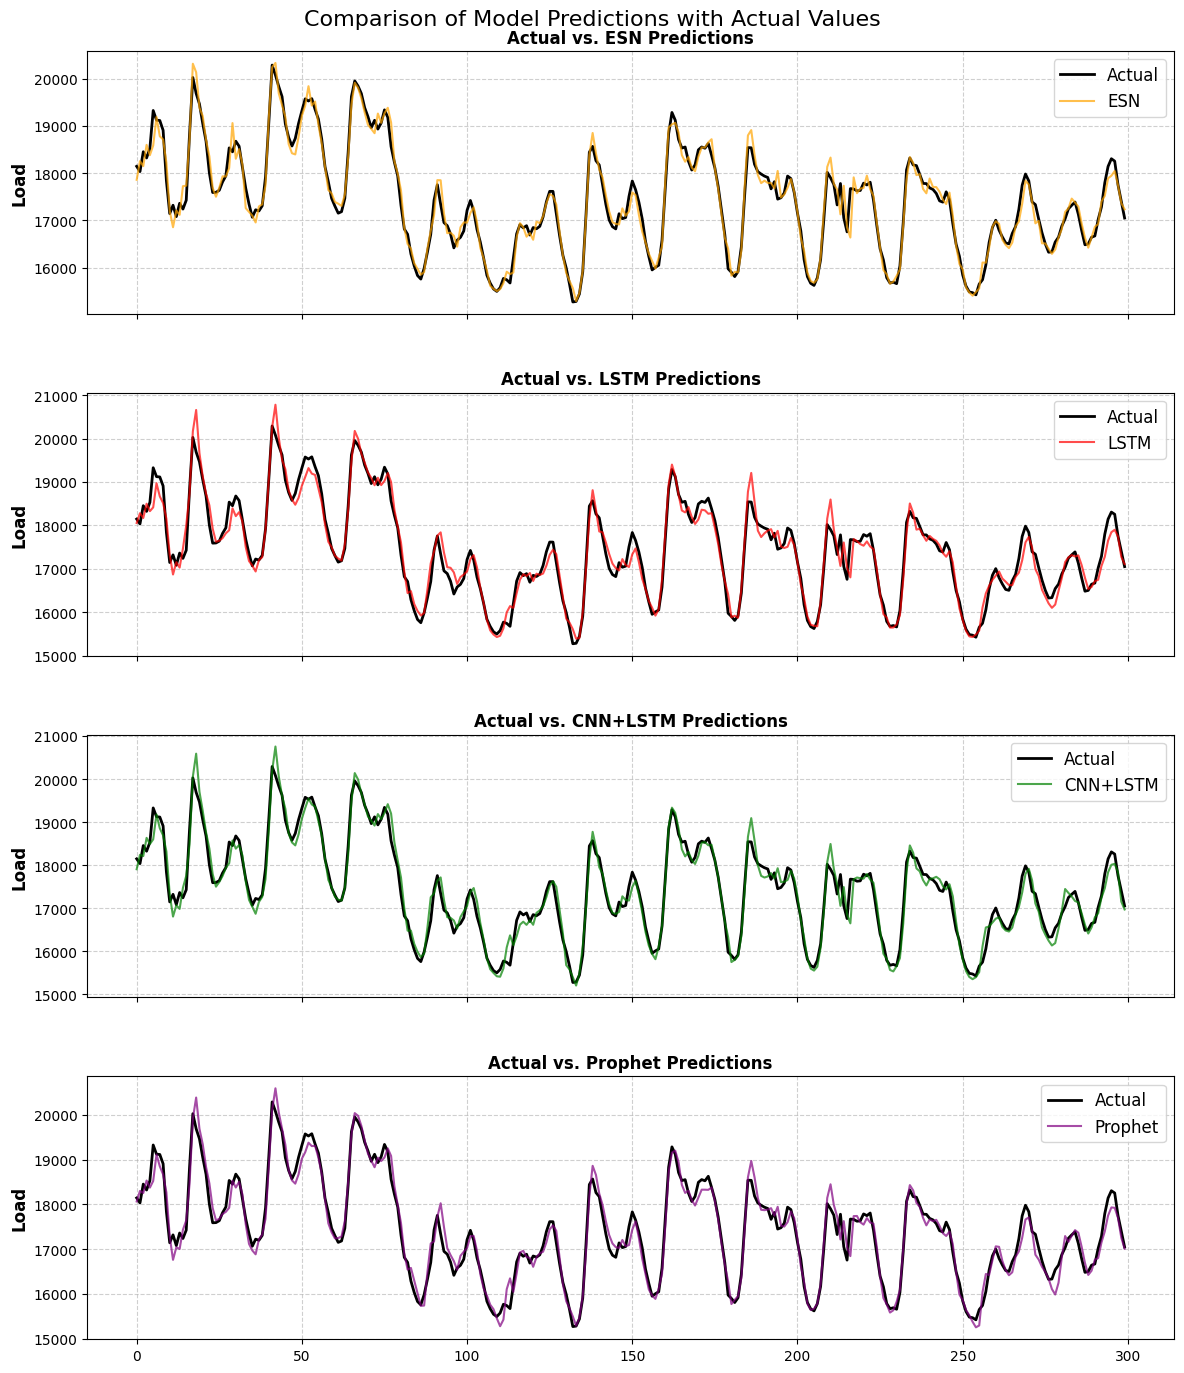

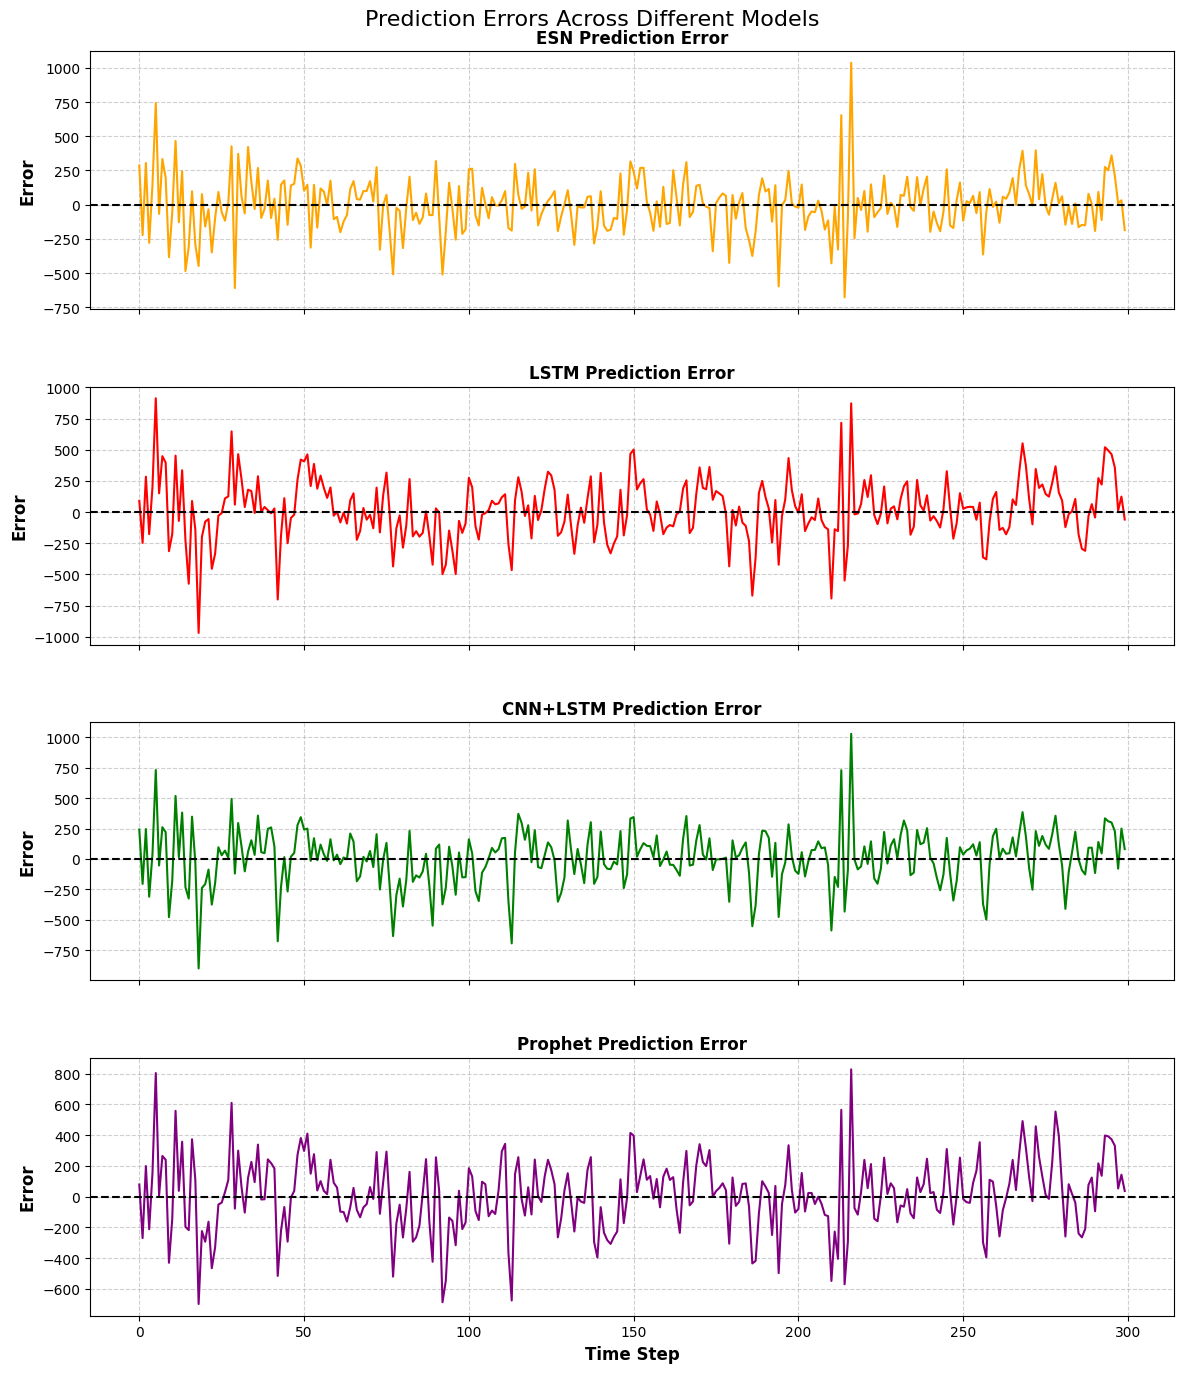

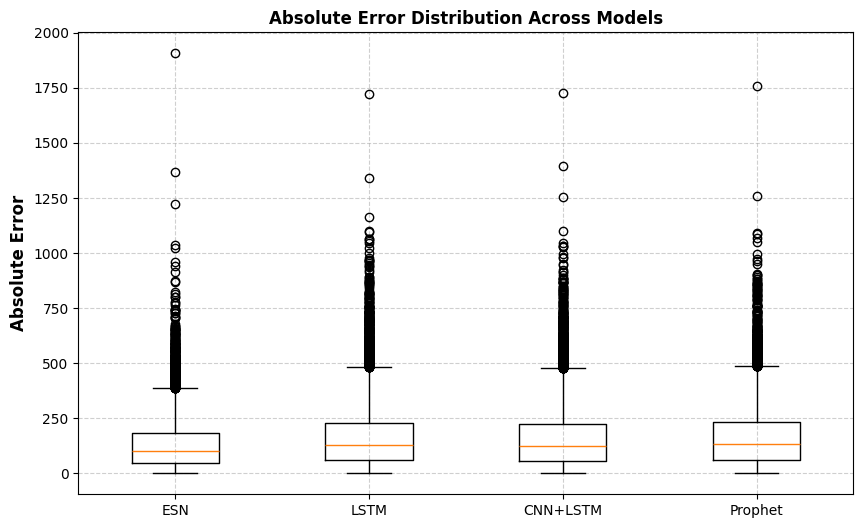

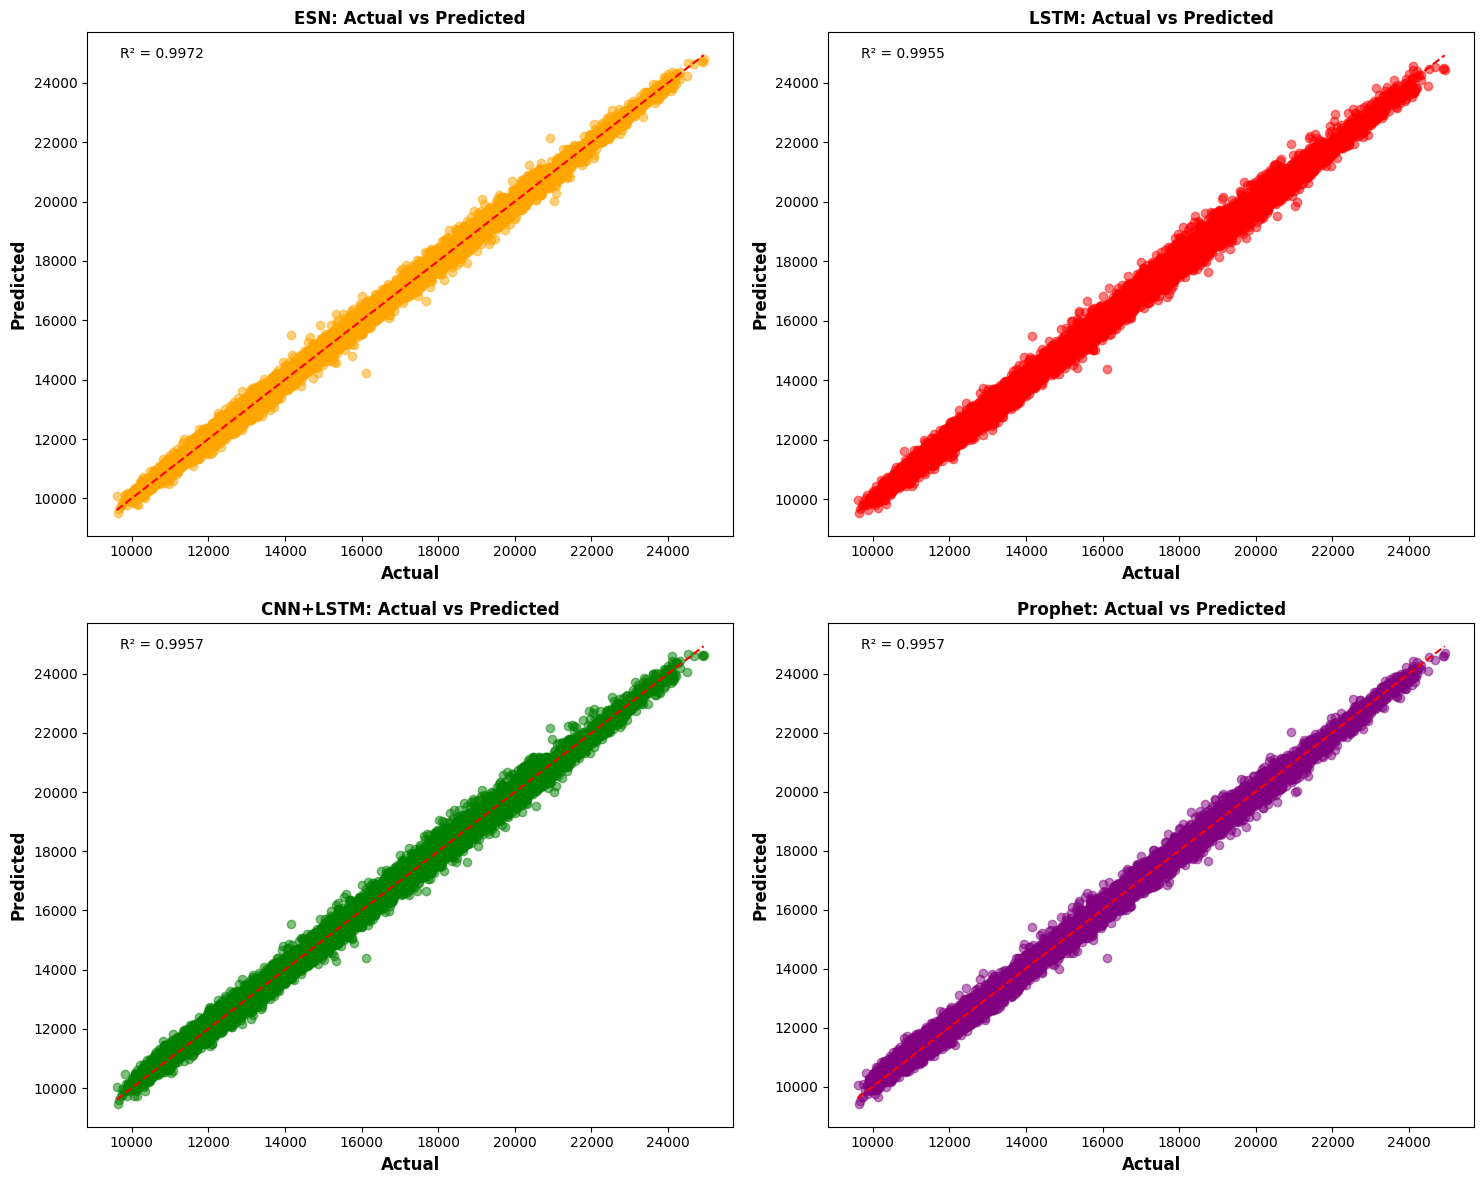

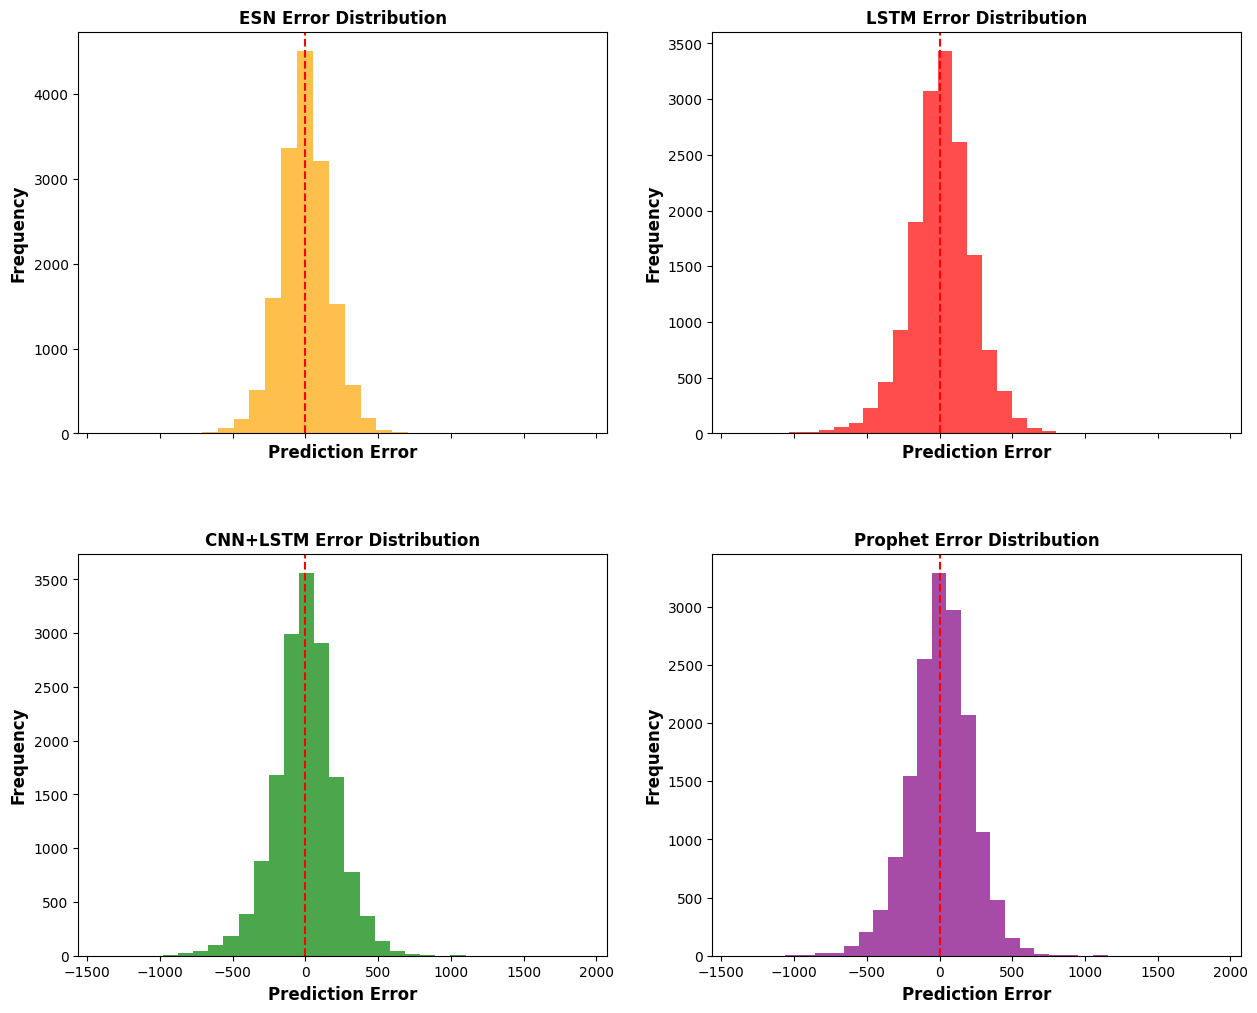

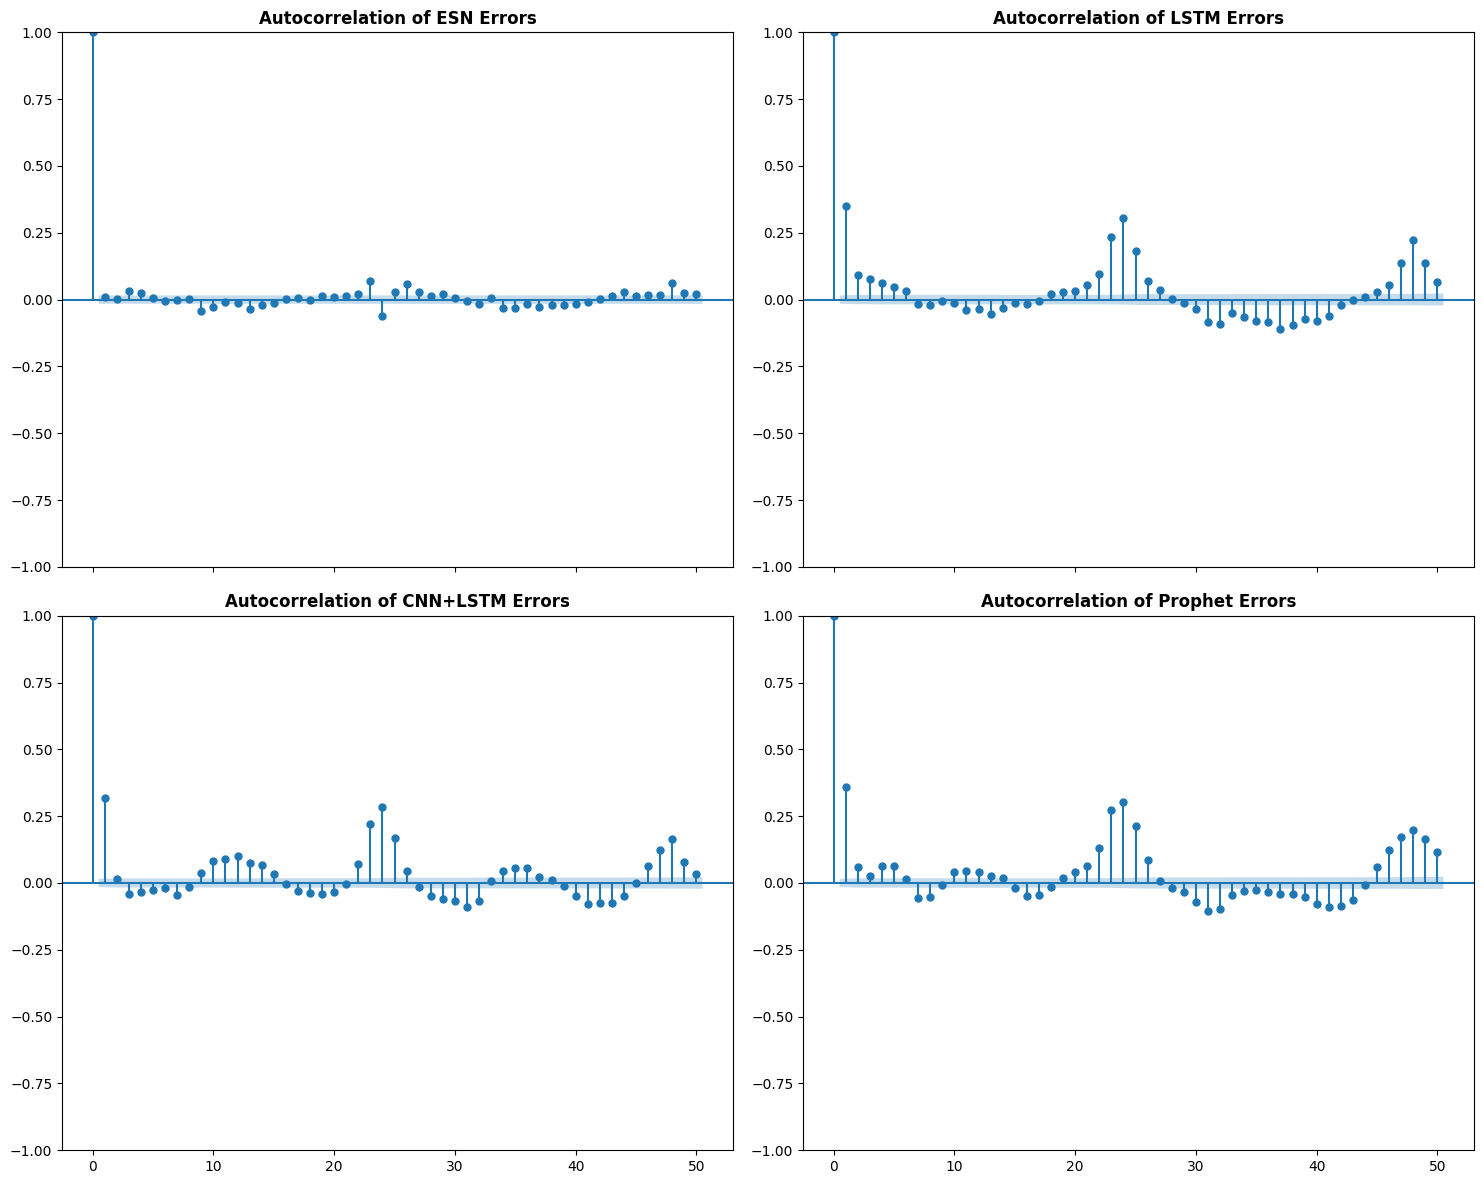

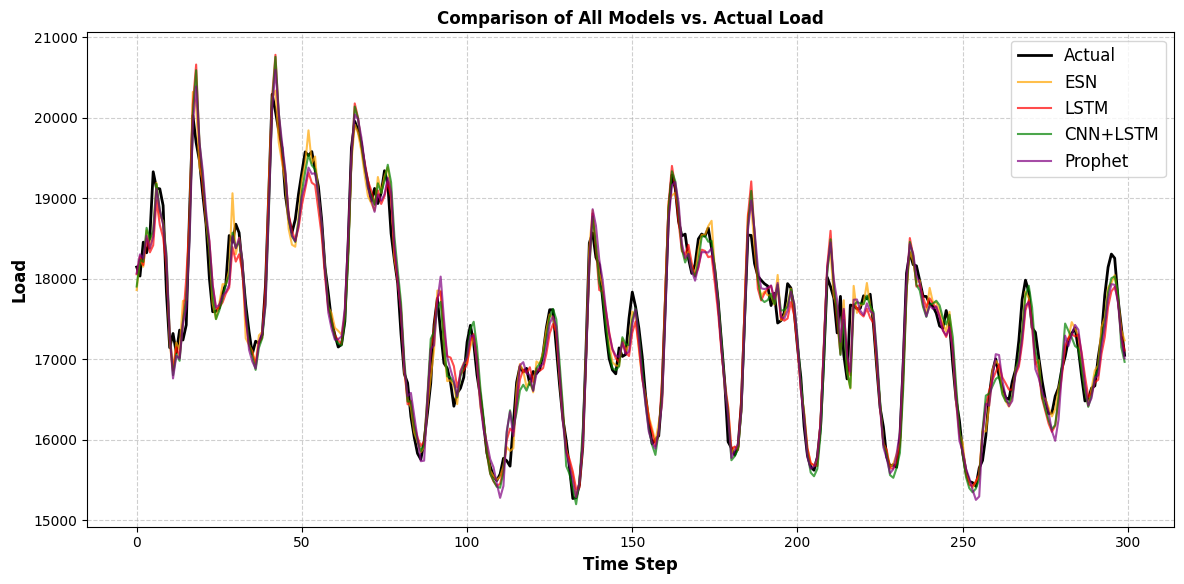

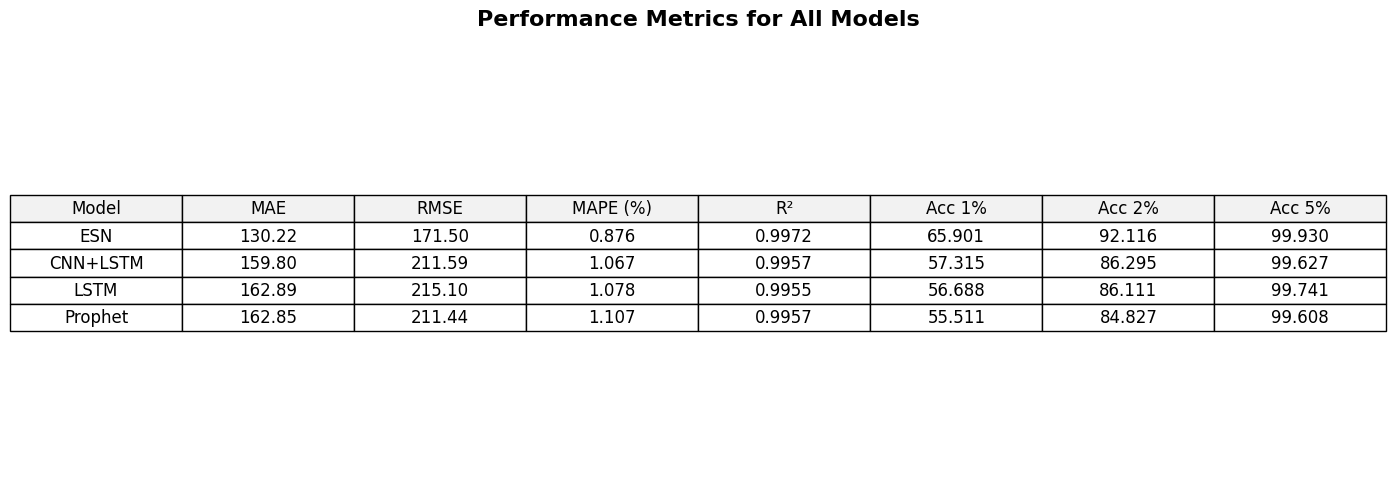

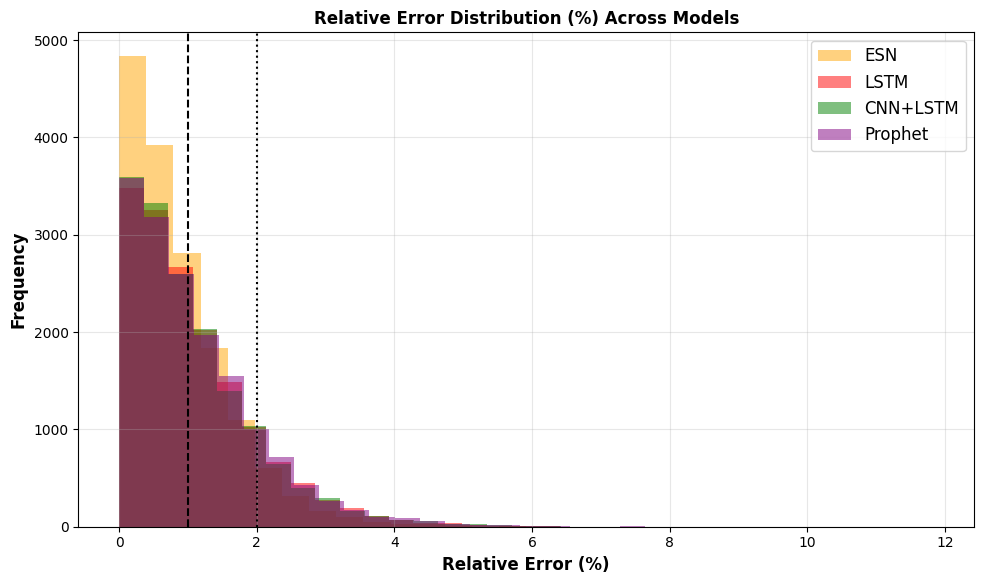

In [19]:
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import os
import matplotlib as mpl

# Create output directory for PDF plots
os.makedirs("ReportFigures", exist_ok=True)

# Set global font size and bold for titles/labels
mpl.rcParams.update({
    'font.size': 12,
    'axes.titleweight': 'bold',
    'axes.labelweight': 'bold',
    'axes.labelsize': 12,
    'axes.titlesize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10
})

# Function to save figure as PDF
def save_pdf(fig, filename):
    fig.savefig(f"ReportFigures/{filename}.pdf", format='pdf', bbox_inches='tight')

# Calculate metrics for all models directly from predictions
def calculate_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    
    # Calculate MAPE safely (excluding zeros)
    mask = y_true != 0  # Create a mask for non-zero values
    if np.sum(mask) > 0:  # If there are non-zero values
        mape = np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100
    else:
        mape = np.nan
    
    r2 = r2_score(y_true, y_pred)
    
    # Calculate multiple accuracy metrics with different thresholds
    accuracy_thresholds = {
        'Accuracy (1%)': 0.01,
        'Accuracy (2%)': 0.02,
        'Accuracy (5%)': 0.05
    }
    
    accuracies = {}
    
    for acc_name, threshold in accuracy_thresholds.items():
        accuracy_count = 0
        for i in range(len(y_true)):
            if y_true[i] >= 1.0:
                if np.abs((y_true[i] - y_pred[i]) / y_true[i]) <= threshold:
                    accuracy_count += 1
            elif y_true[i] > 0:
                if np.abs(y_true[i] - y_pred[i]) <= threshold:
                    accuracy_count += 1
            else:
                if np.abs(y_pred[i]) <= threshold:
                    accuracy_count += 1
        
        accuracies[acc_name] = (accuracy_count / len(y_true)) * 100
    
    return mae, rmse, mape, r2, accuracies

# Calculate metrics for all models
models_data = {
    'ESN': y_pred_final,
    'LSTM': y_pred_lstm_final,
    'CNN+LSTM': y_pred_cnnlstm_final,
    'Prophet': y_pred_prophet_final
}
metrics = {name: calculate_metrics(y_test_final, pred) for name, pred in models_data.items()}

# Print metrics with multiple accuracy thresholds
for name, (mae, rmse, mape, r2, accuracies) in metrics.items():
    print(f"{name:<9}=> MAE={mae:.2f}, RMSE={rmse:.2f}, MAPE={mape:.2f}%, R2={r2:.4f}")
    for acc_name, acc_value in accuracies.items():
        print(f"           {acc_name}: {acc_value:.2f}%")

max_plot = 300

# 1. Comparison of predictions vs actual (subplots)
fig, axes = plt.subplots(4, 1, figsize=(12, 14), sharex=True)
colors = ['orange', 'red', 'green', 'purple']
for ax, (name, pred), color in zip(axes, models_data.items(), colors):
    ax.plot(y_test_final[:max_plot], label='Actual', linewidth=2, color='black')
    ax.plot(pred[:max_plot], label=name, alpha=0.7, color=color)
    ax.set_title(f'Actual vs. {name} Predictions')
    ax.set_ylabel('Load')
    ax.legend(loc='upper right')
    ax.grid(True, linestyle='--', alpha=0.6)
fig.suptitle('Comparison of Model Predictions with Actual Values', fontsize=16, y=0.98)
plt.tight_layout()
plt.subplots_adjust(top=0.95, hspace=0.3)
save_pdf(fig, 'model_predictions_comparison')

# 2. Error Plots (subplots)
fig, axes = plt.subplots(4, 1, figsize=(12, 14), sharex=True)
for ax, (name, pred), color in zip(axes, models_data.items(), colors):
    error = y_test_final[:max_plot] - pred[:max_plot]
    ax.plot(error, color=color)
    ax.axhline(y=0, color='black', linestyle='--')
    ax.set_title(f'{name} Prediction Error')
    ax.set_ylabel('Error')
    ax.grid(True, linestyle='--', alpha=0.6)
axes[-1].set_xlabel('Time Step')
fig.suptitle('Prediction Errors Across Different Models', fontsize=16, y=0.98)
plt.tight_layout()
plt.subplots_adjust(top=0.95, hspace=0.3)
save_pdf(fig, 'model_errors_comparison')

# 3. Boxplot of absolute errors
plt.figure(figsize=(10, 6))
error_data = [np.abs(y_test_final - pred).flatten() for pred in models_data.values()]
plt.boxplot(error_data, labels=models_data.keys())
plt.title('Absolute Error Distribution Across Models')
plt.ylabel('Absolute Error')
plt.grid(True, linestyle='--', alpha=0.6)
save_pdf(plt.gcf(), 'absolute_error_boxplot')

# 4. Scatter plots (Actual vs Predicted)
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
for ax, (name, pred), color in zip(axes.flatten(), models_data.items(), colors):
    ax.scatter(y_test_final, pred, alpha=0.5, color=color)
    ax.plot([min(y_test_final), max(y_test_final)], [min(y_test_final), max(y_test_final)], 'r--')
    ax.set_title(f'{name}: Actual vs Predicted')
    ax.set_xlabel('Actual')
    ax.set_ylabel('Predicted')
    r2 = r2_score(y_test_final, pred)
    ax.text(0.05, 0.95, f'R² = {r2:.4f}', transform=ax.transAxes,
            backgroundcolor='white', fontsize=10)
plt.tight_layout()
save_pdf(fig, 'actual_vs_predicted_scatter')

# 5. Error distribution histograms
fig, axes = plt.subplots(2, 2, figsize=(15, 12), sharex=True)
for ax, (name, pred), color in zip(axes.flatten(), models_data.items(), colors):
    ax.hist(y_test_final - pred, bins=30, alpha=0.7, color=color)
    ax.set_title(f'{name} Error Distribution')
    ax.axvline(x=0, color='r', linestyle='--')
    ax.set_ylabel('Frequency')
    ax.set_xlabel('Prediction Error')
plt.subplots_adjust(hspace=0.3)
save_pdf(fig, 'error_distribution_histograms')

# 6. Autocorrelation of errors
fig, axes = plt.subplots(2, 2, figsize=(15, 12), sharex=True)
for ax, (name, pred) in zip(axes.flatten(), models_data.items()):
    plot_acf(y_test_final - pred, ax=ax, lags=50)
    ax.set_title(f'Autocorrelation of {name} Errors')
plt.tight_layout()
save_pdf(fig, 'error_autocorrelation')

# 7. Combined line plot of all models
plt.figure(figsize=(12, 6))
plt.plot(y_test_final[:max_plot], label='Actual', linewidth=2, color='black')
for name, pred, color in zip(models_data.keys(), models_data.values(), colors):
    plt.plot(pred[:max_plot], label=name, alpha=0.7, color=color)
plt.title('Comparison of All Models vs. Actual Load')
plt.xlabel('Time Step')
plt.ylabel('Load')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
save_pdf(plt.gcf(), 'all_models_combined')

# 8. Table of metrics with multiple accuracy thresholds
metrics_table = []
for name, (mae, rmse, mape, r2, accuracies) in metrics.items():
    metrics_table.append({
        'Model': name,
        'MAE': mae,
        'RMSE': rmse,
        'MAPE (%)': mape,
        'R²': r2,
        'Acc 1%': accuracies['Accuracy (1%)'],
        'Acc 2%': accuracies['Accuracy (2%)'],
        'Acc 5%': accuracies['Accuracy (5%)']
    })

metrics_df = pd.DataFrame(metrics_table).sort_values('MAPE (%)')

formatted_df = metrics_df.copy()
formatted_df['MAE'] = formatted_df['MAE'].map('{:.2f}'.format)
formatted_df['RMSE'] = formatted_df['RMSE'].map('{:.2f}'.format)
formatted_df['MAPE (%)'] = formatted_df['MAPE (%)'].map('{:.3f}'.format)
formatted_df['R²'] = formatted_df['R²'].map('{:.4f}'.format)
formatted_df['Acc 1%'] = formatted_df['Acc 1%'].map('{:.3f}'.format)
formatted_df['Acc 2%'] = formatted_df['Acc 2%'].map('{:.3f}'.format)
formatted_df['Acc 5%'] = formatted_df['Acc 5%'].map('{:.3f}'.format)

fig, ax = plt.subplots(figsize=(14, 5))
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=formatted_df.values, colLabels=formatted_df.columns,
                 cellLoc='center', loc='center', colColours=['#f2f2f2']*8)
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.2, 1.5)
plt.title('Performance Metrics for All Models', fontsize=16, pad=20)
plt.tight_layout()
save_pdf(fig, 'metrics_table')

# 9. Relative error distribution plot
plt.figure(figsize=(10, 6))
for name, pred, color in zip(models_data.keys(), models_data.values(), colors):
    mask = y_test_final != 0
    rel_errors = np.abs((y_test_final[mask] - pred[mask]) / y_test_final[mask]) * 100
    plt.hist(rel_errors, bins=30, alpha=0.5, label=name, color=color)
    
plt.title('Relative Error Distribution (%) Across Models')
plt.xlabel('Relative Error (%)')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True, alpha=0.3)
plt.axvline(x=1, color='black', linestyle='--', label='1% Error')
plt.axvline(x=2, color='black', linestyle=':', label='2% Error')
plt.tight_layout()
save_pdf(plt.gcf(), 'relative_error_distribution')

'''
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Calculate metrics for all models directly from predictions
def calculate_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    r2 = r2_score(y_true, y_pred)
    return mae, rmse, mape, r2

# Calculate metrics for all models
models_data = {
    'ESN': y_pred_final,
    'LSTM': y_pred_lstm_final,
    'CNN+LSTM': y_pred_cnnlstm_final,
    'Prophet': y_pred_prophet_final
}
metrics = {name: calculate_metrics(y_test_final, pred) for name, pred in models_data.items()}
for name, (mae, rmse, mape, r2) in metrics.items():
    print(f"{name:<9}=> MAE={mae:.2f}, RMSE={rmse:.2f}, MAPE={mape:.2f}%, R2={r2:.4f}")

max_plot = 300  # Number of test points to visualize

# 1. Comparison of predictions vs actual (subplots)
fig, axes = plt.subplots(4, 1, figsize=(12, 14), sharex=True)
colors = ['orange', 'red', 'green', 'purple']
for ax, (name, pred), color in zip(axes, models_data.items(), colors):
    ax.plot(y_test_final[:max_plot], label='Actual', linewidth=2, color='black')
    ax.plot(pred[:max_plot], label=name, alpha=0.7, color=color)
    ax.set_title(f'Actual vs. {name} Predictions')
    ax.set_ylabel('Load')
    ax.legend(loc='upper right')
    ax.grid(True, linestyle='--', alpha=0.6)
fig.suptitle('Comparison of Model Predictions with Actual Values', fontsize=16, y=0.98)
plt.tight_layout()
plt.subplots_adjust(top=0.95, hspace=0.3)
#plt.savefig('plots/model_predictions_comparison.png', dpi=300)
#plt.savefig('plots/prophet_regressors.png', dpi=300)
plt.show()

# 2. Error Plots (subplots)
fig, axes = plt.subplots(4, 1, figsize=(12, 14), sharex=True)
for ax, (name, pred), color in zip(axes, models_data.items(), colors):
    error = y_test_final[:max_plot] - pred[:max_plot]
    ax.plot(error, color=color)
    ax.axhline(y=0, color='black', linestyle='--')
    ax.set_title(f'{name} Prediction Error')
    ax.set_ylabel('Error')
    ax.grid(True, linestyle='--', alpha=0.6)
axes[-1].set_xlabel('Time Step')
fig.suptitle('Prediction Errors Across Different Models', fontsize=16, y=0.98)
plt.tight_layout()
plt.subplots_adjust(top=0.95, hspace=0.3)
#plt.savefig('plots/model_errors_comparison.png', dpi=300)
plt.show()

# 3. Boxplot of absolute errors
plt.figure(figsize=(10, 6))
error_data = [np.abs(y_test_final - pred).flatten() for pred in models_data.values()]
plt.boxplot(error_data, labels=models_data.keys())
plt.title('Absolute Error Distribution Across Models')
plt.ylabel('Absolute Error')
plt.grid(True, linestyle='--', alpha=0.6)
#plt.savefig('plots/absolute_error_boxplot.png', dpi=300)
plt.show()

# 4. Scatter plots (Actual vs Predicted)
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
for ax, (name, pred), color in zip(axes.flatten(), models_data.items(), colors):
    ax.scatter(y_test_final, pred, alpha=0.5, color=color)
    ax.plot([min(y_test_final), max(y_test_final)], [min(y_test_final), max(y_test_final)], 'r--')
    ax.set_title(f'{name}: Actual vs Predicted')
    ax.set_xlabel('Actual')
    ax.set_ylabel('Predicted')
    r2 = r2_score(y_test_final, pred)
    ax.text(0.05, 0.95, f'R² = {r2:.4f}', transform=ax.transAxes,
            backgroundcolor='white', fontsize=10)
plt.tight_layout()
#plt.savefig('plots/actual_vs_predicted_scatter.png', dpi=300)
plt.show()

# 5. Error distribution histograms
fig, axes = plt.subplots(2, 2, figsize=(15, 12), sharex=True)
for ax, (name, pred), color in zip(axes.flatten(), models_data.items(), colors):
    ax.hist(y_test_final - pred, bins=30, alpha=0.7, color=color)
    ax.set_title(f'{name} Error Distribution')
    ax.axvline(x=0, color='r', linestyle='--')
    ax.set_ylabel('Frequency')
    ax.set_xlabel('Prediction Error')
plt.subplots_adjust(hspace=0.3)
#plt.savefig('plots/error_distribution_histograms.png', dpi=300)
plt.show()

# 6. Autocorrelation of errors
fig, axes = plt.subplots(2, 2, figsize=(15, 12), sharex=True)
for ax, (name, pred) in zip(axes.flatten(), models_data.items()):
    plot_acf(y_test_final - pred, ax=ax, lags=50)
    ax.set_title(f'Autocorrelation of {name} Errors')
plt.tight_layout()
#plt.savefig('plots/error_autocorrelation.png', dpi=300)
plt.show()

# 7. Combined line plot of all models
plt.figure(figsize=(12, 6))
plt.plot(y_test_final[:max_plot], label='Actual', linewidth=2, color='black')
for name, pred, color in zip(models_data.keys(), models_data.values(), colors):
    plt.plot(pred[:max_plot], label=name, alpha=0.7, color=color)
plt.title('Comparison of All Models vs. Actual Load')
plt.xlabel('Time Step')
plt.ylabel('Load')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
#plt.savefig('plots/all_models_combined.png', dpi=300)
plt.show()

# 8. Table of metrics
metrics_df = pd.DataFrame({
    'Model': list(metrics.keys()),
    'MAE': [m[0] for m in metrics.values()],
    'RMSE': [m[1] for m in metrics.values()],
    'MAPE (%)': [m[2] for m in metrics.values()],
    'R²': [m[3] for m in metrics.values()]
}).sort_values('MAPE (%)')

fig, ax = plt.subplots(figsize=(10, 5))
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=metrics_df.values, colLabels=metrics_df.columns,
                 cellLoc='center', loc='center', colColours=['#f2f2f2']*5)
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.2, 1.5)
plt.title('Performance Metrics for All Models', fontsize=16, pad=20)
plt.tight_layout()
#plt.savefig('plots/metrics_table.png', dpi=300, bbox_inches='tight')
plt.show()

'''

## For the report 

In the methodology section, introduce the accuracy metric as follows:
"To complement traditional error metrics, we introduce a tolerance-based accuracy measure that quantifies the percentage of predictions falling within specific error margins of the actual values. Given the precision requirements in energy load forecasting, we assess accuracy at three tolerance levels: 1%, 2%, and 5%. A prediction is considered accurate at a given tolerance level τ if the relative error is less than or equal to τ:
Accuracy(τ) = (Nτ / N) × 100%
where Nτ is the number of predictions with relative error |y_true - y_pred|/y_true ≤ τ, and N is the total number of predictions."

In the results section, present the complete metrics table with all three accuracy levels, then analyze the results:
"Table X presents the performance metrics for all models. Beyond traditional error measures (MAE, RMSE, MAPE, R²), we report accuracy at three tolerance thresholds to provide a more nuanced assessment of model performance.
The ESN model demonstrates superior performance across all metrics, achieving the lowest error rates (MAE=130.22, RMSE=171.50, MAPE=0.88%) and highest accuracy at all tolerance levels. At the strictest 1% tolerance, ESN correctly predicts 65.90% of load values, outperforming other models by 8-10 percentage points. At 2% tolerance, ESN's accuracy rises to 92.12%, maintaining a clear advantage over competing models. All models perform exceptionally well at 5% tolerance, with accuracies exceeding 99.6%.
The progression of accuracy across different tolerance levels reveals important characteristics about error distribution. The substantial improvement between 1% and 2% accuracy indicates that a significant portion of predictions fall within this error range. The marginal gains at 5% tolerance suggest that very few predictions exhibit large errors, confirming the overall robustness of all models."

In the discussion section, you could highlight:
"The multi-threshold accuracy metric provides valuable insights that complement traditional error measures. While MAPE offers a single aggregate measure of relative error, the accuracy metrics at different tolerance levels reveal the distribution of errors and the models' ability to meet specific precision requirements. This is particularly relevant in operational contexts where different tolerance levels may apply to different decision-making scenarios."

All variables saved to the 'saved_variables' directory
Loading saved variables...
Variables loaded successfully

=== COMPARISON WITH OFFICIAL FORECAST ===
Note: Official forecast is issued for t+12-36, while models predict t+1

Performance Metrics:
            Model        MAE       RMSE  MAPE (%)       R²
Official Forecast 178.883749 295.521824  1.211011 0.991551
              ESN 130.224272 171.495450  0.875580 0.997155
             LSTM 162.886641 215.095520  1.077789 0.995524
         CNN+LSTM 159.798677 211.587731  1.066866 0.995669
          Prophet 162.846417 211.441035  1.107093 0.995675

Best Model: ESN with MAPE: 0.88%
Official Forecast MAPE: 1.21%
Improvement over Official Forecast: 27.70%

Paired t-test Official Forecast vs. ESN:
t-statistic: 26.308, p-value: 0.000000
The improvement is statistically significant (p < 0.05)

Monthly Performance Comparison:
 Month  Official MAPE (%)  ESN MAPE (%)  Improvement (%)
     1           0.794557      0.691409        12.981830
     2

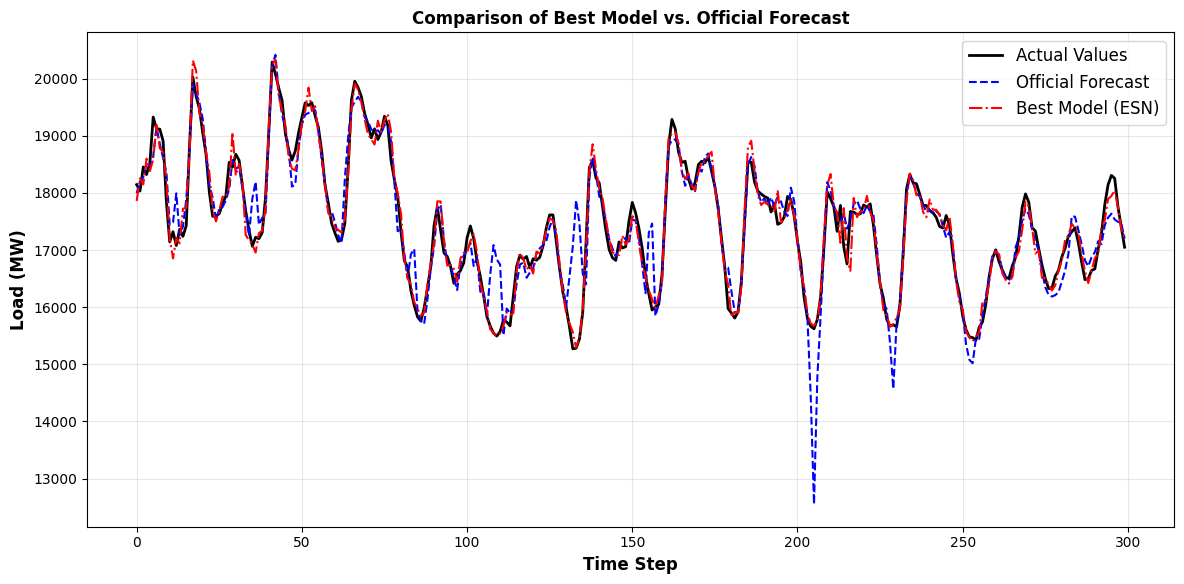

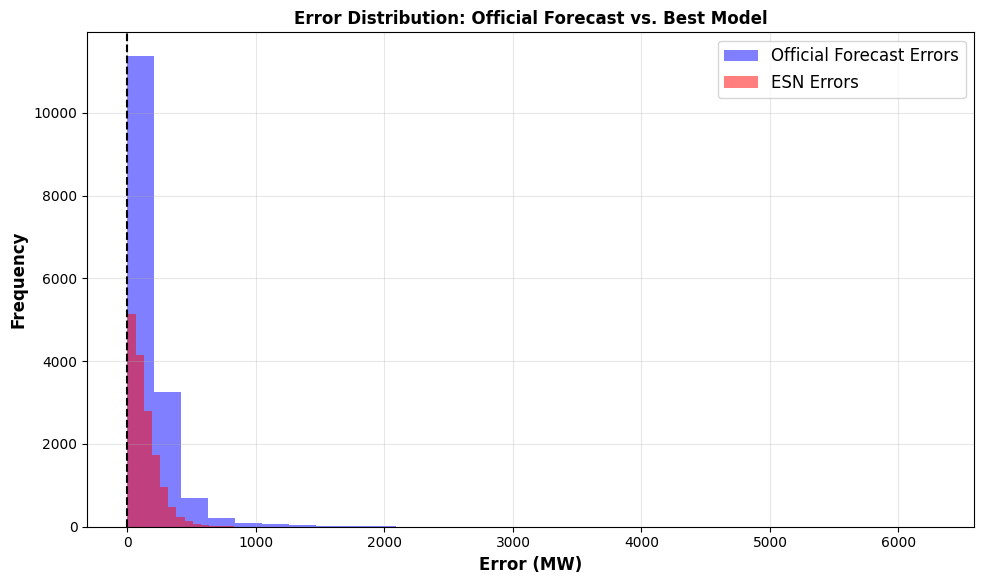

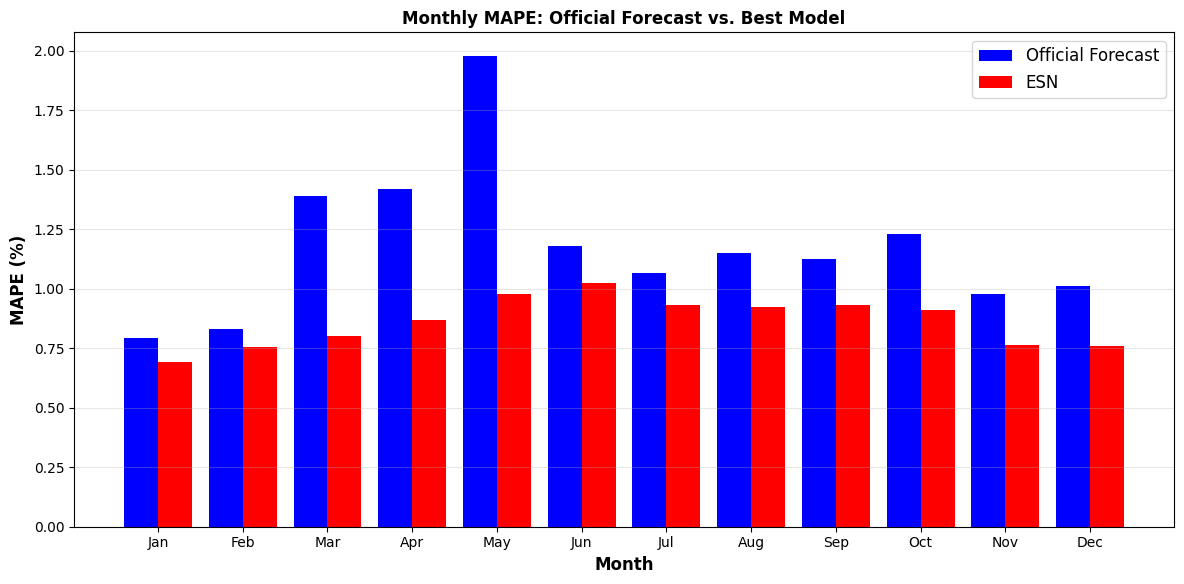

In [20]:
# PART 1: SAVE NECESSARY VARIABLES TO FILES
# This should be run after your model training is complete

import pandas as pd
import numpy as np
import os

# Create a directory to store the saved variables
os.makedirs('saved_variables', exist_ok=True)

# Save the test data and actual values
df_test.to_csv('saved_variables/df_test.csv', index=False)
np.save('saved_variables/y_test_final.npy', y_test_final)

# Save model predictions
np.save('saved_variables/y_pred_final.npy', y_pred_final)  # ESN predictions
np.save('saved_variables/y_pred_lstm_final.npy', y_pred_lstm_final)  # LSTM predictions
np.save('saved_variables/y_pred_cnnlstm_final.npy', y_pred_cnnlstm_final)  # CNN+LSTM predictions
np.save('saved_variables/y_pred_prophet_final.npy', y_pred_prophet_final)  # Prophet predictions

print("All variables saved to the 'saved_variables' directory")

# PART 2: STANDALONE COMPARISON CODE
# This can be run as a separate script

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import ttest_rel
import os
import matplotlib as mpl

# Create plots directory
os.makedirs('plots', exist_ok=True)

# Create PDF plot directory
os.makedirs('ReportFigures', exist_ok=True)

# Global font config
mpl.rcParams.update({
    'font.size': 12,
    'axes.titleweight': 'bold',
    'axes.labelweight': 'bold',
    'axes.labelsize': 12,
    'axes.titlesize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10
})

def save_pdf(fig, filename):
    fig.savefig(f"ReportFigures/{filename}.pdf", format='pdf', bbox_inches='tight')

# Load saved variables
print("Loading saved variables...")
df_test = pd.read_csv('saved_variables/df_test.csv')
if 'Timestamp' in df_test.columns:
    df_test['Timestamp'] = pd.to_datetime(df_test['Timestamp'])

y_test_final = np.load('saved_variables/y_test_final.npy')
y_pred_final = np.load('saved_variables/y_pred_final.npy')  # ESN
y_pred_lstm_final = np.load('saved_variables/y_pred_lstm_final.npy')  # LSTM
y_pred_cnnlstm_final = np.load('saved_variables/y_pred_cnnlstm_final.npy')  # CNN+LSTM
y_pred_prophet_final = np.load('saved_variables/y_pred_prophet_final.npy')  # Prophet

print("Variables loaded successfully")

official_forecast = df_test['Forecast Load'].values.reshape(-1, 1)
actual_values = y_test_final

print("\n=== COMPARISON WITH OFFICIAL FORECAST ===")
print("Note: Official forecast is issued for t+12-36, while models predict t+1")

def calculate_metrics(y_true, y_pred, name="Model"):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    r2 = r2_score(y_true, y_pred)
    return {"Model": name, "MAE": mae, "RMSE": rmse, "MAPE (%)": mape, "R²": r2}

metrics_list = [
    calculate_metrics(actual_values, official_forecast, "Official Forecast"),
    calculate_metrics(actual_values, y_pred_final, "ESN"),
    calculate_metrics(actual_values, y_pred_lstm_final, "LSTM"),
    calculate_metrics(actual_values, y_pred_cnnlstm_final, "CNN+LSTM"),
    calculate_metrics(actual_values, y_pred_prophet_final, "Prophet")
]

metrics_df = pd.DataFrame(metrics_list)
print("\nPerformance Metrics:")
print(metrics_df.to_string(index=False))
metrics_df.to_csv('plots/model_comparison_metrics.csv', index=False)

best_model = metrics_df.iloc[metrics_df["MAPE (%)"].idxmin()]["Model"]
official_mape = metrics_df.iloc[0]["MAPE (%)"]
best_model_mape = metrics_df["MAPE (%)"].min()
improvement = (official_mape - best_model_mape) / official_mape * 100

print(f"\nBest Model: {best_model} with MAPE: {best_model_mape:.2f}%")
print(f"Official Forecast MAPE: {official_mape:.2f}%")
print(f"Improvement over Official Forecast: {improvement:.2f}%")

best_model_idx = metrics_df["MAPE (%)"].idxmin()
best_model_name = metrics_df.iloc[best_model_idx]["Model"]
if best_model_name == "ESN":
    best_predictions = y_pred_final
elif best_model_name == "LSTM":
    best_predictions = y_pred_lstm_final
elif best_model_name == "CNN+LSTM":
    best_predictions = y_pred_cnnlstm_final
else:
    best_predictions = y_pred_prophet_final

official_errors = np.abs(actual_values - official_forecast).flatten()
best_model_errors = np.abs(actual_values - best_predictions).flatten()
t_stat, p_val = ttest_rel(official_errors, best_model_errors)

print(f"\nPaired t-test Official Forecast vs. {best_model_name}:")
print(f"t-statistic: {t_stat:.3f}, p-value: {p_val:.6f}")
if p_val < 0.05:
    print(f"The improvement is statistically significant (p < 0.05)")
else:
    print(f"The improvement is not statistically significant (p >= 0.05)")

max_plot = 300
plt.figure(figsize=(12, 6))
plt.plot(actual_values[:max_plot], label='Actual Values', linewidth=2, color='black')
plt.plot(official_forecast[:max_plot], label='Official Forecast', linestyle='--', color='blue')
plt.plot(best_predictions[:max_plot], label=f'Best Model ({best_model_name})', linestyle='-.', color='red')
plt.title('Comparison of Best Model vs. Official Forecast')
plt.xlabel('Time Step')
plt.ylabel('Load (MW)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
save_pdf(plt.gcf(), 'best_model_vs_official_forecast')

plt.figure(figsize=(10, 6))
plt.hist(official_errors, bins=30, alpha=0.5, label='Official Forecast Errors', color='blue')
plt.hist(best_model_errors, bins=30, alpha=0.5, label=f'{best_model_name} Errors', color='red')
plt.axvline(x=0, color='black', linestyle='--')
plt.title('Error Distribution: Official Forecast vs. Best Model')
plt.xlabel('Error (MW)')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
save_pdf(plt.gcf(), 'error_distribution_comparison')

df_test['Month'] = df_test['Timestamp'].dt.month
monthly_metrics = []

for month in range(1, 13):
    month_mask = df_test['Month'] == month
    if sum(month_mask) > 0:
        month_actual = actual_values[month_mask]
        month_official = official_forecast[month_mask]
        month_best = best_predictions[month_mask]
        
        if len(month_actual) > 0:
            official_mape = np.mean(np.abs((month_actual - month_official) / month_actual)) * 100
            best_mape = np.mean(np.abs((month_actual - month_best) / month_actual)) * 100
            
            monthly_metrics.append({
                'Month': month,
                'Official MAPE (%)': official_mape,
                f'{best_model_name} MAPE (%)': best_mape,
                'Improvement (%)': (official_mape - best_mape) / official_mape * 100
            })

monthly_df = pd.DataFrame(monthly_metrics)
if not monthly_df.empty:
    print("\nMonthly Performance Comparison:")
    print(monthly_df.to_string(index=False))
    
    monthly_df.to_csv('plots/monthly_performance_comparison.csv', index=False)
    
    plt.figure(figsize=(12, 6))
    plt.bar(monthly_df['Month'] - 0.2, monthly_df['Official MAPE (%)'], width=0.4, label='Official Forecast', color='blue')
    plt.bar(monthly_df['Month'] + 0.2, monthly_df[f'{best_model_name} MAPE (%)'], width=0.4, label=best_model_name, color='red')
    plt.title('Monthly MAPE: Official Forecast vs. Best Model')
    plt.xlabel('Month')
    plt.ylabel('MAPE (%)')
    plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                              'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    plt.legend()
    plt.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    save_pdf(plt.gcf(), 'monthly_performance_comparison')
